## Definitions

In [1]:
import numpy as np
import math
from scipy import special
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import matplotlib.colors as mcolors

from sympy.physics.wigner import wigner_3j

In [2]:
def integral_3j(s,l,m):
    """ 
    Compute the triple integral of spin-weighted harmonics over the unit shpere, using 3j symbols.
    Only applicable to the case where s1 + s2 + s3 = 0.

    Inputs: iterables; spin weights, s = (s1, s2, s3); Laplace spherical harmonics parameters l,m,  l = (l1, l2, l3); m = (m1, m2, m3).

    Outputs: float, result of the integral.

    """
    s1, s2, s3 = s
    l1, l2, l3 = l
    m1, m2, m3 = m

    if s1 + s2 + s3 != 0:        
        raise ValueError('Spin weights do not add up to 0.')   

    # Definiton in https://en.wikipedia.org/wiki/Spin-weighted_spherical_harmonics#Triple_integral.
    coeff = np.sqrt((2*l1+1)*(2*l2+1)*(2*l3+1)/(4*np.pi))
    cg1 = wigner_3j(l1, l2 ,l3, m1, m2, m3)
    cg2 = wigner_3j(l1, l2 ,l3,-s1, -s2, -s3)
    return coeff * cg1 * cg2

In [3]:
def selection(l1, l2, s, N):
    """
    Impose selection rules to avoid longer computation time when computing nonlinear terms with triple integrals.

    Inputs: floats;  given spherical harmonic parameters l1, l2; spin weight of the 3rd spherical harmonic, s; maximum l, N.

    Output: array; array of permissible (nonzero triple integral) [l3, m3].

    """
    # Define the Aarray of l3 values to iterate.
    L_array = np.arange(s,N+1)
  

    # Selection rules are listed in https://en.wikipedia.org/wiki/3-j_symbol#Selection_rules.
    ## Conditions
    triangle_up =  l1 + l2 + 1
    triangle_dn =  abs(l1 - l2) - 1

    total_l = L_array + l1 + l2

    condition1 =  np.logical_and(L_array < triangle_up, L_array > triangle_dn) # Triangle condition, note +- 1 above
    condition2 = np.logical_and(condition1, total_l % 2 == 0)                  # Evennes condition.
    
    # Define array of [l3,m3] to return.
    lm_toreturn = []
    
    for l3 in L_array[condition2]:
        lm_toreturn.extend(([(l3, m) for m in range(-l3,l3+1)])) # -l <= m <= l as usual
    
    return np.array(lm_toreturn)

In [4]:
def lm_modes(s,N):
    """
    Function to compute all the [l,m] modes avaliable for a given s and M.

    Inputs: floats; spin weight s; maximum l, N.

    Return: array; array of [l,m] values, -l <= m <= l as usual.
    
    """
    to_return = []
    to_return.extend([(l,m) for l in range(s, N + 1) for m in range(-l,l+1)])
    return np.array(to_return)

def indexlm(l,m):
    """
    Function to return the index of (l,m) in a 1-d array of modes ordered as: [[0,0], [1,-1], [1,0], [1,1], [2,-2] ...]

    """
    return l**2 + l + m

In [5]:
def eth(s,l):
    # Function to compute the numerical coefficient given by the spin raising operator eth.
    if abs(s) > l:
        return 0
    else:
        return np.sqrt((l-s)*(l+s+1)) 
    
def ethbar(s,l):
    # Function to compute the numerical coefficient given by the spin lowering operator ethbar.
    if abs(s) > l:
        return 0
    else:
        return -np.sqrt((l+s)*(l-s+1)) 

In [6]:
### Scalar field source functions

def source(varray, omega, sigma = 1, vstart = 0):
   """
    Function to create the time profile of the scalar field on the horizon.

   Inputs: varray: time array, has to include vstart
           omega:  complex number, QNM frequency 
           sigma:  float, standard deviation of the Gaussian ringup part
           vstart: float, starting time of the ringdown phase

    Return: array; time profile of the scalar field source

   """
   vs = np.argmin(abs(varray -vstart)) # index of ringdown starting time
   omega_R = np.real(omega) # real part of the frequency

   ringup =  np.exp(-varray[0:vs]**2/(2*sigma**2))*np.exp(-1j*omega_R*varray[0:vs]) 
   ringdown = np.exp(-1j*omega*varray[vs::])

   return np.concatenate((ringup, ringdown))

###
def gradsource(varray, omega, sigma = 1,vstart=0):
   """
    Function to create the time profile of the scalar field differentiated with respect to time.

   Inputs: varray: time array, has to include vstart
           omega:  complex number, QNM frequency 
           sigma:  float, standard deviation of the Gaussian ringup part
           vstart: float, starting time of the ringdown phase

    Return: array; time profile of the scalar field source differentiated with respect to time

   """
   vs = np.argmin(abs(varray -vstart)) # index of ringdown starting time
   omega_R = np.real(omega) # real part of the frequency

   ringup = -np.exp(-varray[0:vs]**2/(2*sigma**2))*(varray[0:vs]/sigma**2 + 1j*omega_R)*np.exp(-1j*omega_R*varray[0:vs])
   ringdown = -1j * omega * np.exp(-1j * omega * varray[vs::]) + gradf(varray[vs::], omega)  
   
   return np.concatenate((ringup, ringdown))

###
def f(v, omega):
     # auxillary function to make the transition from ringup to ringdown smoother for source(...)
        omega_re = np.real(omega)
        omega_im = np.imag(omega)
        return  (v*omega_im + v**2 * (omega_re **2 - omega_im**2 - 1)/2 )* np.exp(-v**2)  
def gradf(v, omega):
      # auxillary function to make the transition from ringup to ringdown smoother for gradsource(..)
        omega_re = np.real(omega)
        omega_im = np.imag(omega)
        return -omega_im *np.exp(-v**4) 

In [7]:
### Spin-weighted spherical harmonics _sY_lm

#  _sY_lm function
def yslm_no_zero(s, l, m, theta, phi):
    if l < abs(s) or abs(m) > l:
        print(f"Warning: l={l}, s={s}, m={m} does not satisfy the conditions for spherical harmonics.")
        return 0
    if s >= 0:
        prefac1 = (-1.)**(l + m - s)
        prefac2 = np.sqrt(math.factorial(int(l+m))*math.factorial(int(l-m))*(2*l+1)/(4*np.pi*math.factorial(int(l+s))*math.factorial(int(l-s))))
        prefac3 = np.exp(1j*m*phi)
        if theta.any() == 0:
            print("Warning: theta contains zero, this stops the function.")
            return None
        else:
            factor = 0
            for r in range(int(l - s + 1)):
                factor += special.binom(l - s, r) * special.binom(l + s, r + s - m) * (-1.)**(r) * np.cos(theta/2)**(2*r + s - m) * np.sin(theta/2)**(2*l - (2*r + s - m))
            return prefac1 * prefac2 * prefac3 * factor
    else:
        return (-1.)**(s + m) * yslm_no_zero(-s, l, -m, theta, phi).conjugate()  # Use the conjugate for negative s
    
# derivative of _sY_lm function wrt to phi
def dyslm_dphi(s, l, m, theta, phi):
    if l < abs(s) or abs(m) > l:
        print(f"Warning: l={l}, s={s}, m={m} does not satisfy the conditions for spherical harmonics.")
        return 0
    if s >= 0:
        prefac1 = (-1.)**(l + m - s)
        prefac2 = np.sqrt(math.factorial(int(l+m))*math.factorial(int(l-m))*(2*l+1)/(4*np.pi*math.factorial(int(l+s))*math.factorial(int(l-s))))
        prefac3 = 1j*m*phi * np.exp(1j*m*phi)
        if theta.any() == 0:
            print("Warning: theta contains zero, this stops the function.")
            return None
        else:
            factor = 0
            for r in range(int(l - s + 1)):
                factor += special.binom(l - s, r) * special.binom(l + s, r + s - m) * (-1.)**(r) * np.cos(theta/2)**(2*r + s - m) * np.sin(theta/2)**(2*l - (2*r + s - m))
            return prefac1 * prefac2 * prefac3 * factor
    else:
        return (-1.)**(s + m) * dyslm_dphi(-s, l, -m, theta, phi).conjugate()  # Use the conjugate for negative s    

## Initiate variables

In [8]:
# Set maximum L
N = 5 # Lmax

# Initiate time axis
n = 12001 # number of points in time 
varray = np.linspace(-30,210,n)      # v = 0 has to be in the array.
varray2 = np.linspace(-30,210,2*n-1) # time axis for sources
dv = varray[1] - varray[0]           # step size
print('The time step is: {:.4f}'.format(dv))

# Initiate spin-weighted coefficients for the quantities in the 2nd order in perturbation
Theta = np.zeros((len(lm_modes(0, N)),len(varray)), dtype=np.cdouble) # null expansion
Cab   = np.zeros((len(lm_modes(0, N)),len(varray)), dtype=np.cdouble) # sphere metric
Haji  = np.zeros((len(lm_modes(0, N)),len(varray)), dtype=np.cdouble) # Hajicek field
Knaf  = np.zeros((len(lm_modes(0, N)),len(varray)), dtype=np.cdouble) # surface gravity

# Initiate nonlinear source terms for respective equations
nonlinear_T = np.zeros((len(lm_modes(0, N)),len(varray2)), dtype=np.cdouble)
nonlinear_C = np.zeros((len(lm_modes(0, N)),len(varray2)), dtype=np.cdouble)
nonlinear_H = np.zeros((len(lm_modes(0, N)),len(varray2)), dtype=np.cdouble)
nonlinear_Hbar = np.zeros((len(lm_modes(0, N)),len(varray2)), dtype=np.cdouble)
nonlinear_K = np.zeros((len(lm_modes(0, N)),len(varray2)), dtype=np.cdouble)

The time step is: 0.0200


QNM modes for scalar perturbations of Schwarzschild (a = 0):
- n, l, m
- 0, 0, 0: (0.1105 - 0.1049j)
- 0, 1, 0: (0.2929 - 0.0977j)
- 0, 1, 1: (0.2929 - 0.0977j)
- 0, 1,-1: (0.2929 - 0.0977j)
- 0, 2, 0: (0.4836 - 0.0968j)

In [9]:
#Initiate source and its gradient in time
Phi    = np.zeros((len(lm_modes(0, N)),len(varray2)), dtype=np.cdouble)
dPhidv = np.zeros((len(lm_modes(0, N)),len(varray2)), dtype=np.cdouble)

epsilon  = np.sqrt(3)*1e-4 # small source parameter -- used only introduce when combining with O(1) quantities
qnm_scalar = [0.1105 - 0.1049*1j, 0.2929 - 0.0977*1j, 0.4836 - 0.0968*1j] # QNM frequencies

#l = 0, 1, 2 modes are nonzero
Phi[indexlm(0,0)] =   1.00 * np.real(source(varray2,qnm_scalar[0], sigma = 1,vstart=0)) 
Phi[indexlm(1,1)] =   0.50 * (source(varray2,qnm_scalar[1], sigma = 1,vstart=0))
Phi[indexlm(1,-1)] =  (-1)**(1)*np.conj(Phi[indexlm(1,1)])
Phi[indexlm(2,0)] =   0.25 * np.real(source(varray2,qnm_scalar[2], sigma = 1,vstart=0))

# Also the gradient in time
dPhidv[indexlm(0,0)] =  1.00 * np.real(gradsource(varray2,qnm_scalar[0], sigma = 1,vstart=0))  
dPhidv[indexlm(1,1)]  = 0.50 * (gradsource(varray2,qnm_scalar[1], sigma = 1,vstart=0))
dPhidv[indexlm(1,-1)] = (-1)**(1)*np.conj(dPhidv[indexlm(1,1)]) 
dPhidv[indexlm(2,0)] =  0.25 * np.real(gradsource(varray2,qnm_scalar[2], sigma = 1,vstart=0)) 

Text(0.5, 1.0, '$\\partial_v \\Phi$')

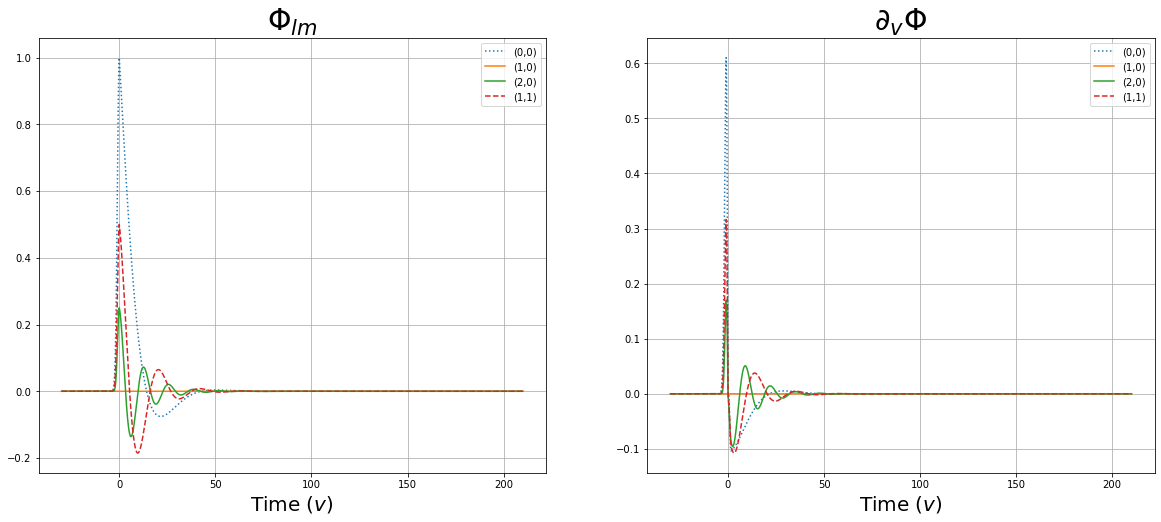

In [10]:
# Plot the different lm modes in time
plt.subplots(figsize=(20, 8))

plt.subplot(1,2,1)
plt.plot(varray2,np.real(Phi[indexlm(0,0)]), label='(0,0)', ls = 'dotted')
plt.plot(varray2,np.real(Phi[indexlm(1,0)]), label='(1,0)')
plt.plot(varray2,np.real(Phi[indexlm(2,0)]), label='(2,0)')
plt.plot(varray2,np.real(Phi[indexlm(1,1)]), label='(1,1)', linestyle='--')
plt.grid("On")
plt.legend()
plt.title(r"$\Phi_{lm}$", fontsize=30)
plt.xlabel("Time $(v)$", fontsize=20)
#plt.xlim([-30,60])

plt.subplot(1,2,2)
# Plot the different lm modes in time
plt.plot(varray2,np.real(dPhidv[indexlm(0,0)]), label='(0,0)', ls = 'dotted')
#plt.plot(varray2,np.real(dPhidv[indexlm(1,1)]), label='(1,1)')
plt.plot(varray2,np.real(dPhidv[indexlm(1,0)]), label='(1,0)')
plt.plot(varray2,np.real(dPhidv[indexlm(2,0)]), label='(2,0)')
plt.plot(varray2,np.real(dPhidv[indexlm(1,1)]), label='(1,1)', linestyle='--')
plt.grid("On")
plt.legend()
plt.xlabel("Time $(v)$", fontsize=20)
plt.title("$\partial_v \Phi$", fontsize=30)
#plt.xlim([-30,60])

(1e-07, 100.0)

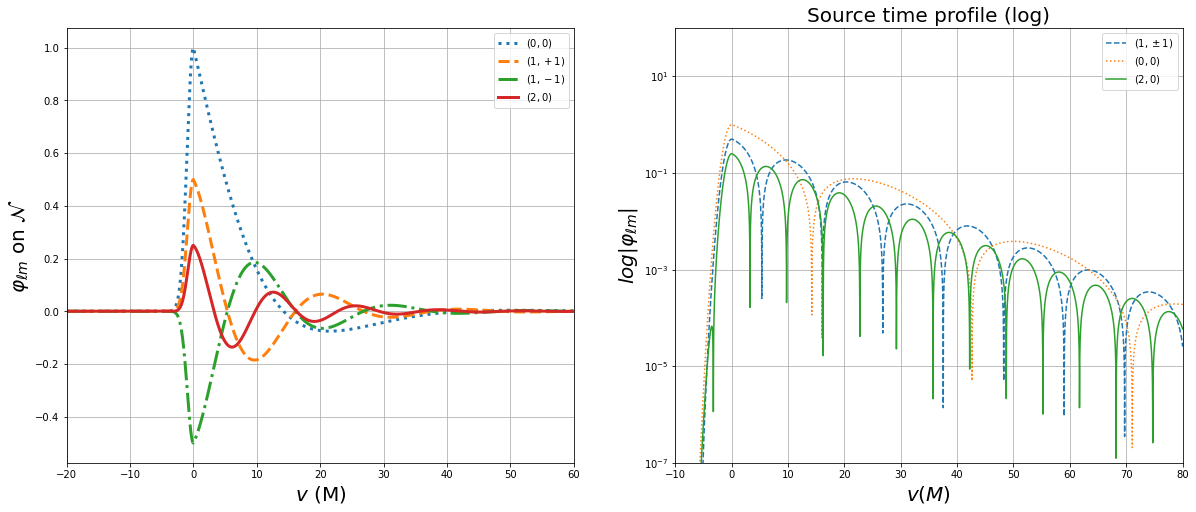

In [11]:
plt.subplots(figsize=(20, 8))

plt.subplot(1,2,1)
plt.plot(varray2,np.real(Phi[indexlm(0,0)]),  label= r'$(0,0)$',  linestyle = ':', linewidth = 3)
plt.plot(varray2,np.real(Phi[indexlm(1,1)]),  label= r'$(1,+1)$', linestyle = '--', linewidth = 3)
plt.plot(varray2,np.real(Phi[indexlm(1,-1)]), label= r'$(1,-1)$', linestyle = '-.', linewidth = 3)
plt.plot(varray2,np.real(Phi[indexlm(2,0)]),  label= r'$(2,0)$',  linestyle = '-', linewidth = 3)
plt.plot()
plt.grid("On")
plt.legend()
plt.xlabel(r"$v \, \, (\mathrm{M})$", fontsize=20)
plt.ylabel(r"$\varphi_{\ell m}$ on $\mathcal{N}$", fontsize=20)
plt.xlim([-20,60])
#plt.savefig('source_profile-thickk.pdf', bbox_inches='tight')

plt.subplot(1,2,2)
plt.semilogy(varray2,abs(np.real(Phi[indexlm(1,1)])), label=r'$(1,\pm1)$', linestyle='--')
plt.semilogy(varray2,abs(np.real(Phi[indexlm(0,0)])), label=r'$(0,0)$', ls = ':')
plt.semilogy(varray2,abs(np.real(Phi[indexlm(2,0)])), label=r'$(2,0)$', ls = '-')


plt.grid("On")
plt.legend()
plt.title(r"Source time profile (log)", fontsize=20)
plt.xlabel(r"$v(M)$", fontsize=20)
plt.ylabel(r"$log{|\varphi_{\ell m}|}$", fontsize=20)
plt.xlim([-10,80])
plt.ylim([1e-7,1e2])


### Compute the nonlinear terms

#### $\partial_v\Theta$ equation source

In [12]:
# Compute the nonlinear terms for each equations.
# Read the I values
with open("selbarI000.txt") as file_T: #barI000.txt selbar
    lines_T = [line.rstrip().split() for line in file_T]

In [13]:
#Compute the excited modes in time.
index_T = indexlm(0,0)
LMI_time = 0

for line in lines_T[1::]:
    
    S, L, M, s1, l1, m1, s2, l2, m2, I = line 
    index_T_new = indexlm(int(L),int(M))
    
    if index_T_new != index_T:
        
        nonlinear_T[index_T] = LMI_time 
        LMI_time = 0
        index_T = index_T_new
        
    index_phi_1 = indexlm(int(l1),int(m1))
    index_phi_2 = indexlm(int(l2),int(m2))
    
    dphi_dv_1 = dPhidv[index_phi_1]
    dphi_dv_2 = dPhidv[index_phi_2]
    
    LMI_time += float(I) * dphi_dv_1 * dphi_dv_2 

(-10.0, 30.0)

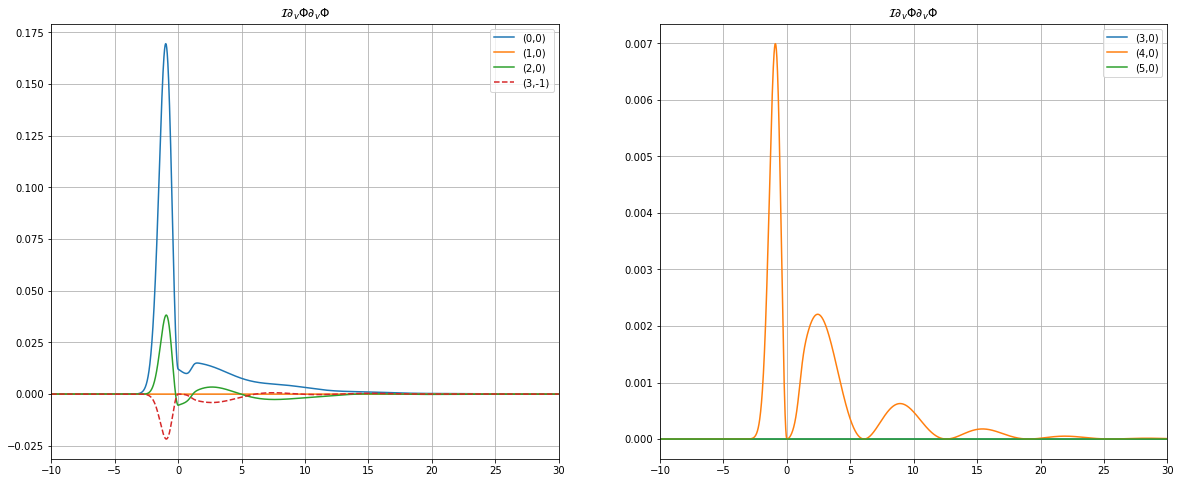

In [14]:
# Plot the different lm modes in time
plt.subplots(figsize=(20, 8))

plt.subplot(1,2,1)
plt.plot(varray2, np.real(nonlinear_T[indexlm(0,0)]), label='(0,0)')

plt.plot(varray2, np.real(nonlinear_T[indexlm(1,0)]), label='(1,0)')
plt.plot(varray2, np.real(nonlinear_T[indexlm(2,0)]), label='(2,0)')
plt.plot(varray2, np.real(nonlinear_T[indexlm(3,-1)]), label='(3,-1)', linestyle='--')
#plt.plot(varray2, np.real(nonlinear_T[indexlm(2,2)]), label='(2,2)')
#plt.plot(varray2, np.real(nonlinear_T[indexlm(2,1)]), label='(2,1)')
plt.legend()
plt.grid("On")
plt.title("$\mathcal{I} \partial_v \Phi \partial_v \Phi$")
plt.xlim([-10,30])

plt.subplot(1,2,2)
plt.plot(varray2, np.real(nonlinear_T[indexlm(3,0)]), label='(3,0)')
plt.plot(varray2, np.real(nonlinear_T[indexlm(4,0)]), label='(4,0)')
plt.plot(varray2, np.real(nonlinear_T[indexlm(5,0)]), label='(5,0)')
plt.legend()
plt.grid("On")
plt.title("$\mathcal{I} \partial_v \Phi \partial_v \Phi$")
plt.xlim([-10,30])

#### $\partial_v C$ equation source

In [15]:
# Read the I values
with open("selbarI211.txt") as file_C: #barI211.txt selbar
    lines_C = [line.rstrip().split() for line in file_C]

In [16]:
# Compute the excited modes in time.
index_C = indexlm(2,-2)
LMI_time = 0

#for ii in range(0,len(varray)+1):
for line in lines_C[1::]:
    
    S, L, M, s1, l1, m1, s2, l2, m2, I = line 
    index_C_new = indexlm(int(L),int(M))
    
    if index_C_new != index_C:
        

        nonlinear_C[index_C] = LMI_time 
        LMI_time = 0
        index_C = index_C_new
        
    index_phi_1 = indexlm(int(l1),int(m1))
    index_phi_2 = indexlm(int(l2),int(m2))
    
    ethphi1 = eth(0,int(l1)) * Phi[index_phi_1]
    ethphi2 = eth(0,int(l2)) * Phi[index_phi_2]
    
    LMI_time += float(I) * ethphi1 * ethphi2 

Text(0.5, 1.0, '$\\mathcal{I} \\eth \\Phi \\eth \\Phi$')

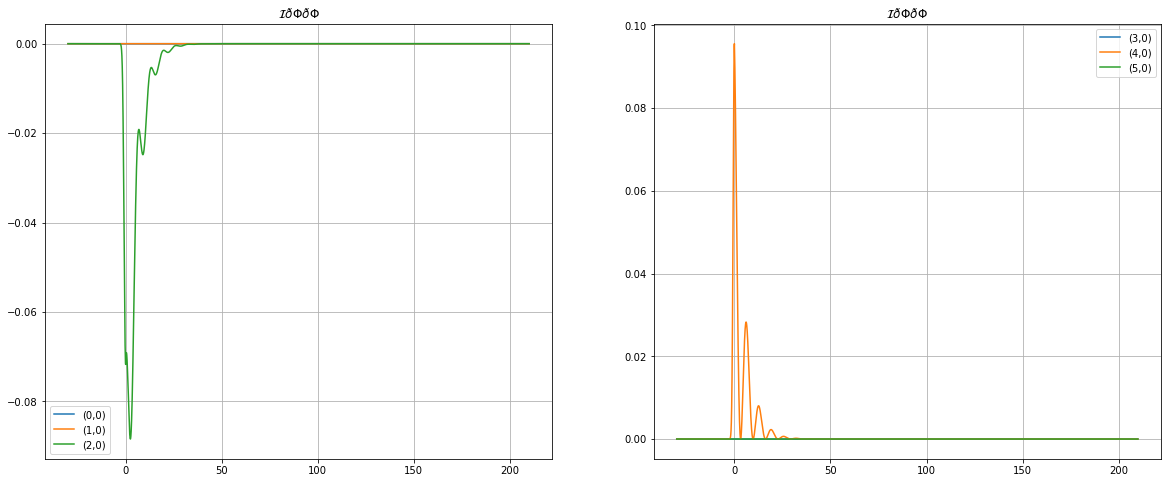

In [17]:
# Plot the different lm modes in time
plt.subplots(figsize=(20, 8))

plt.subplot(1,2,1)
plt.plot(varray2, np.real(nonlinear_C[indexlm(0,0)]), label='(0,0)')
plt.plot(varray2, np.real(nonlinear_C[indexlm(1,0)]), label='(1,0)')
plt.plot(varray2, np.real(nonlinear_C[indexlm(2,0)]), label='(2,0)')
plt.legend()
plt.grid("On")
plt.title("$\mathcal{I} \eth \Phi \eth \Phi$")

plt.subplot(1,2,2)
plt.plot(varray2, np.real(nonlinear_C[indexlm(3,0)]), label='(3,0)')
plt.plot(varray2, np.real(nonlinear_C[indexlm(4,0)]), label='(4,0)')
plt.plot(varray2, np.real(nonlinear_C[indexlm(5,0)]), label='(5,0)')
plt.legend()
plt.grid("On")
plt.title("$\mathcal{I} \eth \Phi \eth \Phi$")


#### $\partial_v H$ equation source

In [18]:
# Read the I values
with open("selbarI101.txt") as file_H: #barI101 selbar
    lines_H = [line.rstrip().split() for line in file_H]

In [19]:
# Compute the excited modes in time.
index_H = indexlm(1,-1)
LMI_time = 0
LMI_timebar = 0 
for line in lines_H[1::]:
    S, L, M, s1, l1, m1, s2, l2, m2, I = line 
    index_H_new = indexlm(int(L),int(M))
    
    if index_H_new != index_H:   
        
        nonlinear_H[index_H] = LMI_time 
        nonlinear_Hbar[index_H] = LMI_timebar 
        LMI_time = 0
        LMI_timebar = 0 
        index_H = index_H_new
        
    index_phi_1 = indexlm(int(l1),int(m1))
    index_phi_2 = indexlm(int(l2),int(m2))
    
    dphi_dv1 = dPhidv[index_phi_1]
    ethphi2 = eth(0,int(l2)) * Phi[index_phi_2]
    ethbarphi2 = ethbar(0,int(l2)) * Phi[index_phi_2]
        
    LMI_time += float(I) * dphi_dv1 * ethphi2 
    LMI_timebar += float(I) * dphi_dv1 * ethbarphi2 

Text(0.5, 1.0, '$\\mathcal{I} \\partial_v \\Phi \\eth \\Phi$')

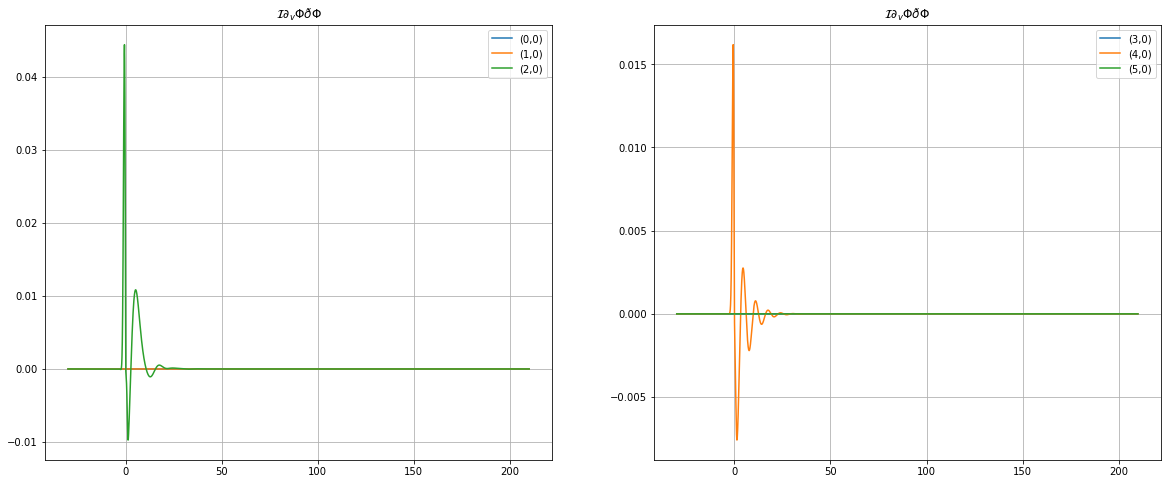

In [20]:
# Plot the different lm modes in time
plt.subplots(figsize=(20, 8))

plt.subplot(1,2,1)
plt.plot(varray2, np.real(nonlinear_H[indexlm(0,0)]), label='(0,0)')
plt.plot(varray2, np.real(nonlinear_H[indexlm(1,0)]), label='(1,0)')
plt.plot(varray2, np.real(nonlinear_H[indexlm(2,0)]), label='(2,0)')
plt.legend()
plt.grid("On")
plt.title(r"$\mathcal{I} \partial_v \Phi \eth \Phi$")

plt.subplot(1,2,2)
plt.plot(varray2, np.real(nonlinear_H[indexlm(3,0)]), label='(3,0)')
plt.plot(varray2, np.real(nonlinear_H[indexlm(4,0)]), label='(4,0)')
plt.plot(varray2, np.real(nonlinear_H[indexlm(5,0)]), label='(5,0)')
plt.legend()
plt.grid("On")
plt.title(r"$\mathcal{I} \partial_v \Phi \eth \Phi$")


#### $K$ equation source

In [21]:
# Read the I values
with open("selbarI01-1.txt") as file_K: #barI01-1.txt" selbar
    lines_K = [line.rstrip().split() for line in file_K]

In [22]:
# Compute the excited modes in time.
index_K = indexlm(0,0)
LMI_time = 0

#for ii in range(0,len(varray)+1):
for line in lines_K[1::]:
    S, L, M, s1, l1, m1, s2, l2, m2, I = line 
    index_K_new = indexlm(int(L),int(M))
    
    if index_K_new != index_K:
        
        nonlinear_K[index_K] = LMI_time 
        LMI_time = 0
        index_K = index_K_new
        
    index_phi_1 = indexlm(int(l1),int(m1))
    index_phi_2 = indexlm(int(l2),int(m2))
    
    ethphi1 = eth(0,int(l1)) * Phi[index_phi_1]
    ethphi2 = ethbar(0,int(l2)) * Phi[index_phi_2]
        
    LMI_time += float(I) * ethphi1 * ethphi2 

Text(0.5, 1.0, '$\\mathcal{I} \\bar{\\eth} \\Phi \\eth \\Phi$')

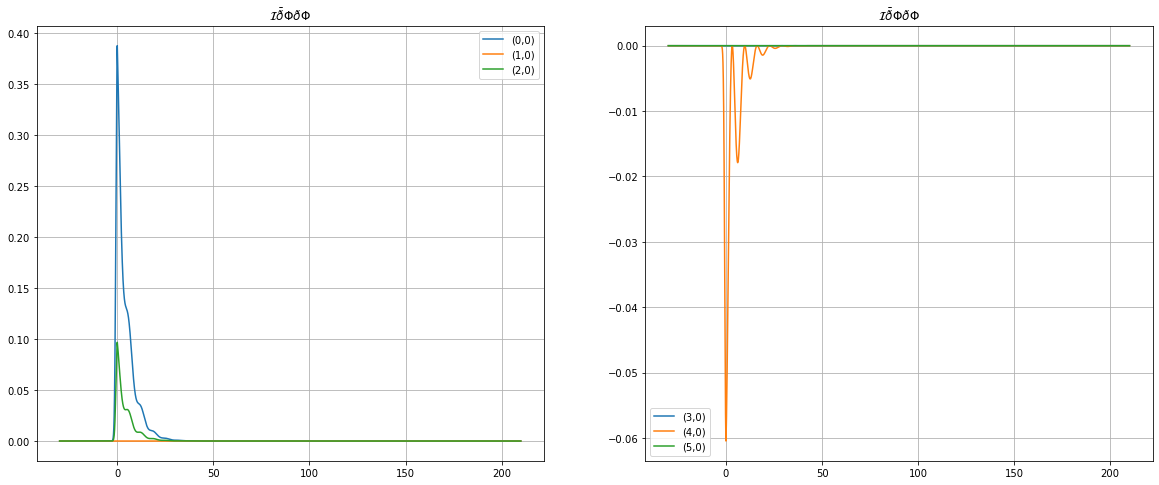

In [23]:
# Plot the different lm modes in time
plt.subplots(figsize=(20, 8))

plt.subplot(1,2,1)
plt.plot(varray2, np.real(nonlinear_K[indexlm(0,0)]), label='(0,0)')
plt.plot(varray2, np.real(nonlinear_K[indexlm(1,0)]), label='(1,0)')
plt.plot(varray2, np.real(nonlinear_K[indexlm(2,0)]), label='(2,0)')
plt.legend()
plt.grid("On")
plt.title(r"$\mathcal{I} \bar{\eth} \Phi \eth \Phi$")

plt.subplot(1,2,2)
plt.plot(varray2, np.real(nonlinear_K[indexlm(3,0)]), label='(3,0)')
plt.plot(varray2, np.real(nonlinear_K[indexlm(4,0)]), label='(4,0)')
plt.plot(varray2, np.real(nonlinear_K[indexlm(5,0)]), label='(5,0)')
plt.legend()
plt.grid("On")
plt.title(r"$\mathcal{I} \bar{\eth} \Phi \eth \Phi$")

## Integrate

In [24]:
# Prepare the right-hand sides to integrate. Invert the sign of time derivatives.
def dT_dv(N, T, nonlinear):
    # Inputs are Theta(v) and nonlinear(v)
    # Output is Theta(v+dv)
    
    dTdv = np.zeros(len(lm_modes(0, N)), dtype=np.cdouble)
    
    for LM in lm_modes(0,N):
        
        L, M = LM
        LMindex = indexlm(L,M)
        
        T_LM = T[LMindex]
        Source_LM = nonlinear[LMindex]* (8*np.pi)
        
        dTdv_LM = 1/4 * T_LM - Source_LM 
        dTdv[LMindex] = dTdv_LM
    
    return dTdv

def dC_dv(N, C, H, nonlinear):
    
    dCdv = np.zeros(len(lm_modes(0, N)), dtype=np.cdouble)
    
    for LM in lm_modes(2,N):
        
        L, M = LM
        LMindex = indexlm(L,M)
        
        C_LM = C[LMindex]
        H_LM = H[LMindex]
        Source_LM = nonlinear[LMindex]* (8*np.pi)
        
        dCdv_LM = -(1/2 * C_LM) + (4 * eth(1,L) * H_LM) + (2 * Source_LM)
        dCdv[LMindex] = dCdv_LM
        
    return dCdv
    
def dH_dv(N, C, H, Theta, nonlinear_C, nonlinear_H, nonlinear_K):
    # I think dCdv has to be an input
    dHdv = np.zeros(len(lm_modes(0, N)), dtype=np.cdouble)
    #dCdv = dC_dv(N, C, H, nonlinear_C)
    
    for LM in lm_modes(1,N):
        
        L, M = LM
        LMindex = indexlm(L,M)
        L_Mindex = indexlm(L,-M)
        
        H_LM = H[LMindex]
        C_LM = C[LMindex]
        C_L_M = C[L_Mindex]
        H_L_M = H[L_Mindex]
        Theta_LM = Theta[LMindex]
        #K_LM = K[LMindex]
        Source_LM = nonlinear_H[LMindex]  * (8*np.pi)
        cSource_LM = nonlinear_C[LMindex] * (8*np.pi)
        kSource_LM = nonlinear_K[LMindex] * (8*np.pi)

        dHdv_LM = (-1/2 * (ethbar(2,L) * eth(1,L) * H_LM  ) - 1/8 * eth(0,L) *(ethbar(1,L) * H_LM + eth(-1,L) * (-1.)**(1-M) * np.conjugate(H_L_M))
                    + 1/16*(ethbar(2,L) * C_LM )+  0 *1/64 * eth(0,L)* (ethbar(1,L)*ethbar(2,L) *C_LM + eth(-1,L)*eth(-2,L) * (-1.)**(2-M)  * np.conjugate(C_L_M)) 
                   + 1/2*eth(0,L)*Theta_LM - 1/4*eth(0,L)*kSource_LM -1/4*ethbar(2,L)*cSource_LM + Source_LM)
        ### triple eth term is suppressed!!
        dHdv[LMindex] = dHdv_LM
    return dHdv
    
def K_t(N, C, H, nonlinear):
    
    K = np.zeros(len(lm_modes(0, N)), dtype=np.cdouble)
    
    for LM in lm_modes(0,N):
        
        L, M = LM
        LMindex =  indexlm(L,M)
        L_Mindex = indexlm(L,-M)
        
        C_LM = C[LMindex]
        H_LM = H[LMindex]
        C_L_M = C[L_Mindex]
        H_L_M = H[L_Mindex]

        Source_LM = nonlinear[LMindex]* (8*np.pi)
        
        K_LM = +(1/64 * eth(0,L)* (ethbar(1,L)*ethbar(2,L) *C_LM + eth(-1,L)*eth(-2,L) * (-1.)**(2-M)  * np.conjugate(C_L_M)) ) - 1/8 * eth(0,L) *(ethbar(1,L) * H_LM + eth(-1,L) * (-1.)**(1-M) * np.conjugate(H_L_M))-(1/4*Source_LM)
        K[LMindex] = K_LM
        
    return K

In [25]:
# Integrate with RK4 
dCdv_now = np.zeros(len(lm_modes(0, N)))
for ii in reversed(range(1,len(varray))):
    
    vnow  = varray[ii]
    #print(vnow)
    
    C_now = Cab[::,ii]
    H_now = Haji[::,ii]
    T_now = Theta[::,ii]
    
    

    k1 = -dv * np.array([dT_dv(N, T_now, nonlinear_T[::,2*(ii)]),
                             dC_dv(N, C_now, H_now, nonlinear_C[::,2*(ii)]), 
                             dH_dv(N, C_now, H_now, T_now, nonlinear_C[::,2*(ii)], nonlinear_H[::,2*(ii)], nonlinear_K[::,2*(ii)])])
    
    #K_now = K_t(N, C_now + k1[1]/2,  H_now + k1[2]/2, nonlinear_K[::,ii])
    k2 = -dv * np.array([dT_dv(N, T_now + k1[0]/2, nonlinear_T[::,2*ii-1]),
                             dC_dv(N, C_now + k1[1]/2, H_now + k1[2]/2, nonlinear_C[::,2*ii-1]), 
                             dH_dv(N, C_now + k1[1]/2, H_now + k1[2]/2,  T_now + k1[0]/2, nonlinear_C[::,2*ii-1], nonlinear_H[::,2*ii-1], nonlinear_K[::,2*ii-1])])
    
    #K_now = K_t(N, C_now + k2[1]/2,  H_now + k2[2]/2, nonlinear_K[::,ii])
    k3 = -dv * np.array([dT_dv(N, T_now + k2[0]/2, nonlinear_T[::,2*ii-1]),
                             dC_dv(N, C_now + k2[1]/2, H_now + k2[2]/2, nonlinear_C[::,2*ii-1]), 
                             dH_dv(N, C_now + k2[1]/2, H_now + k2[2]/2, T_now + k2[0]/2, nonlinear_C[::,2*ii-1], nonlinear_H[::,2*ii-1], nonlinear_K[::,2*ii-1])])
    
    #K_now = K_t(N, C_now + k3[1],  H_now + k3[2], nonlinear_K[::,ii])
    k4 = -dv * np.array([dT_dv(N, T_now + k3[0], nonlinear_T[::,2*ii-2]),
                             dC_dv(N, C_now + k3[1], H_now + k3[2], nonlinear_C[::,2*ii-2]), 
                             dH_dv(N, C_now + k3[1], H_now + k3[2], T_now + k3[0], nonlinear_C[::,2*ii-2], nonlinear_H[::,2*ii-2], nonlinear_K[::,2*ii-2])])

    # next step
    yarray =  np.array([T_now, C_now, H_now]) + 1/6*k1 + 1/3*k2 + 1/3*k3 + 1/6*k4
    
    Theta[::,ii-1]= yarray[0]
    Cab[::,ii-1]  = yarray[1]
    Haji[::,ii-1] = yarray[2]

    # how to  compute K? 
    K_next = K_t(N, Cab[::,ii-1], Haji[::,ii-1], nonlinear_K[::,ii-1])
    Knaf[::,ii-1] = K_next

    dCdv_now = dC_dv(N, Cab[::,ii], Haji[::,ii], nonlinear_C[::,ii]) # Euler
# Last K    
#Knaf[::,0] = K_t(N, Cab[::,0], Haji[::,0], nonlinear_K[::,0])

## Results of integration

### Linear plots in time

(-10.0, 30.0)

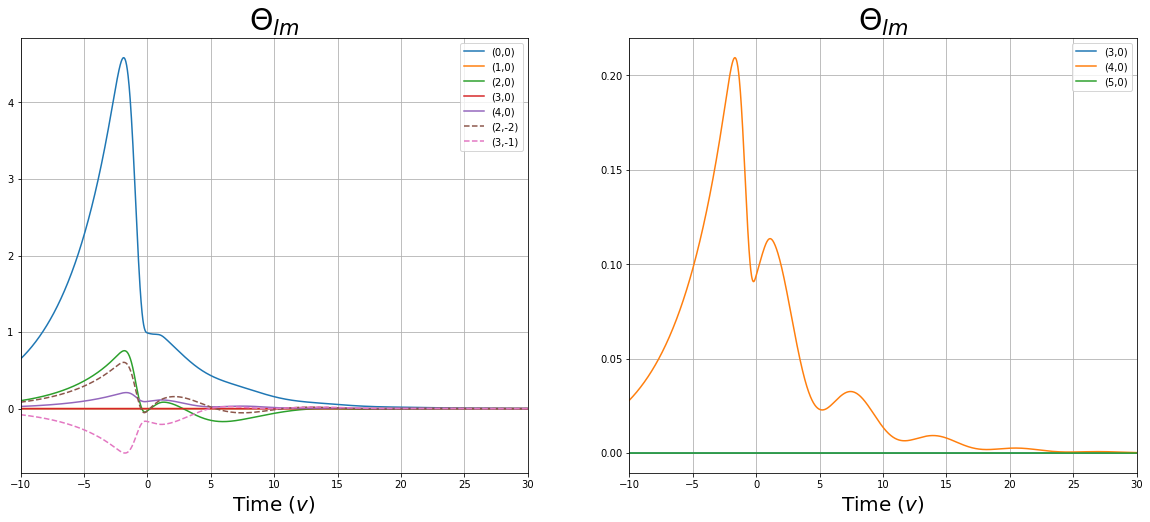

In [26]:
# Plot the different lm modes in time
plt.subplots(figsize=(20, 8))

plt.subplot(1,2,1)
plt.plot(varray,np.real(Theta[indexlm(0,0)]), label='(0,0)')
plt.plot(varray,np.real(Theta[indexlm(1,0)]), label='(1,0)')
plt.plot(varray,np.real(Theta[indexlm(2,0)]), label='(2,0)')
plt.plot(varray,np.real(Theta[indexlm(3,0)]), label='(3,0)')
plt.plot(varray,np.real(Theta[indexlm(4,0)]), label='(4,0)')
plt.plot(varray,np.real(Theta[indexlm(2,-2)]), label='(2,-2)', linestyle='--')
plt.plot(varray,np.real(Theta[indexlm(3,-1)]), label='(3,-1)', linestyle='--')
#plt.plot(varray, np.real(Theta_summed), label='Resummed', color="black")
plt.legend()
plt.grid("On")
plt.title(r"$\Theta_{lm}$", fontsize=30)
plt.xlabel("Time $(v)$", fontsize=20)
plt.xlim([-10,30])

plt.subplot(1,2,2)
plt.plot(varray,np.real(Theta[indexlm(3,0)]), label='(3,0)')
plt.plot(varray,np.real(Theta[indexlm(4,0)]), label='(4,0)')
plt.plot(varray,np.real(Theta[indexlm(5,0)]), label='(5,0)')
plt.legend()
plt.grid("On")
plt.title(r"$\Theta_{lm}$", fontsize=30)
plt.xlabel("Time $(v)$", fontsize=20)
plt.xlim([-10,30])

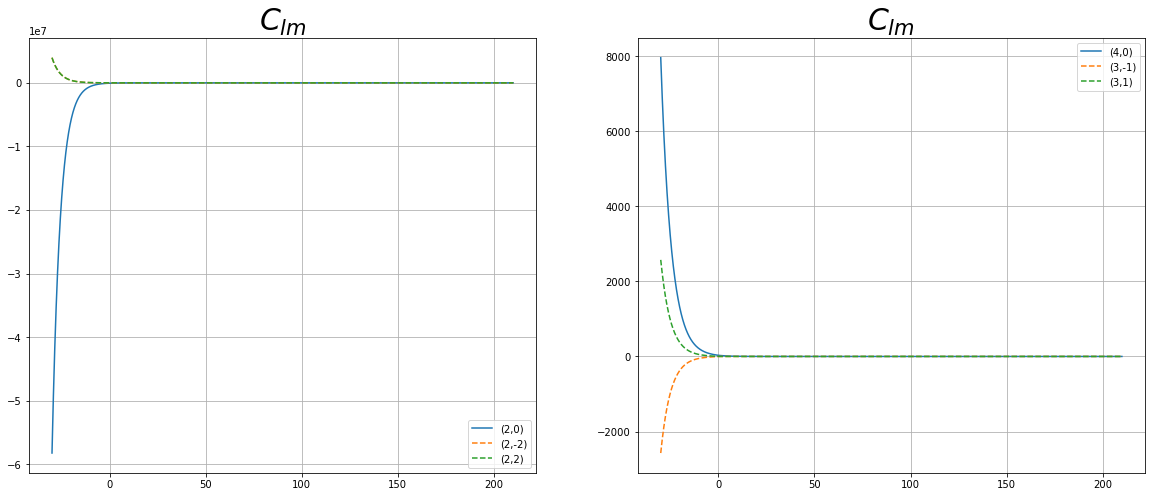

In [27]:
# Plot the different lm modes in time
plt.subplots(figsize=(20, 8))

plt.subplot(1,2,1)
#plt.plot(varray,np.real(Cab[indexlm(0,0)]), label='(0,0)')
#plt.plot(varray,np.real(Cab[indexlm(1,0)]), label='(1,0)')
plt.plot(varray,np.real(Cab[indexlm(2,0)]), label='(2,0)')
#plt.plot(varray,np.real(Cab[indexlm(1,-1)]), label='(1,-1)', linestyle='--')
#plt.plot(varray,np.real(Cab[indexlm(1,1)]), label='(1,1)', linestyle='--')
plt.plot(varray,np.real(Cab[indexlm(2,-2)]), label='(2,-2)', linestyle='--')
plt.plot(varray,np.real(Cab[indexlm(2,2)]), label='(2,2)', linestyle='--')
plt.title(r"$C_{lm}$", fontsize=30)
plt.legend()
plt.grid("On")

plt.subplot(1,2,2)
#plt.plot(varray,np.real(Cab[indexlm(3,0)]), label='(3,0)')
plt.plot(varray,np.real(Cab[indexlm(4,0)]), label='(4,0)')
#plt.plot(varray,np.real(Cab[indexlm(5,0)]), label='(5,0)')
plt.plot(varray,np.real(Cab[indexlm(3,-1)]), label='(3,-1)', linestyle='--')
plt.plot(varray,np.real(Cab[indexlm(3,1)]),  label='(3,1)', linestyle='--')
plt.title(r"$C_{lm}$", fontsize=30)
#plt.ylim([-0.001,0.001])
plt.legend()
plt.grid("On")

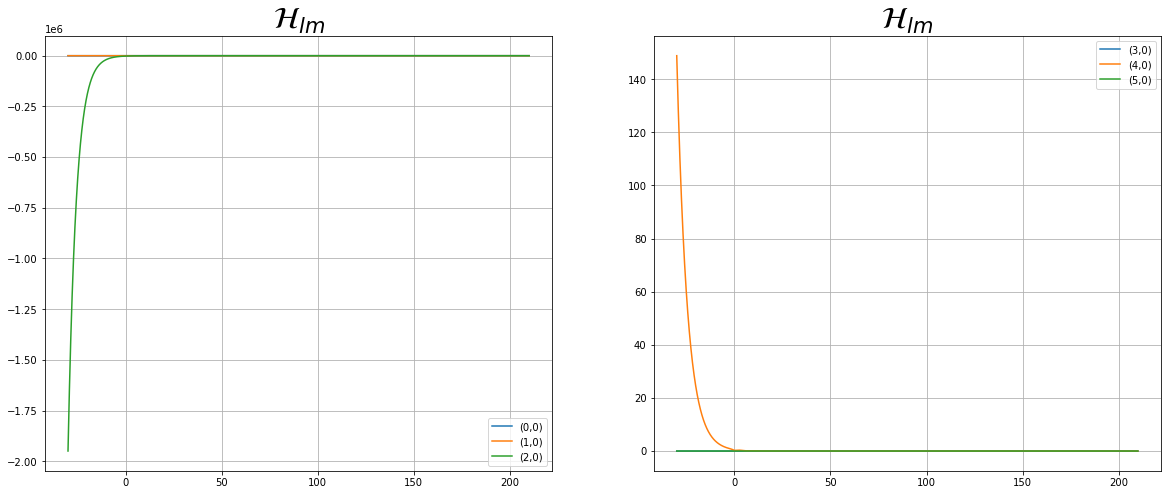

In [28]:
# Plot the different lm modes in time
plt.subplots(figsize=(20, 8))

plt.subplot(1,2,1)
plt.plot(varray,np.real(Haji[indexlm(0,0)]), label='(0,0)')
plt.plot(varray,np.real(Haji[indexlm(1,0)]), label='(1,0)')
plt.plot(varray,np.real(Haji[indexlm(2,0)]), label='(2,0)')
plt.title(r"$\mathcal{H}_{lm}$", fontsize=30)
plt.legend()
plt.grid("On")

plt.subplot(1,2,2)
plt.plot(varray,np.real(Haji[indexlm(3,0)]), label='(3,0)')
plt.plot(varray,np.real(Haji[indexlm(4,0)]), label='(4,0)')
plt.plot(varray,np.real(Haji[indexlm(5,0)]), label='(5,0)')
plt.title(r"$\mathcal{H}_{lm}$", fontsize=30)
plt.legend()
plt.grid("On")

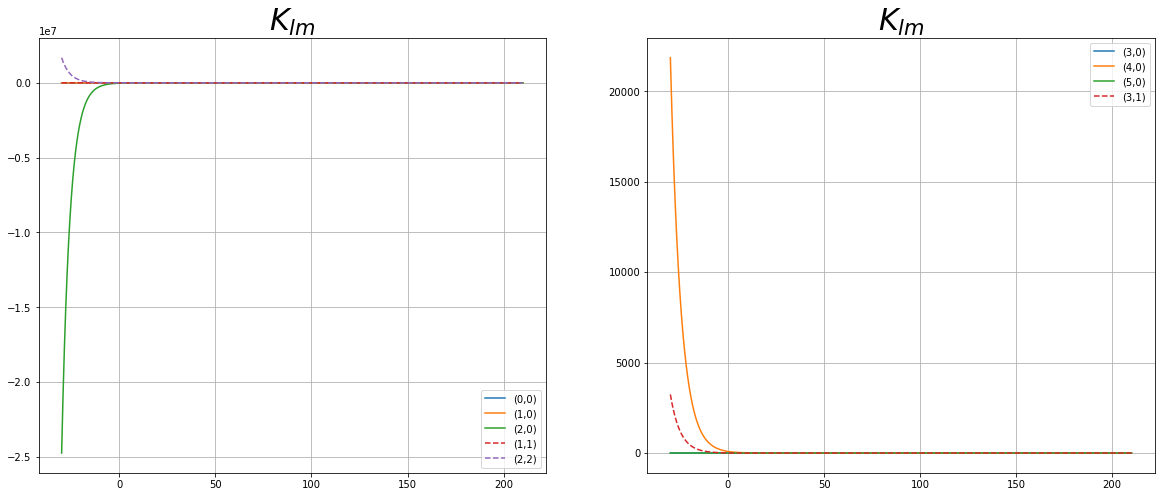

In [29]:
# Plot the different lm modes in time
plt.subplots(figsize=(20, 8))

plt.subplot(1,2,1)
plt.plot(varray,np.real(Knaf[indexlm(0,0)]), label='(0,0)')
plt.plot(varray,np.real(Knaf[indexlm(1,0)]), label='(1,0)')
plt.plot(varray,np.real(Knaf[indexlm(2,0)]), label='(2,0)')
plt.plot(varray,np.real(Knaf[indexlm(1,1)]), label='(1,1)', linestyle='--')
plt.plot(varray,np.real(Knaf[indexlm(2,2)]), label='(2,2)', linestyle='--')
plt.title(r"$K_{lm}$", fontsize=30)
plt.legend()
plt.grid("On")

plt.subplot(1,2,2)
plt.plot(varray,np.real(Knaf[indexlm(3,0)]), label='(3,0)')
plt.plot(varray,np.real(Knaf[indexlm(4,0)]), label='(4,0)')
plt.plot(varray,np.real(Knaf[indexlm(5,0)]), label='(5,0)')
plt.plot(varray,np.real(Knaf[indexlm(3,1)]), label='(3,1)', linestyle='--')
plt.title(r"$K_{lm}$", fontsize=30)
plt.legend()
plt.grid("On")
#plt.xlim([-10,-9.2])

### Log plots in time

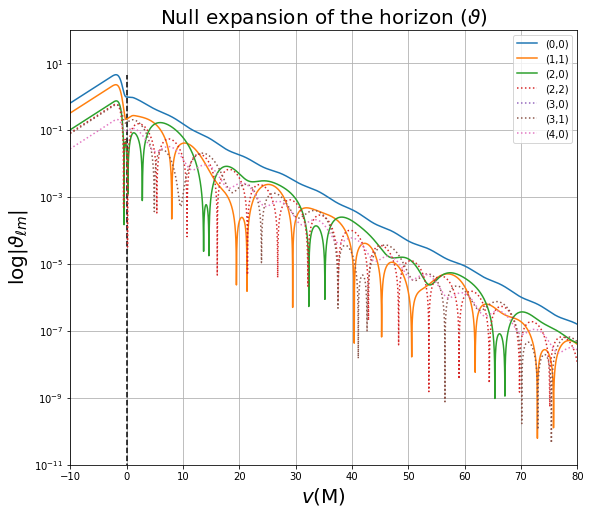

In [30]:
# Plot the different lm modes in time
plt.subplots(figsize=(20, 8))


plt.subplot(1,2,1)
#plt.semilogy(varray, np.abs(Cab[indexlm(3,0)]))
plt.semilogy(varray, np.abs(Theta[indexlm(0,0)].real),  label = '(0,0)')
plt.semilogy(varray, np.abs(Theta[indexlm(1,1)].real),  label = '(1,1)')
plt.semilogy(varray, np.abs(Theta[indexlm(2,0)].real),  label = '(2,0)')
plt.semilogy(varray, np.abs(Theta[indexlm(2,2)].real),  label = '(2,2)',  ls= 'dotted')
plt.semilogy(varray, np.abs(Theta[indexlm(3,0)].real),  label = '(3,0)',  ls = 'dotted')
plt.semilogy(varray, np.abs(Theta[indexlm(3,1)].real),  label = '(3,1)',  ls = 'dotted')
plt.semilogy(varray, np.abs(Theta[indexlm(4,0)].real),  label = '(4,0)',  ls = 'dotted')
plt.title(r"Null expansion of the horizon $(\vartheta)$", fontsize=20)
plt.ylabel(r"$\log|\vartheta_{\ell m}|$", fontsize=20)
plt.xlabel(r"$v(\mathrm{M})$", fontsize=20)
plt.grid("on")
plt.legend()
plt.xlim([-10,80])
plt.ylim([1e-11,1e2])
plt.vlines(0,0, max(np.abs(Theta[indexlm(0,0)].real)),color ="black", linestyle= "dashed")

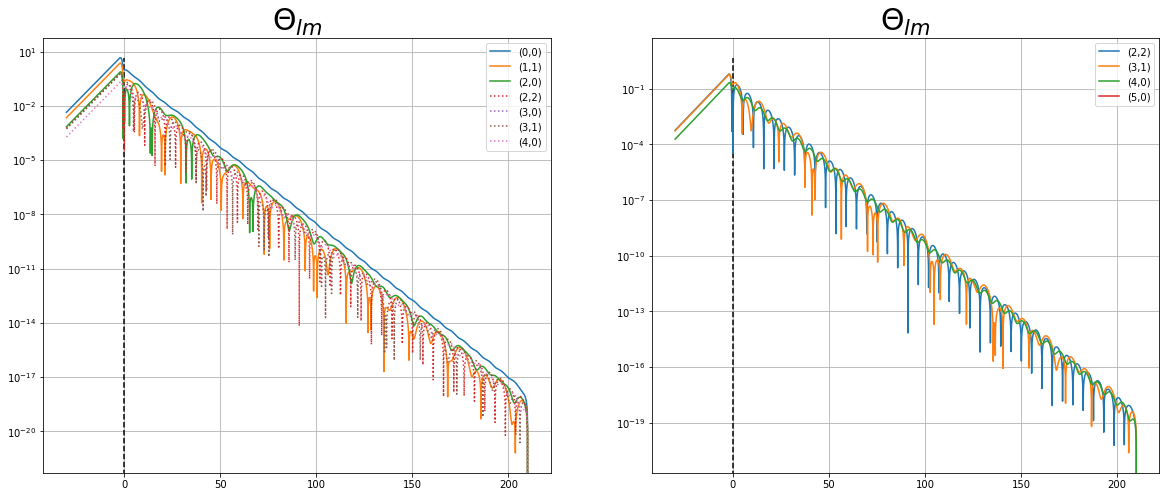

In [31]:
# Plot the different lm modes in time
plt.subplots(figsize=(20, 8))


plt.subplot(1,2,1)
#plt.semilogy(varray, np.abs(Cab[indexlm(3,0)]))
plt.semilogy(varray, np.abs(Theta[indexlm(0,0)].real), label =  '(0,0)')
plt.semilogy(varray, np.abs(Theta[indexlm(1,1)].real),  label = '(1,1)')
plt.semilogy(varray, np.abs(Theta[indexlm(2,0)].real),  label = '(2,0)')
plt.semilogy(varray, np.abs(Theta[indexlm(2,2)].real), label =  '(2,2)', ls= 'dotted')
plt.semilogy(varray, np.abs(Theta[indexlm(3,0)].real), label =  '(3,0)', ls = 'dotted')
plt.semilogy(varray, np.abs(Theta[indexlm(3,1)].real), label =  '(3,1)', ls = 'dotted')
plt.semilogy(varray, np.abs(Theta[indexlm(4,0)].real),  label = '(4,0)', ls = 'dotted')
plt.title(r"$\Theta_{lm}$", fontsize=30)
plt.grid("on")
plt.legend()
plt.vlines(0,0, max(np.abs(Theta[indexlm(0,0)].real)),color ="black", linestyle= "dashed")


plt.subplot(1,2,2)
plt.semilogy(varray, np.abs(Theta[indexlm(2,2)].real), label =  '(2,2)')
plt.semilogy(varray, np.abs(Theta[indexlm(3,1)].real), label =  '(3,1)')
#plt.semilogy(varray, np.abs(Theta[indexlm(4,1)]), label =  '(4,1)')
plt.semilogy(varray, np.abs(Theta[indexlm(4,0)].real),  label = '(4,0)')
plt.semilogy(varray, np.abs(Theta[indexlm(5,0)].real),  label = '(5,0)')
plt.title(r"$\Theta_{lm}$", fontsize=30)
plt.grid("on")
plt.legend()
plt.vlines(0,0, max(np.abs(Theta[indexlm(0,0)])),color ="black", linestyle= "dashed")

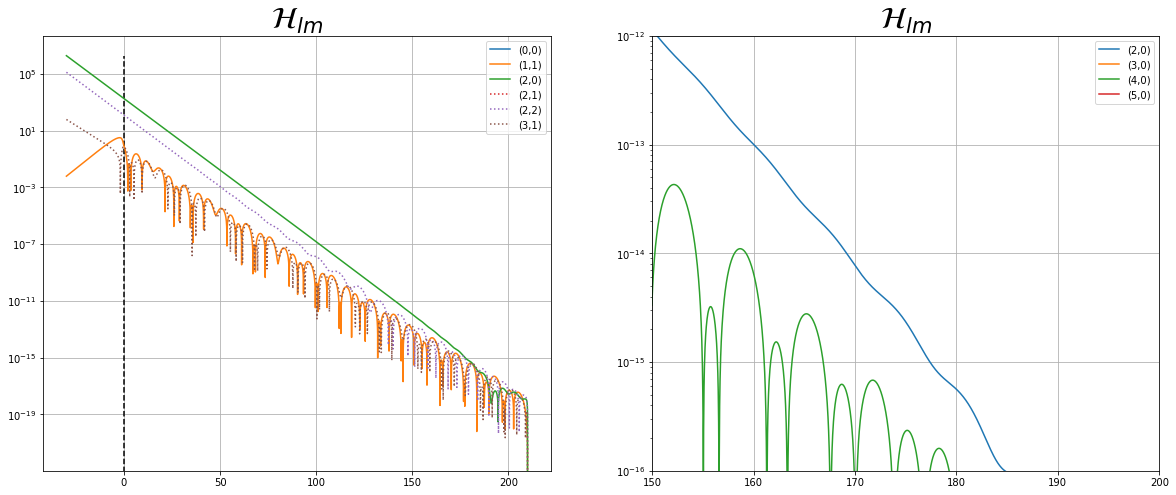

In [32]:
# Plot the different lm modes in time
plt.subplots(figsize=(20, 8))


plt.subplot(1,2,1)
#plt.semilogy(varray, np.abs(Cab[indexlm(3,0)]))
plt.semilogy(varray, np.abs(Haji[indexlm(0,0)].real), label =  '(0,0)')
plt.semilogy(varray, np.abs(Haji[indexlm(1,1)].real),  label = '(1,1)')
plt.semilogy(varray, np.abs(Haji[indexlm(2,0)].real),  label = '(2,0)')
plt.semilogy(varray, np.abs(Haji[indexlm(2,1)].real), label =  '(2,1)',  ls = 'dotted')
plt.semilogy(varray, np.abs(Haji[indexlm(2,2)].real), label =  '(2,2)',  ls = 'dotted')
plt.semilogy(varray, np.abs(Haji[indexlm(3,1)].real), label =  '(3,1)',  ls = 'dotted')
#plt.semilogy(varray, np.abs(Haji[indexlm(4,0)]),  label = '(4,0)', ls = 'dotted')
plt.grid("on")
plt.legend()
plt.title(r"$\mathcal{H}_{lm}$", fontsize=30)
plt.vlines(0,0, max(np.abs(Haji[indexlm(2,0)].real)),color ="black", linestyle= "dashed")


plt.subplot(1,2,2)
#plt.semilogy(varray, np.abs(Cab[indexlm(3,0)]))
plt.semilogy(varray, np.abs(Haji[indexlm(2,0)].real), label =  '(2,0)')
plt.semilogy(varray, np.abs(Haji[indexlm(3,0)].real), label =  '(3,0)')
plt.semilogy(varray, np.abs(Haji[indexlm(4,0)].real),  label = '(4,0)')
plt.semilogy(varray, np.abs(Haji[indexlm(5,0)].real),  label = '(5,0)')
plt.grid("on")
plt.legend()
plt.title(r"$\mathcal{H}_{lm}$", fontsize=30)
plt.ylim([1e-16, 1e-12])
plt.xlim([150, 200])
plt.vlines(0,0, max(np.abs(Haji[indexlm(4,0)].real)),color ="black", linestyle= "dashed")

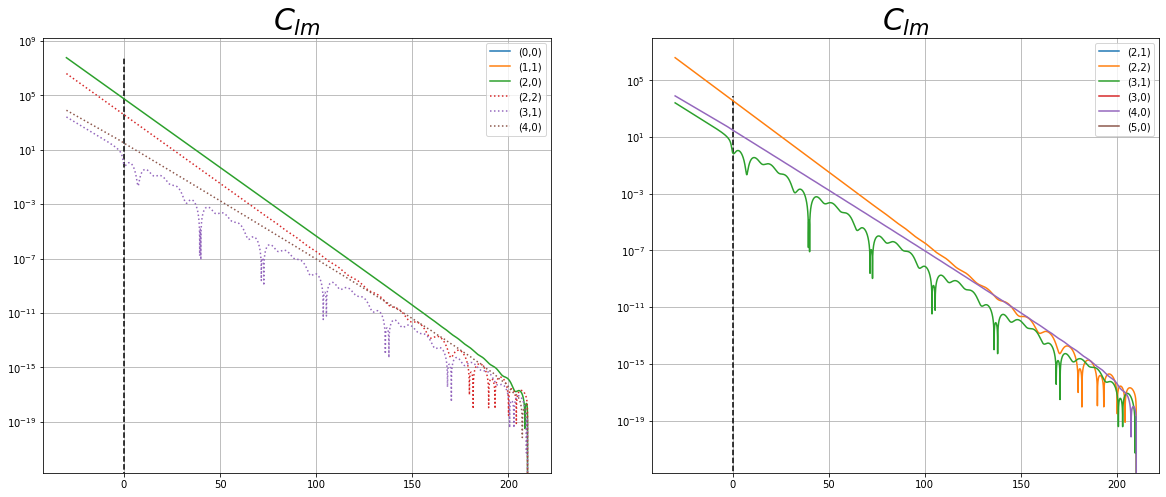

In [33]:
# Plot the different lm modes in time
plt.subplots(figsize=(20, 8))


plt.subplot(1,2,1)
#plt.semilogy(varray, np.abs(Cab[indexlm(3,0)]))
plt.semilogy(varray, np.abs(Cab[indexlm(0,0)].real), label =  '(0,0)')
plt.semilogy(varray, np.abs(Cab[indexlm(1,0)].real),  label = '(1,1)')
plt.semilogy(varray, np.abs(Cab[indexlm(2,0)].real),  label = '(2,0)')
#plt.semilogy(varray, np.abs(Cab[indexlm(2,1)]),  label = '(2,1)', ls = 'dotted')
plt.semilogy(varray, np.abs(Cab[indexlm(2,2)].real),  label = '(2,2)', ls = 'dotted')
plt.semilogy(varray, np.abs(Cab[indexlm(3,1)].real), label =  '(3,1)', ls = 'dotted')
plt.semilogy(varray, np.abs(Cab[indexlm(4,0)].real),  label = '(4,0)', ls = 'dotted')
plt.title(r"$C_{lm}$", fontsize=30)
plt.grid("on")
plt.legend()
plt.vlines(0,0, max(np.abs(Cab[indexlm(2,0)])),color ="black", linestyle= "dashed")


plt.subplot(1,2,2)
#plt.semilogy(varray, np.abs(Cab[indexlm(3,0)]))
plt.semilogy(varray, np.abs(Cab[indexlm(2,1)].real), label = '(2,1)')
plt.semilogy(varray, np.abs(Cab[indexlm(2,2)].real), label = '(2,2)')
plt.semilogy(varray, np.abs(Cab[indexlm(3,1)].real), label = '(3,1)')
plt.semilogy(varray, np.abs(Cab[indexlm(3,0)].real), label = '(3,0)')
plt.semilogy(varray, np.abs(Cab[indexlm(4,0)].real), label = '(4,0)')
plt.semilogy(varray, np.abs(Cab[indexlm(5,0)].real), label = '(5,0)')

plt.title(r"$C_{lm}$", fontsize=30)
plt.grid("on")
plt.legend()
plt.vlines(0,0, max(np.abs(Cab[indexlm(4,0)])),color ="black", linestyle= "dashed")

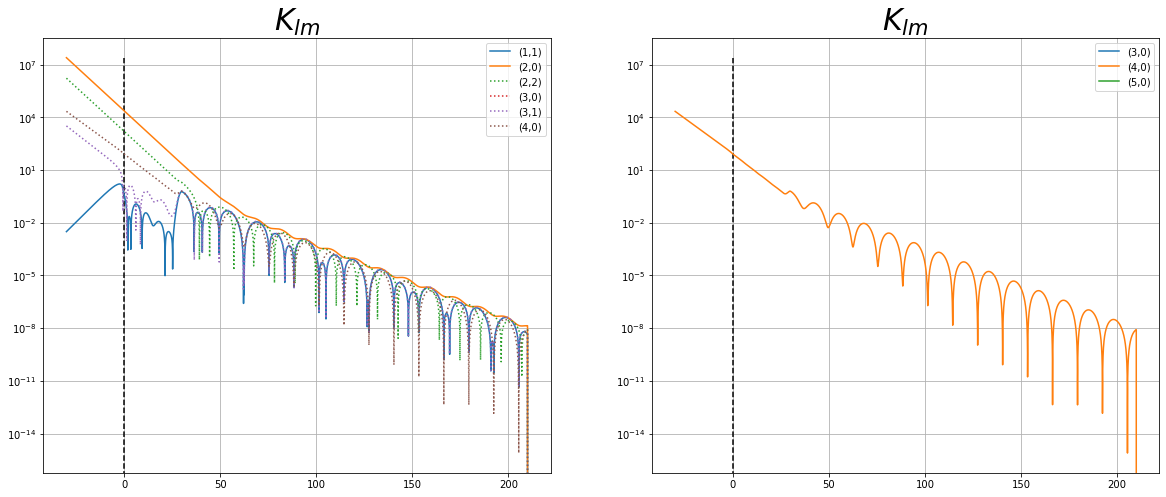

In [34]:
# Plot the different lm modes in time
plt.subplots(figsize=(20, 8))


plt.subplot(1,2,1)
#plt.semilogy(varray, np.abs(Cab[indexlm(3,0)]))
#plt.semilogy(varray, np.abs(Knaf[indexlm(0,0)]),  label =  '(0,0)')
plt.semilogy(varray, np.abs(Knaf[indexlm(1,1)].real),  label = '(1,1)')
plt.semilogy(varray, np.abs(Knaf[indexlm(2,0)].real),  label = '(2,0)')
plt.semilogy(varray, np.abs(Knaf[indexlm(2,2)].real),  label = '(2,2)', ls = 'dotted')
plt.semilogy(varray, np.abs(Knaf[indexlm(3,0)].real),  label = '(3,0)', ls = 'dotted')
plt.semilogy(varray, np.abs(Knaf[indexlm(3,1)].real), label =  '(3,1)', ls = 'dotted')
plt.semilogy(varray, np.abs(Knaf[indexlm(4,0)].real),  label = '(4,0)', ls = 'dotted')
plt.grid("on")
plt.title(r"$K_{lm}$", fontsize=30)
plt.legend()
plt.vlines(0,0, max(np.abs(Knaf[indexlm(2,0)])),color ="black", linestyle= "dashed")


plt.subplot(1,2,2)
#plt.semilogy(varray, np.abs(Cab[indexlm(3,0)]))
plt.semilogy(varray, np.abs(Knaf[indexlm(3,0)].real), label =  '(3,0)')
plt.semilogy(varray, np.abs(Knaf[indexlm(4,0)].real),  label = '(4,0)')
plt.semilogy(varray, np.abs(Knaf[indexlm(5,0)].real),  label = '(5,0)')
plt.title(r"$K_{lm}$", fontsize=30)
plt.grid("on")
plt.legend()
plt.vlines(0,0, max(np.abs(Knaf[indexlm(2,0)])),color ="black", linestyle= "dashed")

## Embedding plots

First, obtain the value of the function over the sphere. Evaluating and resumming the harmonics on a grid of angles.

In [35]:
# Function over the sphere (single time)
def S_at_v(var_time_at_V, s, N, theta, phi):
    to_return = 0
    for lm in lm_modes(s,N):
        l, m = lm
        to_add = var_time_at_V[indexlm(l,m)] * yslm_no_zero(float(s), float(l), float(m), theta, phi) #np.outer() 
        to_return +=  to_add
        # if isinstance(to_add, float):
        #     to_return +=  to_add
        # else:    
        #     print("NaN")
    return to_return

In [36]:
# Create a grid of theta and phi values
gridN = 100
theta = np.linspace(1e-20, np.pi, gridN )   # Polar angle
phi = np.linspace(1e-20, 2 * np.pi, gridN ) # Azimuthal angle

# theta = np.linspace(np.pi/gridN , np.pi, gridN )   # Polar angle
# phi = np.linspace(2 * np.pi / gridN , 2 * np.pi, gridN ) # Azimuthal angle
theta_grid, phi_grid = np.meshgrid(theta, phi, indexing = "ij") ## change below plots

# Compute the metric function values
Cscalar_at_v = S_at_v(Cab[:,0], 2, N, theta_grid, phi_grid) # C(theta, phi) at time 0.
Theta_at_v = S_at_v(Theta[:,0], 0, N, theta_grid, phi_grid) # Theta(theta, phi) at time 0.
# Cscalar_at_v = np.zeros((len(theta), len(phi)), dtype=np.cdouble)
# for ii in range(len(theta)):
#     for jj in range(len(phi)):
#         Cscalar_at_v[ii,jj] = S_at_v_at_point(Cab[:,0], 2, 10, theta_grid[ii,jj], phi_grid[ii,jj])


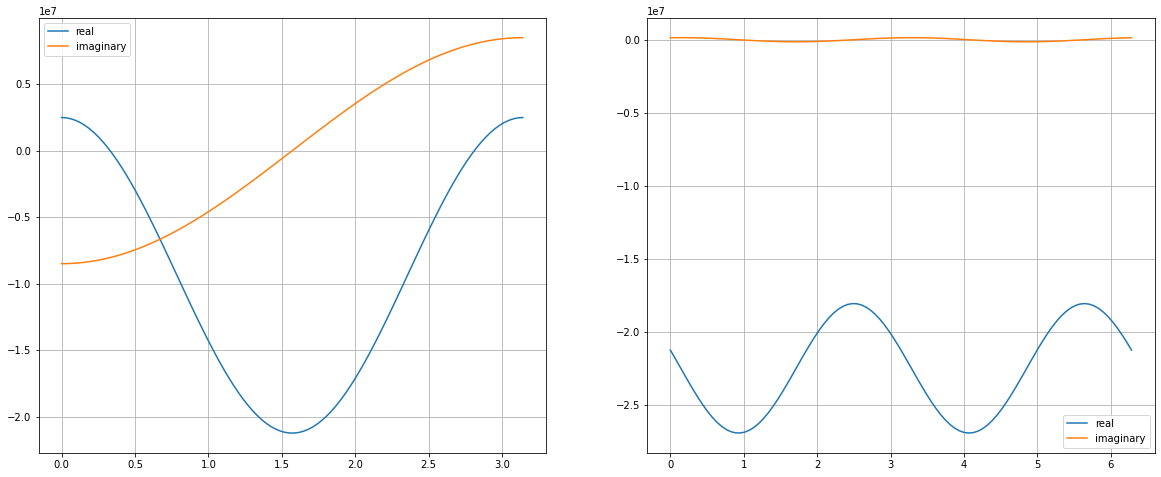

In [37]:
# Plot the different lm modes in time
plt.subplots(figsize=(20, 8))

plt.subplot(1,2,1)

plt.plot(theta, np.real(Cscalar_at_v[::,0]), label = 'real')
plt.plot(theta, np.imag(Cscalar_at_v[::,0]), label = 'imaginary')
#plt.plot(theta, np.imag(metric_values[::,0]))
plt.legend()
plt.grid('on')

plt.subplot(1,2,2)

plt.plot(phi, np.real(Cscalar_at_v[50,::]), label = 'real')
plt.plot(phi, np.imag(Cscalar_at_v[50,::]), label = 'imaginary')
plt.grid('on')
plt.legend()

In [38]:
# Projectors to the spherical coordinates
def qA(theta): return np.array([1, 1j*np.sin(theta)])
def qAbar(theta): return np.array([1, -1j*np.sin(theta)])

In [39]:
# Reconstruct the spherical components of the metric
def qAB_at_v(C_at_V, theta, phi, epsilon=1e-10):
    
    omegaAB_at_v = np.array([[1, 0], [0, np.sin(theta)**2]])  # Identity matrix for the spherical coordinates
    CAB_at_v = 1/2 * (C_at_V * np.outer(qAbar(theta),qAbar(theta)) + np.conj(C_at_V) * np.outer(qA(theta),qA(theta)))

    if (CAB_at_v.imag == np.array([[0.0, 0.0], [0.0, 0.0]])).any() == False:
        print("Imaginary part is not zero")
       
    return omegaAB_at_v + CAB_at_v.real * epsilon 

In [40]:
from matplotlib.ticker import FormatStrFormatter

In [41]:
def plot_deformed_sphere(C_time_at_V, Theta_time_at_v , time, N, grid_N=100, epsilon=1e-10, color_sensitivity = 1e-18):
    # Create a grid of theta and phi values
    theta = np.linspace(1e-20, np.pi, grid_N)   # Polar angle
    phi = np.linspace(2*1e-20, 2 * np.pi, grid_N) # Azimuthal angle
    theta_grid, phi_grid = np.meshgrid(theta, phi, indexing = "ij") 
    # Compute the metric function values
    Cscalar_at_v = S_at_v(C_time_at_V, 2, N, theta_grid, phi_grid)
    Theta_at_v =   S_at_v(Theta_time_at_v, 0, N, theta_grid, phi_grid) 
    
    # Initialize arrays for the scaled radius and colors
    R_scaled = np.zeros_like(theta_grid)
    Colors = np.zeros_like(theta_grid)
    R_base = 1  

    for ii in range(0,len(theta)):
        for jj in range(0,len(phi)):
            metric_matrix = qAB_at_v(Cscalar_at_v[ii,jj], theta[ii], phi[jj], epsilon=epsilon) #np.array([[1,0],[0,1]])# qAB_at_v(Cscalar_at_v[ii,jj], theta[ii], phi[jj], epsilon=1e-5) #np.array([[1,0],[0,1]])#
            metric_det = np.linalg.det(metric_matrix)
            #Colors[ii, jj] = metric_det
            if metric_det < 0:
                print(f"Negative determinant at theta={theta[ii]}, phi={phi[jj]}: {metric_det}")
            R_scaled[ii, jj] = np.sqrt(metric_det/np.sin(theta[ii])**2) * R_base
            Colors[ii, jj] = max([np.real(Theta_at_v)[ii,jj], color_sensitivity]) #Set some sensitvity for colors
            #Colors[ii, jj] = max([np.sqrt(metric_det),color_sensitivity])

    # Create a 3D plot
    X = R_scaled * np.sin(theta_grid) * np.cos(phi_grid)
    Y = R_scaled * np.sin(theta_grid) * np.sin(phi_grid)
    Z = R_scaled * np.cos(theta_grid)

    ## Rotate
    
    alpha = np.pi#12*np.pi/10 # * np.ones_like(theta_grid)
    Xr = X * np.cos(alpha) - Y * np.sin(alpha)   #rotated
    Yr = Y * np.cos(alpha) + X * np.sin(alpha)
    Zr = Z

    cmap = cm.viridis
    norm = mcolors.Normalize(vmin=Colors.min(), vmax=Colors.max())

    # --- Plotting ---
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(Xr, Yr, Zr, facecolors = cmap(norm(Colors)), rcount = 50, ccount = 100, shade = False)

    ax.set_xlim3d([-1.0, 1.0])
    ax.set_ylim3d([-1.0, 1.0])
    ax.set_zlim3d([-1.0, 1.0])
    ax.set_xticks(np.arange(-1,1,0.5))
    ax.set_yticks(np.arange(-1,1,0.5))
    ax.set_zticks(np.arange(-1,1,0.5))
    ax.set_box_aspect((1,1,1))  # Aspect ratio is 1:1:1
    # ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # # make the grid lines transparent
    # ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    # ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    # ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Perturbed horizon surface at $v=${:.0f}'.format(time) + r'$\mathrm{M}$', fontsize=16)
    # Add a color bar to explain the coloring
    m = cm.ScalarMappable(cmap=cmap, norm=norm)
    m.set_array(Colors) # Important: tell the ScalarMappable what data range it represents
    cbar = fig.colorbar(m, ax=ax, shrink=0.5, aspect=20, orientation='horizontal') #
    cbar.set_label(r'$\vartheta$', size=25)
    # Set fixed ticks (optional)
    cbar.set_ticks(np.linspace((np.real(Theta_at_v)).min(), (np.real(Theta_at_v)).max(), 5))  # Choose number of ticks
    # Set format to limit digits
    cbar.ax.xaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    plt.show()
    return fig, ax

### Combined plots

In [42]:
index_list = [0, 1000, 4500, 9000, 10500,  12000] # 10750, 11500,

Color range: 2.3399967699945984e-05 0.0029502507809513008
Color range: 0.0034728631291559876 0.4378560385343278
Color range: 6.249236988727858e-08 1.0592463792466378e-05
Color range: 1.1183454831340077e-15 1.4243932291327263e-13
Color range: 1e-16 3.4493530122238987e-16
Color range: 1e-16 1e-16


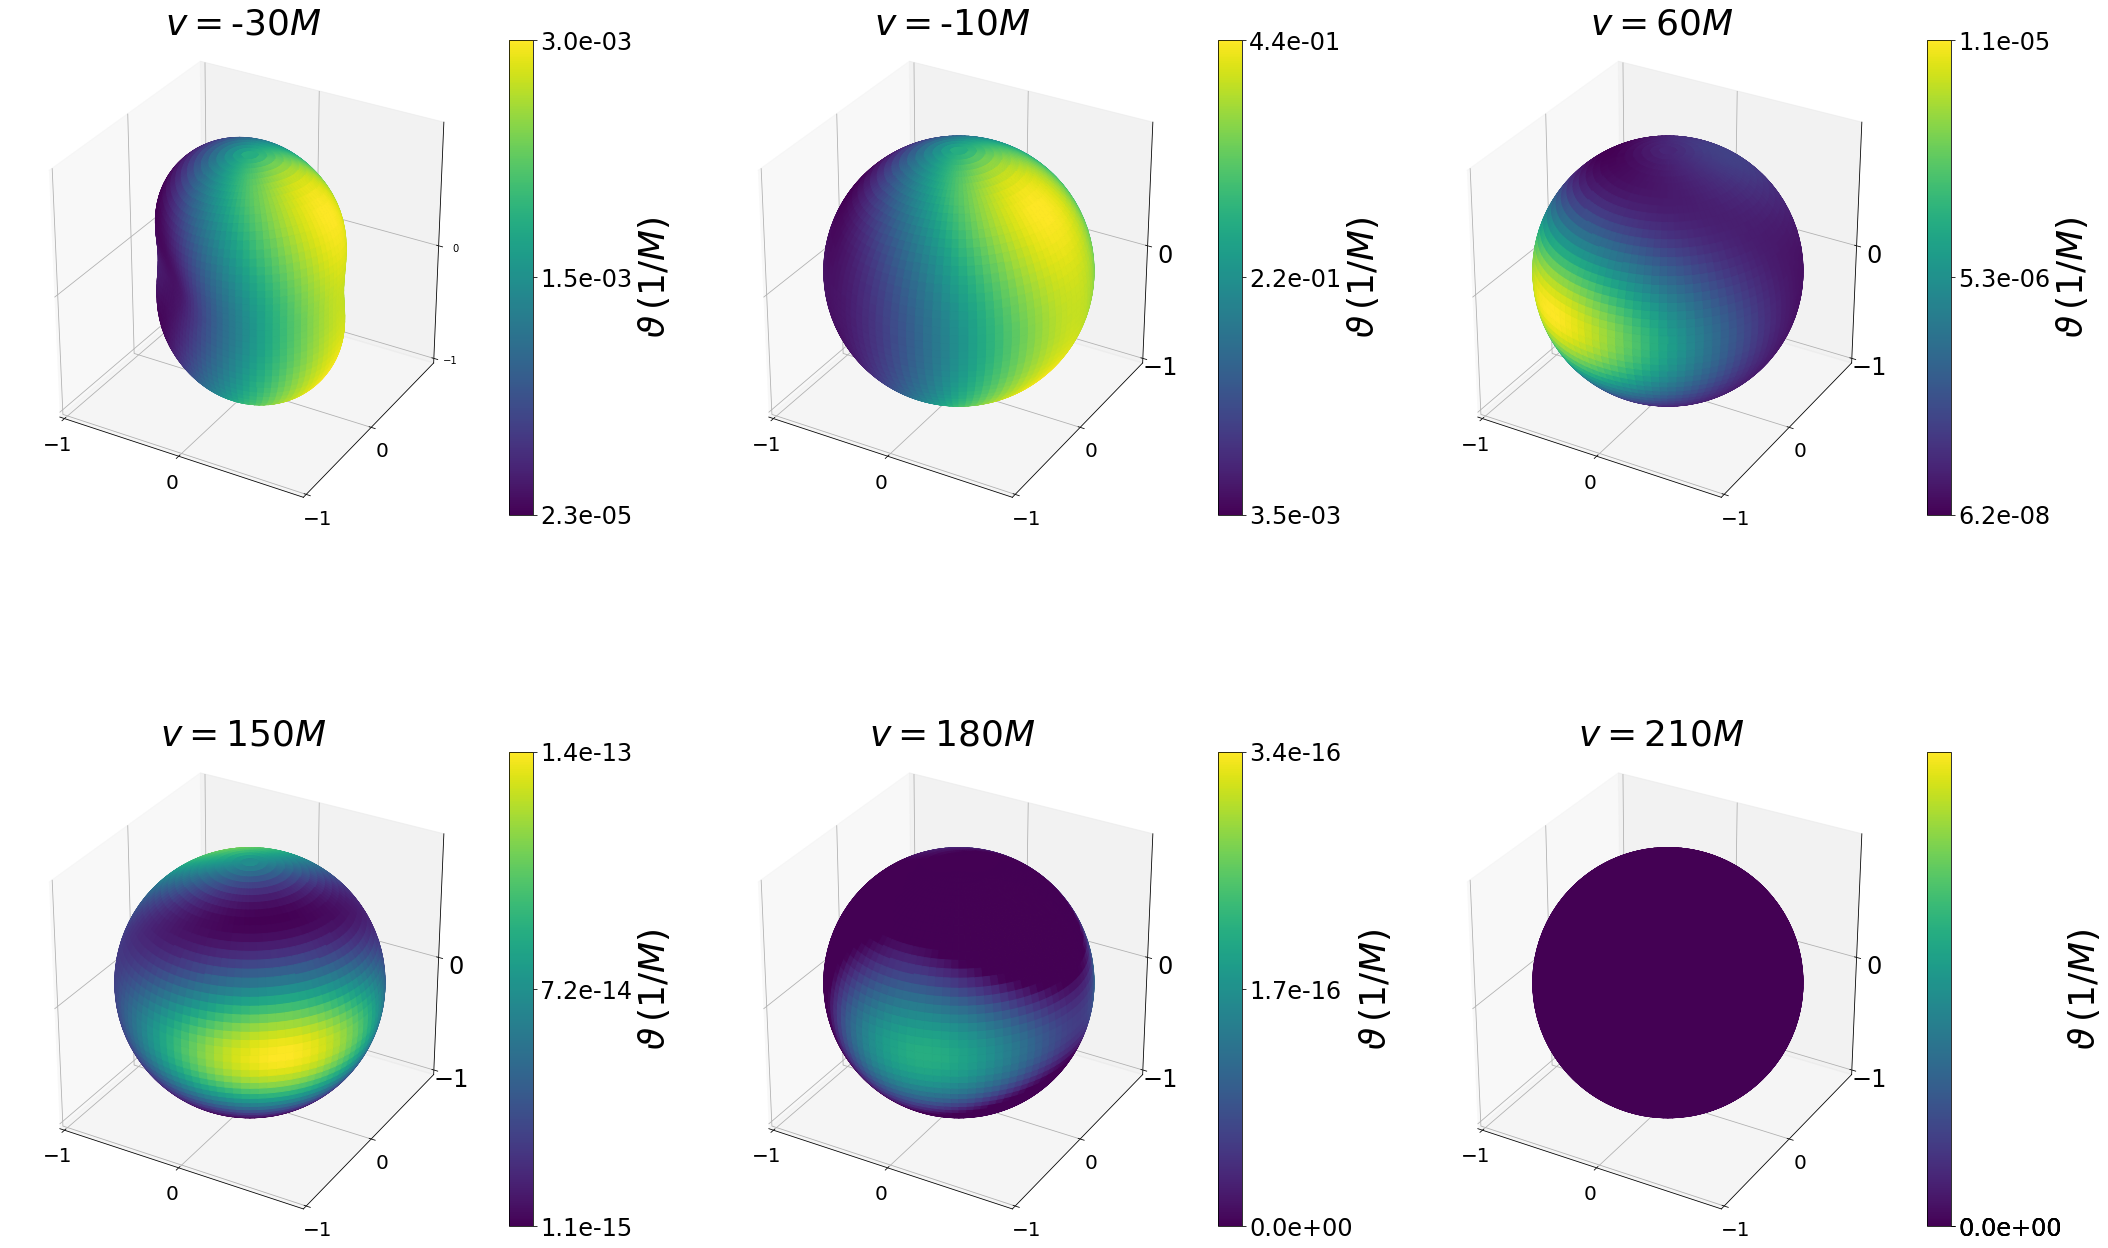

In [43]:
Nn=5
grid_N=100 
epsilon=3*1e-8
color_sensitivity=1e-16
fig = plt.figure(figsize=(36, 24))

for nn, vi in enumerate(index_list):
    C_time_at_V = Cab[:,vi]
    Theta_time_at_v = Theta[:,vi]
    time = varray[vi]
    # Create a grid of theta and phi values
    theta = np.linspace(1e-20, np.pi, grid_N)   # Polar angle
    phi = np.linspace(2*1e-20, 2 * np.pi, grid_N) # Azimuthal angle
    theta_grid, phi_grid = np.meshgrid(theta, phi, indexing = "ij") 
    # Compute the metric function values
    Cscalar_at_v = S_at_v(C_time_at_V, 2, Nn, theta_grid, phi_grid)
    Theta_at_v =   S_at_v(Theta_time_at_v, 0, Nn, theta_grid, phi_grid) 

    # Initialize arrays for the scaled radius and colors
    R_scaled = np.zeros_like(theta_grid)
    Colors = np.zeros_like(theta_grid)
    R_base = 1  

    for ii in range(0,len(theta)):
        for jj in range(0,len(phi)):
            metric_matrix = qAB_at_v(Cscalar_at_v[ii,jj], theta[ii], phi[jj], epsilon=epsilon) #np.array([[1,0],[0,1]])# qAB_at_v(Cscalar_at_v[ii,jj], theta[ii], phi[jj], epsilon=1e-5) #np.array([[1,0],[0,1]])#
            metric_det = np.linalg.det(metric_matrix)
            #Colors[ii, jj] = metric_det
            if metric_det < 0:
                print(f"Negative determinant at theta={theta[ii]}, phi={phi[jj]}: {metric_det}")
            R_scaled[ii, jj] = np.sqrt(metric_det/np.sin(theta[ii])**2) * R_base
            Colors[ii, jj] = max([np.real(Theta_at_v)[ii,jj], color_sensitivity]) #Set some sensitvity for colors
            #Colors[ii, jj] = max([np.sqrt(metric_det),color_sensitivity])

    # Create a 3D plot
    X = R_scaled * np.sin(theta_grid) * np.cos(phi_grid)
    Y = R_scaled * np.sin(theta_grid) * np.sin(phi_grid)
    Z = R_scaled * np.cos(theta_grid)

    ## Rotate

    alpha = np.pi#12*np.pi/10 # * np.ones_like(theta_grid)
    Xr = X * np.cos(alpha) - Y * np.sin(alpha)   #rotated
    Yr = Y * np.cos(alpha) + X * np.sin(alpha)
    Zr = Z

    cmap = cm.viridis
    norm = mcolors.Normalize(vmin=Colors.min(), vmax=Colors.max())
    print("Color range:", Colors.min(), Colors.max())

    # --- Plotting ---
    #fig = plt.figure(figsize=(10, 8))
    #ax = fig.add_subplot(111, projection='3d')
    ax = fig.add_subplot(2, 3, nn+1, projection='3d')
    ax.plot_surface(Xr, Yr, Zr, facecolors = cmap(norm(Colors)), rcount = 50, ccount = 100, shade = False)

    ax.set_xlim3d([-1.0, 1.0])
    ax.set_ylim3d([-1.0, 1.0])
    ax.set_zlim3d([-1.0, 1.0])
    ax.set_xticks(np.arange(-1,1,1))
    ax.set_yticks(np.arange(-1,1,1))
    ax.set_zticks(np.arange(-1,1,1))
    ax.set_box_aspect((1,1,1))  # Aspect ratio is 1:1:1
    # ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # # make the grid lines transparent
    # ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    # ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    # ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    plt.rcParams['font.size'] = '24'
    # Set tick font size

    #ax.set_xlabel('X', fontsize=16)
    #ax.set_ylabel('Y', fontsize=16)
    #ax.set_zlabel('Z', fontsize=16)
    ax.set_title(r'$v= ${:.0f}'.format(time) + r'$M$', fontsize=36)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(20)
    # # Add a color bar to explain the coloring
    m = cm.ScalarMappable(cmap=cmap, norm=norm)
    m.set_array(Colors) # Important: tell the ScalarMappable what data range it represents
    
    # cbar = fig.colorbar(m, ax=ax, shrink = 0.8, aspect=20, orientation='vertical') #
    # cbar.set_label(r'$\vartheta \, (1/\mathrm{M})$', size=36)
    # # Set fixed ticks (optional)
    # cbar.set_ticks(np.linspace((max([np.real(Theta_at_v).min(), color_sensitivity])), (np.real(Theta_at_v)).max(), 3))  # Choose number of ticks
    # # Set format to limit digits

    if nn < 4:
        # Add a color bar to explain the coloring
        m = cm.ScalarMappable(cmap=cmap, norm=norm)
        m.set_array(Colors) # Important: tell the ScalarMappable what data range it represents
        cbar = fig.colorbar(m, ax=ax, shrink=0.8, aspect=20)
        cbar.set_label(r'$\vartheta \, (1/M)$', size=36)
        cbar.set_ticks(np.linspace((max([np.real(Theta_at_v).min(), color_sensitivity])), (np.real(Theta_at_v)).max(), 3))  # Choose number of ticks
    elif nn == 4:
        # Add a color bar to explain the coloring
        norm = mcolors.Normalize(vmin=0, vmax=Colors.max()) 
        m = cm.ScalarMappable(cmap=cmap, norm=norm)
        m.set_array(Colors) # Important: tell the ScalarMappable what data range it represents
        cbar = fig.colorbar(m, ax=ax, shrink=0.8, aspect=20)
        cbar.set_label(r'$\vartheta \, (1/M)$', size=36)
        cbar.set_ticks(np.linspace(0, (np.real(Theta_at_v)).max(), 3))  # Choose number of ticks    
    else:
        Colors = np.zeros_like(theta_grid)
        norm = mcolors.Normalize(vmin=Colors.min(), vmax=1e-16) #
        m = cm.ScalarMappable(cmap=cmap, norm=norm)
        m.set_array(Colors) # Important: tell the ScalarMappable what data range it represents
        cbar = fig.colorbar(m, ax=ax, shrink=0.8, aspect=20)
        cbar.set_label(r'$\vartheta \, (1/M)$', size=36)
        cbar.set_ticks([0.0, 0.0, 0.0])  # Choose number of ticks
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
plt.show()


#plt.savefig('embedding_plots-newer.png', bbox_inches='tight', dpi = 300)

## Hajicek field

In [44]:
# Reconstruct the Hajicek field on the sphere 
# Reconstruct the spherical components of the metric
def HA_at_v(H_at_V, theta, phi, epsilon=1e-10):
    HA_at_v = 1/2 * (H_at_V * qAbar(theta) + np.conj(H_at_V) * qA(theta))
    
    if (HA_at_v.imag == np.array([0.0, 0.0])).any() == False:
        print("Imaginary part is not zero")
    return HA_at_v.real * epsilon 

In [45]:
Hscalar_at_v = S_at_v(Haji[:,0], 1, N, theta_grid, phi_grid) # C(theta, phi) at time 0.

In [46]:
HA_on_sphere = np.zeros((len(theta_grid), len(phi_grid)), dtype=np.ndarray)
Htheta = np.zeros((len(theta_grid), len(phi_grid)), dtype=np.double)
Hphi = np.zeros((len(theta_grid), len(phi_grid)), dtype=np.double)
quiver_color = np.zeros((len(theta_grid), len(phi_grid)), dtype=np.double)

Hthetadown = np.zeros((len(theta_grid), len(phi_grid)), dtype=np.double)
Hphidown = np.zeros((len(theta_grid), len(phi_grid)), dtype=np.double)

for ii in range(0,len(theta)):
    for jj in range(0,len(phi)):
        HA_on_sphere[ii,jj] = HA_at_v(Hscalar_at_v[ii,jj], theta[ii], phi[jj], epsilon=7*1e-9)
        metric_matrix = qAB_at_v(Cscalar_at_v[ii,jj], theta[ii], phi[jj], epsilon=7*1e-9)

        metric_det = np.linalg.det(metric_matrix)
        #Colors[ii, jj] = np.sqrt(metric_det /np.sin(theta[ii])**2)
        if metric_det < 0:
            print(f"Negative determinant at theta={theta[ii]}, phi={phi[jj]}: {metric_det}")

        HA_vector = HA_on_sphere[ii,jj] @ np.linalg.inv(metric_matrix)
        Htheta[ii,jj] = HA_vector[0]
        Hphi[ii,jj] = HA_vector[1]

        Hthetadown[ii,jj] = HA_on_sphere[ii,jj][0]
        Hphidown[ii,jj] = HA_on_sphere[ii,jj][1]
        quiver_color[ii,jj] = np.linalg.norm(HA_vector)
        # Color with respect to the magnitude of phi component
        #quiver_color[ii,jj] = np.abs(HA_vector[0])

### Embedding

In [47]:
# Plot the reconstructed Hajicek field on the sphere

# Convert vector components to Cartesian
Hx =  Htheta * np.cos(theta_grid) * np.cos(phi_grid) - Hphi * np.sin(theta_grid) * np.sin(phi_grid)
Hy =  Htheta * np.cos(theta_grid) * np.sin(phi_grid) + Hphi * np.sin(theta_grid) * np.cos(phi_grid)
Hz = -Htheta * np.sin(theta_grid)
 
# Calculate the color based on the magnitude of the vector field
quiver_color = np.sqrt(Hx**2 + Hy**2 + Hz**2) 

In [48]:
theta_limits = (0, np.pi)
theta_index = (np.where(abs(theta-theta_limits[0]) == abs(theta-theta_limits[0]).min())[0][0], np.where(abs(theta-theta_limits[1]) == abs(theta-theta_limits[1]).min())[0][0] + 1)

phi_limits = (0, 2* np.pi)
phi_index = (np.where(abs(phi-phi_limits[0]) == abs(phi-phi_limits[0]).min())[0][0],np.where(abs(phi-phi_limits[1]) == abs(phi-phi_limits[1]).min())[0][0] + 1)

In [49]:
quiver_step = 3  # Adjust this value to control the density of arrows

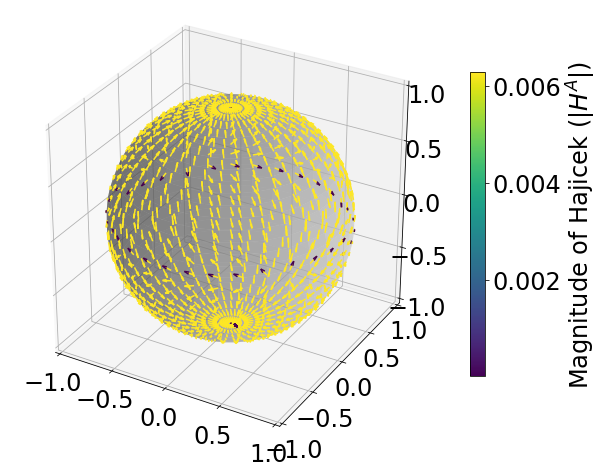

In [50]:
# X_v = 1 * np.sin(theta_grid_v) * np.cos(phi_grid_v)
# Y_v = 1 * np.sin(theta_grid_v) * np.sin(phi_grid_v)
# Z_v = 1 * np.cos(theta_grid_v)

# --- Plotting ---
fig = plt.figure(figsize=(10, 8)) # (20,16)
ax = fig.add_subplot(111, projection='3d') #cm.viridis(magnitude/magnitude.max())

xq = X[theta_index[0]:theta_index[1]:quiver_step ,phi_index[0]:phi_index[1]:quiver_step]
yq = Y[theta_index[0]:theta_index[1]:quiver_step ,phi_index[0]:phi_index[1]:quiver_step]
zq = Z[theta_index[0]:theta_index[1]:quiver_step ,phi_index[0]:phi_index[1]:quiver_step]
Hxq = Hx[theta_index[0]:theta_index[1]:quiver_step ,phi_index[0]:phi_index[1]:quiver_step]
Hyq = Hy[theta_index[0]:theta_index[1]:quiver_step ,phi_index[0]:phi_index[1]:quiver_step]
Hzq = Hz[theta_index[0]:theta_index[1]:quiver_step ,phi_index[0]:phi_index[1]:quiver_step]
colorq = quiver_color[theta_index[0]:theta_index[1]:quiver_step ,phi_index[0]:phi_index[1]:quiver_step]


cmap = cm.viridis
norm = mcolors.Normalize(vmin=colorq.min(), vmax=colorq.max())

# Flatten and normalize
colorq = (colorq.ravel() - colorq.min()) / colorq.ptp()
# Repeat for each body line and two head lines
#colorq = np.concatenate((colorq, np.repeat(colorq, 2)))
# Colormap
colorq = cmap(norm(colorq))

ax.quiver(xq, yq, zq, Hxq, Hyq, Hzq, length=0.08, normalize=True, pivot='tail',arrow_length_ratio=0.5, colors=colorq, alpha=1)
ax.plot_surface(xq, yq, zq, color='lightgray', alpha = 0.5, shade = True, rcount = 50, ccount = 100)
ax.set_xlim3d([-1.0, 1.0])
ax.set_ylim3d([-1.0, 1.0])
ax.set_zlim3d([-1.0, 1.0])
ax.set_box_aspect((1,1,1))  # Aspect ratio is 1:1:1

# Add a color bar to explain the coloring
m = cm.ScalarMappable(cmap=cmap, norm=norm)
m.set_array(colorq) # Important: tell the ScalarMappable what data range it represents
fig.colorbar(m, ax=ax, shrink=0.7, aspect=20, label='Magnitude of Hajicek ($|H^A|$)')

plt.show()

In [51]:
def plot_deformed_sphere_with_vector(C_time_at_V, Theta_time_at_v, Haji_time_at_v, time, N=10, grid_N=100, theta_limits = (0, np.pi), phi_limits = (0, 2* np.pi) ,epsilon=2.5e-11):
    # Create a grid of theta and phi values
    theta = np.linspace(1e-10, np.pi, grid_N)   # Polar angle
    phi = np.linspace(1e-10, 2 * np.pi, grid_N) # Azimuthal angle
    theta_grid, phi_grid = np.meshgrid(theta, phi, indexing = "ij") 
    # Compute the metric function values
    Cscalar_at_v = S_at_v(C_time_at_V, 2, N, theta_grid, phi_grid)
    Theta_at_v =   S_at_v(Theta_time_at_v, 0, N, theta_grid, phi_grid) 
    Hscalar_at_v = S_at_v(Haji_time_at_v, 1, N, theta_grid, phi_grid)
    
    # Initialize arrays for the scaled radius and colors for the surface
    R_scaled = np.zeros_like(theta_grid)
    Colors = np.zeros_like(theta_grid)
    R_base = 1  
    # Initialize arrays for the Hajicek field components
    Htheta = np.zeros_like(theta_grid)
    Hphi = np.zeros_like(theta_grid)

    for ii in range(0,len(theta)):
        for jj in range(0,len(phi)):
            metric_matrix = qAB_at_v(Cscalar_at_v[ii,jj], theta[ii], phi[jj], epsilon=epsilon) #np.array([[1,0],[0,1]])# qAB_at_v(Cscalar_at_v[ii,jj], theta[ii], phi[jj], epsilon=1e-5) #np.array([[1,0],[0,1]])#
            metric_det = np.linalg.det(metric_matrix)
            #Colors[ii, jj] = metric_det
            if metric_det < 0:
                print(f"Negative determinant at theta={theta[ii]}, phi={phi[jj]}: {metric_det}")
            R_scaled[ii, jj] = np.sqrt(metric_det/np.sin(theta[ii])**2) * R_base
            Colors[ii, jj] = np.real(Theta_at_v)[ii,jj] 
            # Reconstruct the Hajicek field on the sphere
            HA_on_sphere[ii,jj] = HA_at_v(Hscalar_at_v[ii,jj], theta[ii], phi[jj], epsilon=epsilon)
            HA_vector = HA_on_sphere[ii,jj] @ np.linalg.inv(metric_matrix)
            Htheta[ii,jj] = HA_vector[0]
            Hphi[ii,jj] = HA_vector[1]

    # Create a 3D plot - surface
    X = R_scaled * np.sin(theta_grid) * np.cos(phi_grid)
    Y = R_scaled * np.sin(theta_grid) * np.sin(phi_grid)
    Z = R_scaled * np.cos(theta_grid)

    cmap = cm.viridis
    norm = mcolors.Normalize(vmin=Colors.min(), vmax=Colors.max())

    # Plot the reconstructed Hajicek field on the sphere

    # Convert vector components to Cartesian
    Hx =  Htheta * np.cos(theta_grid) * np.cos(phi_grid) - Hphi * np.sin(theta_grid) * np.sin(phi_grid)
    Hy =  Htheta * np.cos(theta_grid) * np.sin(phi_grid) + Hphi * np.sin(theta_grid) * np.cos(phi_grid)
    Hz = -Htheta * np.sin(theta_grid)
    
    # Calculate the color based on the magnitude of the vector field
    quiver_color = np.sqrt(Hx**2 + Hy**2 + Hz**2) 

    # Limit the theta and phi ranges for better visualization

    theta_index = (np.where(abs(theta-theta_limits[0]) == abs(theta-theta_limits[0]).min())[0][0], np.where(abs(theta-theta_limits[1]) == abs(theta-theta_limits[1]).min())[0][0] + 1)
    phi_index = (np.where(abs(phi-phi_limits[0]) == abs(phi-phi_limits[0]).min())[0][0],np.where(abs(phi-phi_limits[1]) == abs(phi-phi_limits[1]).min())[0][0] + 1)
    xq = X[theta_index[0]:theta_index[1]:quiver_step ,phi_index[0]:phi_index[1]:quiver_step]
    yq = Y[theta_index[0]:theta_index[1]:quiver_step ,phi_index[0]:phi_index[1]:quiver_step]
    zq = Z[theta_index[0]:theta_index[1]:quiver_step ,phi_index[0]:phi_index[1]:quiver_step]
    Hxq = Hx[theta_index[0]:theta_index[1]:quiver_step ,phi_index[0]:phi_index[1]:quiver_step]
    Hyq = Hy[theta_index[0]:theta_index[1]:quiver_step ,phi_index[0]:phi_index[1]:quiver_step]
    Hzq = Hz[theta_index[0]:theta_index[1]:quiver_step ,phi_index[0]:phi_index[1]:quiver_step]
    colorq = quiver_color[theta_index[0]:theta_index[1]:quiver_step ,phi_index[0]:phi_index[1]:quiver_step]


    cmapq = cm.viridis
    normq = mcolors.Normalize(vmin=colorq.min(), vmax=colorq.max())

    # Flatten and normalize
    colorq = (colorq.ravel() - colorq.min()) / (colorq.ptp()+1e-9)
    # Repeat for each body line and two head lines
    #colorq = np.concatenate((colorq, np.repeat(colorq, 2)))
    # Colormap
    colorq = cmapq(normq(colorq))

    # --- Plotting ---
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(X, Y, Z, facecolors = cmap(norm(Colors)), rcount = 50, ccount = 100, shade = False)
    ax.quiver(xq, yq, zq, Hxq, Hyq, Hzq, length=0.05, normalize=True, pivot='tail',arrow_length_ratio=0.5, colors="black", alpha=0.5) #colorq

    ax.set_xlim3d([-1.0, 1.0])
    ax.set_ylim3d([-1.0, 1.0])
    ax.set_zlim3d([-1.0, 1.0])
    ax.set_box_aspect((1,1,1))  # Aspect ratio is 1:1:1
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Perturbed horizon surface at time $v=$' + str(time) + '$M$', fontsize=16)
    #ax.set
    # Add a color bar to explain the coloring
    m = cm.ScalarMappable(cmap=cmap, norm=norm)
    m.set_array(Colors) # Important: tell the ScalarMappable what data range it represents
    fig.colorbar(m, ax=ax, shrink=0.7, aspect=20, label='Null expansion ($\Theta$)')
    plt.show()
    return fig, ax

### Vorticity

Try plotting H_theta and H_phi.

In [52]:
def vorticity_from_H(Haji_at_v, N, theta_grid, phi_grid):

    Hscalar_at_v = S_at_v(Haji_at_v, 1, N, theta_grid, phi_grid)
    
    theta = theta_grid[:,1]
    phi = phi_grid[1,:]

    dphi_dHtheta = np.gradient(Hscalar_at_v.real, phi, axis=1) #[2]-phi[1]
    dtheta_dHphi = np.gradient(Hscalar_at_v.imag * np.sin(theta_grid), theta, axis=0) #[2]-theta[1]

    vorH = (dtheta_dHphi - dphi_dHtheta) / np.sin(theta_grid) #(dtheta_dHphi - dphi_dHtheta)/2
    return vorH, Hscalar_at_v.real, Hscalar_at_v.imag * np.sin(theta_grid)

In [53]:
def plot_vorticity_from_H(Haji_time_at_v, time,theta_grid, phi_grid,  N=10, epsilon = 1e-10):


    vorH, Htheta, Hphi = vorticity_from_H(Haji_time_at_v, N, theta_grid, phi_grid)
    vorH *= epsilon
    Htheta *=  epsilon
    Hphi *= epsilon
    ### Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)


    cmap = cm.viridis
    norm = mcolors.Normalize(vmin=(vorH[1:-1,1:-1]* np.sin(theta_grid[1:-1,1:-1])).min(), vmax=(vorH[1:-1,1:-1]* np.sin(theta_grid[1:-1,1:-1])).max()) #
    #norm = mcolors.Normalize(vmin=abs(vorH).min(), vmax=abs(vorH).max()) #

    ax.pcolormesh(theta_grid[1:-1,1:-1], phi_grid[1:-1,1:-1], vorH[1:-1,1:-1]* np.sin(theta_grid[1:-1,1:-1]), cmap = cmap, norm = norm, shading = 'auto')
    #ax.pcolormesh(theta_grid, phi_grid, abs(vorH), cmap = cmap, norm = norm, shading = 'auto')
    ax.set_aspect(1)
    ax.set_xlabel(r"$\theta$",size=20)
    ax.set_ylabel("$\phi$",size=20)
    ax.set_title(r'Hájíček vorticity at $v=${:.0f}'.format(time) + '$\mathrm{M}$', fontsize=12)
    # Add a color bar to explain the coloring
    m = cm.ScalarMappable(cmap=cmap, norm=norm)
    m.set_array(Colors) # Important: tell the ScalarMappable what data range it represents
    #fig.colorbar(m, ax=ax, shrink=1, aspect=20, label='$|\omega|$')
    cbar = fig.colorbar(m, ax=ax, shrink=0.8, aspect=20)
    cbar.set_label(r'$i \omega \sin(\theta)$', size=25)
    # Set fixed ticks (optional)
    cbar.set_ticks(np.linspace((vorH[1:-1,1:-1]* np.sin(theta_grid[1:-1,1:-1])).min(), (vorH[1:-1,1:-1]* np.sin(theta_grid[1:-1,1:-1])).max(), 5))  # Choose number of ticks

    # Set format to limit digits
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    max_len = np.sqrt(Htheta**2 +  Hphi**2).max()
    print(max_len)
    ax.quiver(theta_grid[0:-1:10], phi_grid[0:-1:10], Htheta[0:-1:10]/max_len, Hphi[0:-1:10]/max_len, angles="xy", color="white", scale_units = "xy", scale=5)#scale_units="xy", scale = 5*max_len)
    # ax2.set_aspect(1)
    # ax2.set_xlabel(r"$\theta$")
    # ax2.set_ylabel("$\phi$")
    # ax2.set_title(r'Hájíček components at $v=${:.0f}'.format(time) + '$\mathrm{M}$', fontsize=12)

    
    plt.show()
    return fig, ax, vorH

In [54]:
def plot_quiver_fom_H(Haji_time_at_v, time,theta_grid, phi_grid,  N=10):


    vorH, Htheta, Hphi = vorticity_from_H(Haji_time_at_v, N, theta_grid, phi_grid)

    ### Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    #ax = fig.add_subplot(112)
    cmap = cm.viridis
    norm = mcolors.Normalize(vmin=(vorH[1:-1,1:-1]* np.sin(theta_grid[1:-1,1:-1])).min(), vmax=(vorH[1:-1,1:-1]* np.sin(theta_grid[1:-1,1:-1])).max()) #
    #norm = mcolors.Normalize(vmin=abs(vorH).min(), vmax=abs(vorH).max()) #

    ax.pcolormesh(theta_grid[1:-1,1:-1], phi_grid[1:-1,1:-1], vorH[1:-1,1:-1]* np.sin(theta_grid[1:-1,1:-1]), cmap = cmap, norm = norm, shading = 'auto')
    #ax.pcolormesh(theta_grid, phi_grid, abs(vorH), cmap = cmap, norm = norm, shading = 'auto')
    ax.set_aspect(1)
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel("$\phi$")
    ax.set_title('Hajicek vorticity at $v=$' + str(time) + '$\mathrm{M}$', fontsize=16)
    # Add a color bar to explain the coloring
    m = cm.ScalarMappable(cmap=cmap, norm=norm)
    m.set_array(Colors) # Important: tell the ScalarMappable what data range it represents
    #fig.colorbar(m, ax=ax, shrink=1, aspect=20, label='$|\omega|$')
    fig.colorbar(m, ax=ax, shrink=1, aspect=20, label='$i\omega$')
    plt.show()
    return fig, ax, vorH

In [55]:
def plot_hajicek_vorticity(Haji_time_at_v, time, N=10, grid_N=100, epsilon=1e-10):
    # Create a grid of theta and phi values

    theta = np.linspace(np.pi/grid_N, np.pi, grid_N)   # Polar angle
    phi = np.linspace( 2 * np.pi/grid_N, 2 * np.pi, grid_N) # Azimuthal angle
    theta_grid, phi_grid = np.meshgrid(theta, phi, indexing = "ij") 
    # Compute the metric function values
    #Cscalar_at_v = S_at_v(C_time_at_v, 2, N, theta_grid, phi_grid)
    Hscalar_at_v = S_at_v(Haji_time_at_v, 1, N, theta_grid, phi_grid)

    HA_on_sphere = np.zeros((len(theta_grid), len(phi_grid)), dtype=np.ndarray)
    Hthetadown = np.zeros_like(theta_grid)
    Hphidown = np.zeros_like(theta_grid)
    
    for ii in range(0,len(theta)):
        for jj in range(0,len(phi)):
            #metric_matrix = qAB_at_v(Cscalar_at_v[ii,jj], theta[ii], phi[jj], epsilon=epsilon) #np.array([[1,0],[0,1]])# qAB_at_v(Cscalar_at_v[ii,jj], theta[ii], phi[jj], epsilon=1e-5) #np.array([[1,0],[0,1]])#
            # Reconstruct the Hajicek field on the sphere
            HA_on_sphere[ii,jj] = HA_at_v(Hscalar_at_v[ii,jj], theta[ii], phi[jj], epsilon=epsilon)
            Hthetadown[ii,jj] = HA_on_sphere[ii,jj][0]
            Hphidown[ii,jj]   = HA_on_sphere[ii,jj][1]
            

    dtheta_Hphi = np.gradient(Hphidown,   np.pi/grid_N       , axis=0)
    dphi_Htheta = np.gradient(Hthetadown, 2*np.pi/grid_N,     axis=1)
    # Trimming out the edges
    H_vor_scalar =  -  (dtheta_Hphi[1:-1,1:-1] - dphi_Htheta[1:-1,1:-1])   / np.sin(theta_grid[1:-1,1:-1])
    
    # There must be a more efficient way of doing this:
    #H_vor_scalar =  (dtheta_Hphi - dphi_Htheta) / np.sin(theta_grid)**2

    # H_vorticity = np.zeros((len(theta_grid), len(phi_grid)), dtype=np.ndarray)
    # H_vor_scalar = np.zeros((len(theta_grid), len(phi_grid)), dtype=np.double)
    
    # for ii in range(0, len(theta)):
    #     for jj in range(0, len(phi)):
    #         H_vorticity[ii,jj] = np.array([[0, dtheta_Hphi[ii,jj] - dphi_Htheta[ii,jj]],[-dtheta_Hphi[ii,jj] + dphi_Htheta[ii,jj], 0]])
    #         H_vor_scalar[ii,jj] = vor_at_V(H_vorticity[ii,jj], theta[ii], phi[jj])

    ### Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    #ax = fig.add_subplot(112)
    cmap = cm.viridis
    norm = mcolors.Normalize(vmin=abs(H_vor_scalar).min(), vmax=abs(H_vor_scalar).max()) #

    ax.pcolormesh(theta_grid[1:-1,1:-1], phi_grid[1:-1,1:-1], abs(H_vor_scalar), cmap = cmap, norm = norm, shading = 'auto')
    ax.set_aspect(1)
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel("$\phi$")
    ax.set_title('Hajicek vorticity at $v=$' + str(time) + '$M$', fontsize=16)
    # Add a color bar to explain the coloring
    m = cm.ScalarMappable(cmap=cmap, norm=norm)
    m.set_array(Colors) # Important: tell the ScalarMappable what data range it represents
    fig.colorbar(m, ax=ax, shrink=1, aspect=20, label='$\omega$')
    plt.show()
    return fig, ax, H_vor_scalar

#### Vorticity combined plot

In [56]:
index_list = [0, 1000, 4500, 9000, 10500,  12000] #10750, 11500,

[-596.7529511488974, 0.0, 596.7529511488974]
901189.0119807279
[-5.757490996838897, -1.8189894035458565e-12, 5.7574909968352594]
8694.86670943959
[-5.029158246015828e-07, -3.2526065174565133e-19, 5.029158246009323e-07]
0.0007619859925246475
[-5.988643893931731e-16, -4.0389678347315804e-28, 5.988643893923653e-16]
5.926639188519499e-13
[-5.752798660811617e-19, 5.9164567891575885e-31, 5.752798660823449e-19]
5.429285177509217e-16
[0.0, 0.0, 0.0]
0.0


<ipython-input-57-8adfc28ec309>:59: RuntimeWarning: invalid value encountered in divide
  ax.quiver(theta_grid[1:-1:10], phi_grid[1:-1:10], Htheta[1:-1:10]/max_len, Hphi[1:-1:10]/max_len, angles="xy", color="white", scale_units = "xy", scale=5)#scale_units="xy", scale = 5*max_len)


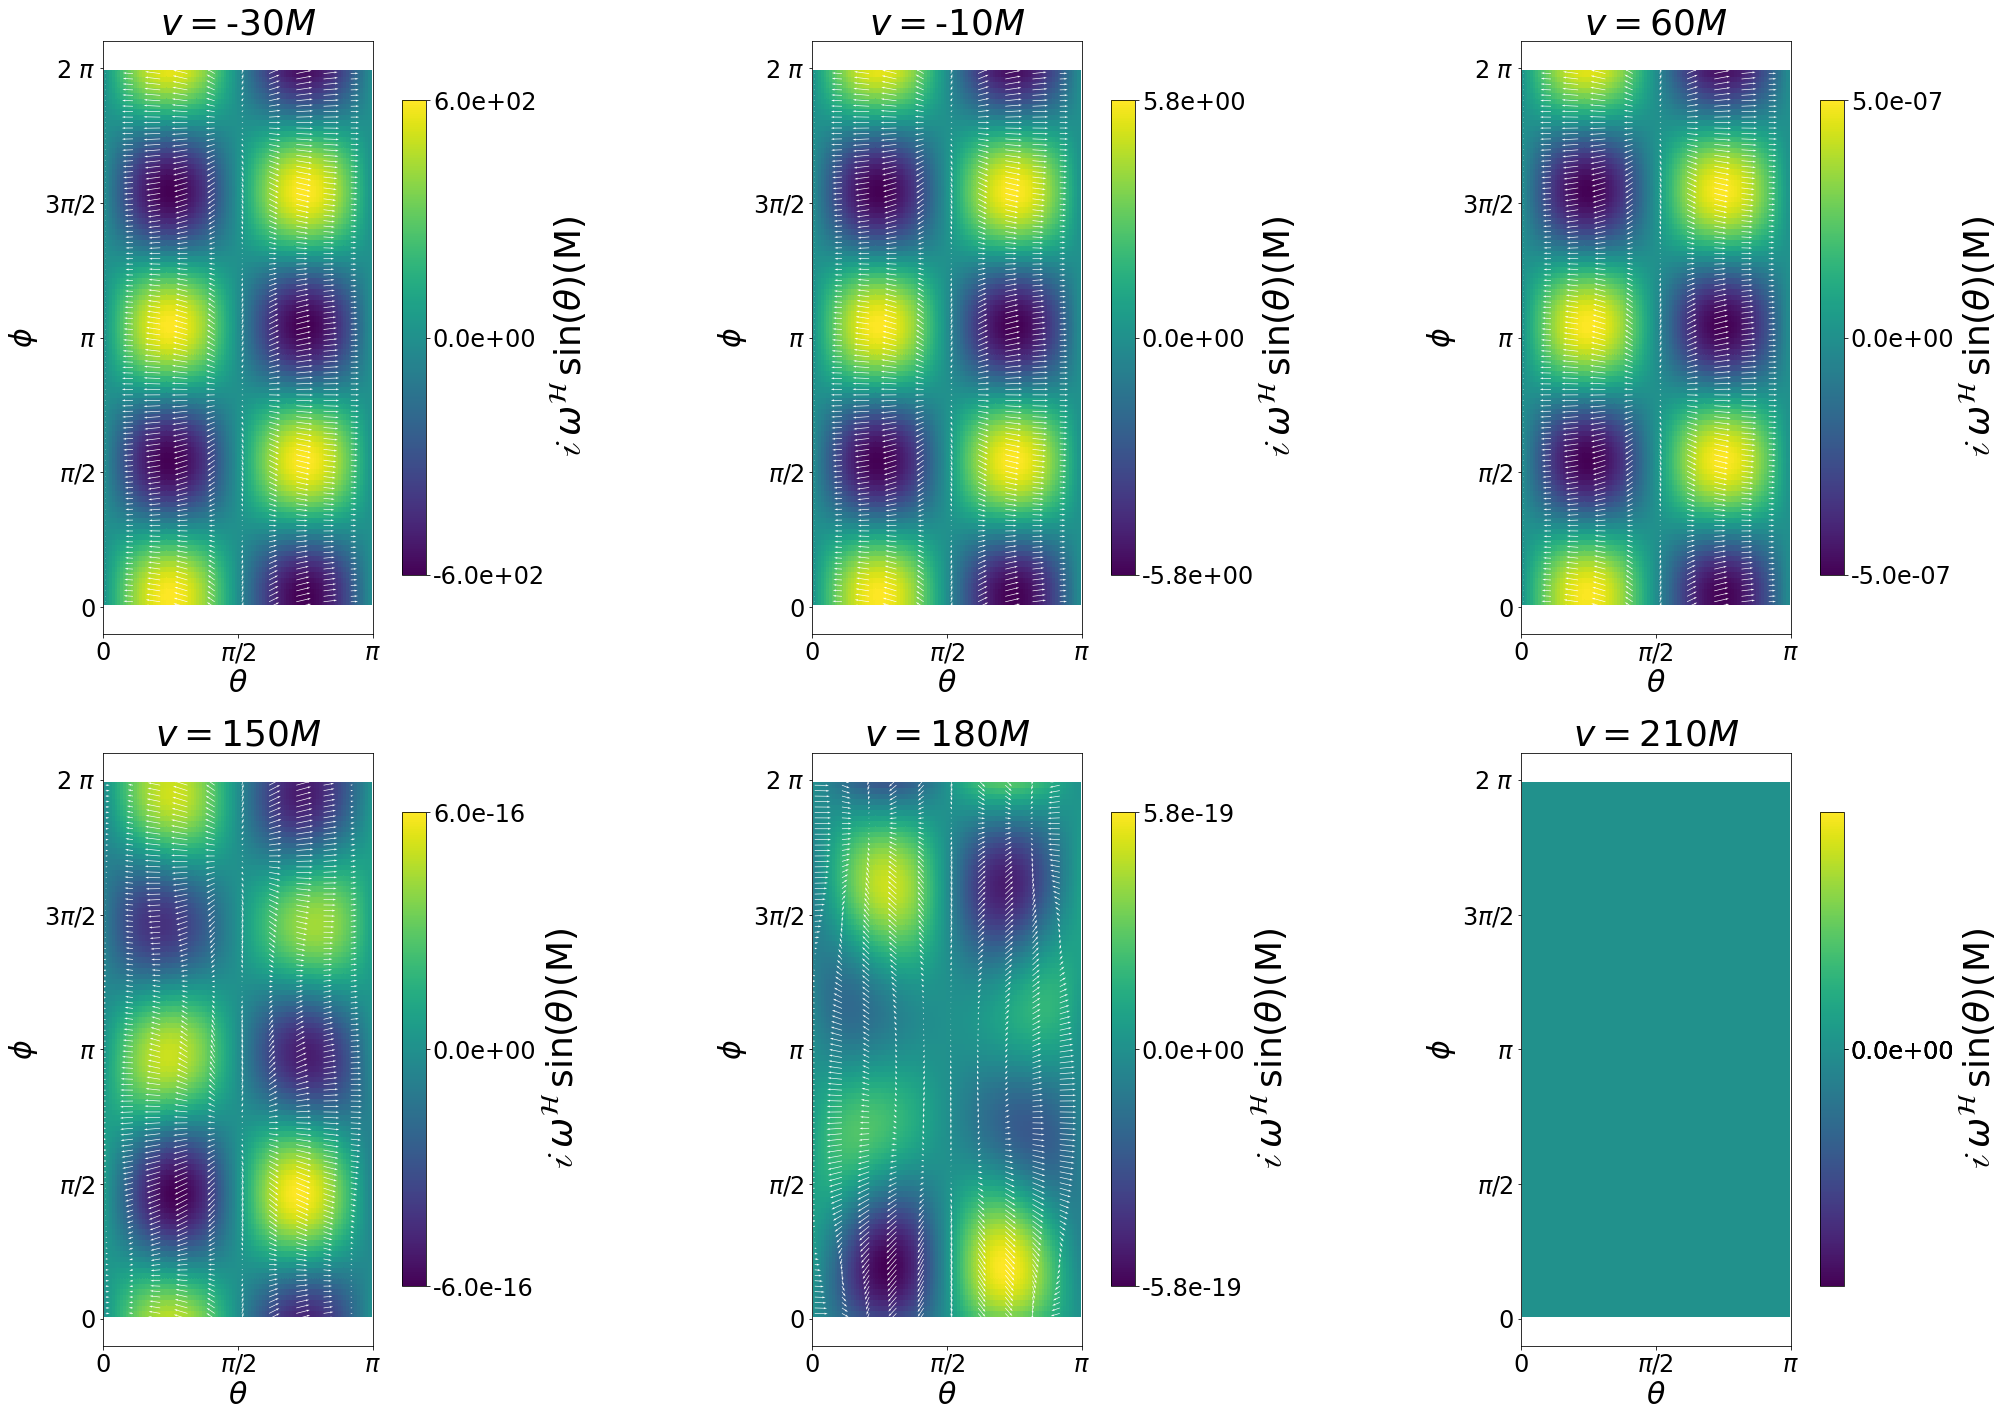

In [57]:
Nn=5
grid_N=100 
epsilon=np.sqrt(3*1e-8)
color_sensitivity=1e-16
fig = plt.figure(figsize=(36, 24))
plt.rcParams['font.size'] = '24'
for nn, vi in enumerate(index_list):
    Haji_time_at_v = Haji[:,vi]
    time = varray[vi]

    # Create a grid of theta and phi values
    
    theta = np.linspace(1e-10, np.pi, grid_N)   # Polar angle
    phi = np.linspace(2*1e-10, 2 * np.pi, grid_N) # Azimuthal angle
    theta_grid, phi_grid = np.meshgrid(theta, phi, indexing = "ij") 
    Colors = np.zeros_like(theta_grid)

    vorH, Htheta, Hphi = vorticity_from_H(Haji_time_at_v, Nn, theta_grid, phi_grid)
    #vorH *= epsilon
    #Htheta *=  epsilon
    #Hphi *= epsilon
    ### Plot

    ax = fig.add_subplot(2, 3, nn+1)


    cmap = cm.viridis
    norm = mcolors.Normalize(vmin=(vorH[1:-1,1:-1]* np.sin(theta_grid[1:-1,1:-1])).min(), vmax=(vorH[1:-1,1:-1]* np.sin(theta_grid[1:-1,1:-1])).max()) #
    #norm = mcolors.Normalize(vmin=abs(vorH).min(), vmax=abs(vorH).max()) #

    ax.pcolormesh(theta_grid[1:-1,1:-1], phi_grid[1:-1,1:-1], vorH[1:-1,1:-1]* np.sin(theta_grid[1:-1,1:-1]), cmap = cmap, norm = norm, shading= 'auto')
    #ax.pcolormesh(theta_grid, phi_grid, abs(vorH), cmap = cmap, norm = norm, shading = 'auto')
    ax.set_aspect(1)
    ax.set_xlabel(r"$\theta$",size=30)
    ax.set_ylabel("$\phi$",size=30)

    #ax.set_title(r'Hájíček vorticity at $v=${:.0f}'.format(time) + '$\mathrm{M}$', fontsize=12)
    ax.set_title(r'$v= ${:.0f}'.format(time) + r'$M$', fontsize=36)
    # Add a color bar to explain the coloring
    m = cm.ScalarMappable(cmap=cmap, norm=norm)
    m.set_array(Colors) # Important: tell the ScalarMappable what data range it represents
    #fig.colorbar(m, ax=ax, shrink=1, aspect=20, label='$|\omega|$')
    cbar = fig.colorbar(m, ax=ax, shrink=0.8, aspect=20)
    cbar.set_label(r'$ \mathscr{i} \, \omega^{\mathcal{H}} \, \sin(\theta) (\mathrm{M})$', size=36)
    # Set fixed ticks (optional)
    cbar.set_ticks(np.linspace((vorH[1:-1,1:-1]* np.sin(theta_grid[1:-1,1:-1])).min(), (vorH[1:-1,1:-1]* np.sin(theta_grid[1:-1,1:-1])).max(), 3))  # Choose number of ticks
    if nn < 6:
        # Set the second tick to zero
        cc = cbar.get_ticks().tolist()
        print(cc)
        cc[1] = 0
        cbar.set_ticks(cc)  # Set the new ticks
    #if nn == 5:
    # Set format to limit digits
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))

    max_len = np.sqrt(Htheta**2 +  Hphi**2).max()
    print(max_len)
    ax.quiver(theta_grid[1:-1:10], phi_grid[1:-1:10], Htheta[1:-1:10]/max_len, Hphi[1:-1:10]/max_len, angles="xy", color="white", scale_units = "xy", scale=5)#scale_units="xy", scale = 5*max_len)
    ax.set_xticks(np.linspace(0, np.pi, 3))
    a=ax.get_xticks().tolist()
    a=[0, r'$\pi / 2$', r'$\pi$' ]
    ax.set_xticklabels(a)

    ax.set_yticks(np.linspace(0, 2*np.pi, 5))
    b=ax.get_yticks().tolist()
    b=[0, r'$\pi / 2$', r'$\pi$', r'$3 \pi / 2$', r'2 $\pi$' ]
    ax.set_yticklabels(b)
    # ax2.set_aspect(1)
    # ax2.set_xlabel(r"$\theta$")
    # ax2.set_ylabel("$\phi$")
    # ax2.set_title(r'Hájíček components at $v=${:.0f}'.format(time) + '$\mathrm{M}$', fontsize=12)

plt.show()


#plt.savefig('vorticity_quiver-combined-new.png', bbox_inches='tight', dpi = 300)

### Angular Momentum

In [58]:
from scipy.integrate import cumtrapz

#### Long

From Hajicek:

In [59]:
H_all_array = np.zeros((100,100,len(varray)), dtype=np.cdouble)
Lphi_array = np.zeros(len(varray), dtype=np.double)
counter = 0
for vi in range(len(varray)):
    #if vi % 50 == 0:
        Hscalar_at_v = S_at_v(Haji[:,vi], 1, N, theta_grid, phi_grid)
        H_all_array[:,:,counter] = Hscalar_at_v * np.sin(theta_grid)
        #Lphi_array[counter] = np.sum(np.imag(Hscalar_at_v) * np.sin(theta_grid)) * dtheta * dphi
        counter += 1
        #Hsome = Hscalar_at_v[50,50]
        #Hsome_list.append(Hsome)


In [60]:
sin_theta_time = np.ones((100,100,len(varray)), dtype=np.double)
for vi in range(0,len(varray)):
    sin_theta_time[:,:,vi] = np.sin(theta_grid)

In [61]:
dtheta = theta_grid[:,1][2] - theta_grid[:,1][1] 
dphi = phi_grid[1,:][2] - phi_grid[1,:][1] 
Lphi_array = -np.sum(np.imag(H_all_array) *  sin_theta_time, (0,1)) * dtheta * dphi

From the source:

In [62]:
Lsource_array_tosum = np.zeros((100,100,len(varray2)), dtype=np.double)

counter = 0
for vi in range(len(varray2)):
    #if vi % 100 == 0:
        Phi_v_xA = S_at_v(Phi[:,vi], 0, N, theta_grid, phi_grid)
        dphi_Phi_v_xA = np.gradient(Phi_v_xA, dphi , axis = 1)
        
        gradPhi_v_xA = S_at_v(dPhidv[:,vi], 0, N, theta_grid, phi_grid)

        Tvphi = - dphi_Phi_v_xA * gradPhi_v_xA 
 
        Lsource_array_tosum[:,:,counter] = Tvphi.real  * np.sin(theta_grid)
        counter += 1
        #Hsome = Hscalar_at_v[50,50]
        #Hsome_list.append(Hsome)

In [63]:
dtheta = theta_grid[:,1][2] - theta_grid[:,1][1] 
dphi = phi_grid[1,:][2] - phi_grid[1,:][1]
Lsource_array = np.sum(Lsource_array_tosum, (0,1)) * dtheta * dphi

In [64]:
Lsource = np.flip(np.cumsum(np.flip(Lsource_array * (varray2[2]-varray2[1]))))

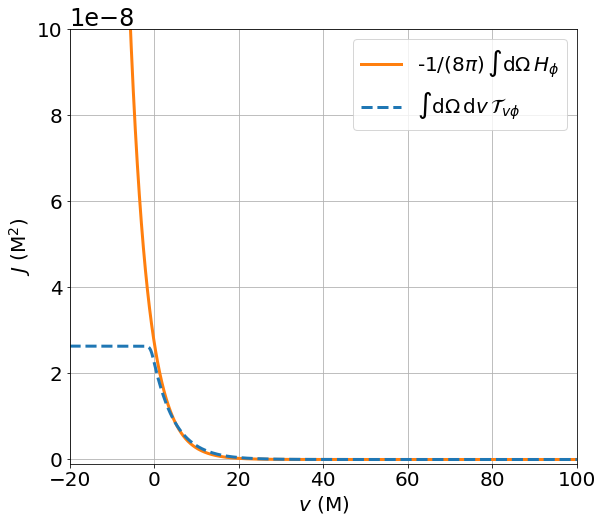

In [65]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(121)
#fig.subplots_adjust(top=0.85)

# Set titles for the figure and the subplot respectively
#fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')
#ax.set_title('Change in horizon area',fontsize = 24)

plt.rcParams['font.size'] = '20'
epsilon = np.sqrt(3e-8)
ax.plot(varray, -Lphi_array/(8*np.pi)* epsilon**2, label = r"-$1/(8\pi) \, \int  \mathrm{d}\Omega \, H_{\phi}$", linewidth = 3, color="tab:orange")
ax.plot(varray2, Lsource * epsilon**2, label = r"$\int \mathrm{d}\Omega \, \mathrm{d}v \, \mathcal{T}_{v\phi}$", ls = "--", linewidth = 3,color="tab:blue")


#ax.plot(varray2, 32*np.pi*deltaA_source * epsilon ** 2, label = r"$32\pi \, M \, \int \mathrm{d}\Omega \, \mathrm{d}v \, \mathcal{T}_{v\,v}$", ls = "--")
#ax.plot(varray,  deltaA* epsilon ** 2, label = r"$\int \mathrm{d}\Omega \, \mathrm{d}v \, \vartheta $")
ax.set_xlabel(r"$v \, \, (\mathrm{M})$",fontsize = 20)
ax.set_ylabel(r"$J\, \, (\mathrm{M}^2)$", fontsize = 20)
#ax.set_ylabel(r"$\Delta \, A (\mathrm{M}^2)$",fontsize = 20)
ax.grid('on')
ax.set_xlim([-20,100])
ax.set_ylim([-1e-9,1e-7])
ax.legend(fontsize = 20)

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

#plt.savefig('angular_momentum-shortertime-new-thicker.pdf', bbox_inches='tight', dpi = 300)

## Area

#### Area

In [66]:
Theta_all_array = np.zeros((100, 100, len(varray)), dtype=np.cdouble)
dvdArea_array = np.zeros(len(varray), dtype=np.double)
counter = 0
dtheta = theta_grid[:,1][2] - theta_grid[:,1][1] 
dphi = phi_grid[1,:][2] - phi_grid[1,:][1] 
for vi in range(len(varray)):
    #if vi % 50 == 0:
        Theta_at_v = S_at_v(Theta[:,vi], 0, N, theta_grid, phi_grid)
        Theta_all_array[:,:,counter] = Theta_at_v.real 
        dvdArea_array[counter] = np.sum(Theta_at_v.real * np.sin(theta_grid)) * dtheta * dphi
        counter += 1
        #Hsome = Hscalar_at_v[50,50]
        #Hsome_list.append(Hsome)

In [67]:
deltaA = np.flip(np.cumsum(np.flip(dvdArea_array* (varray[2]-varray[1]))))

In [68]:
dvdAsource_array_tosum = np.zeros((100,100,len(varray2)), dtype=np.double)
counter = 0
for vi in range(len(varray2)):
    #if vi % 10 == 0:
        
        gradPhi_v_xA = S_at_v(dPhidv[:,vi], 0, N, theta_grid, phi_grid)

        Tvv = gradPhi_v_xA * gradPhi_v_xA 

        #Cscalar_at_v = S_at_v(Cab[:,vi//2], 2, N, theta_grid, phi_grid)
        #metric_det_end = metric_determinant_at_v(Cscalar_at_v, theta, phi)

        dvdAsource_array_tosum[:,:,counter] = Tvv.real * np.sin(theta_grid)#* np.sqrt(metric_det_end)
        counter += 1
        #Hsome = Hscalar_at_v[50,50]
        #Hsome_list.append(Hsome)

In [69]:
dtheta = theta_grid[:,1][2] - theta_grid[:,1][1] 
dphi = phi_grid[1,:][2] - phi_grid[1,:][1]
dvdAsource_array = np.sum(dvdAsource_array_tosum, (0,1)) * dtheta * dphi

In [70]:
deltaA_source = np.flip(np.cumsum(np.flip(dvdAsource_array* (varray2[2]-varray2[1]))))

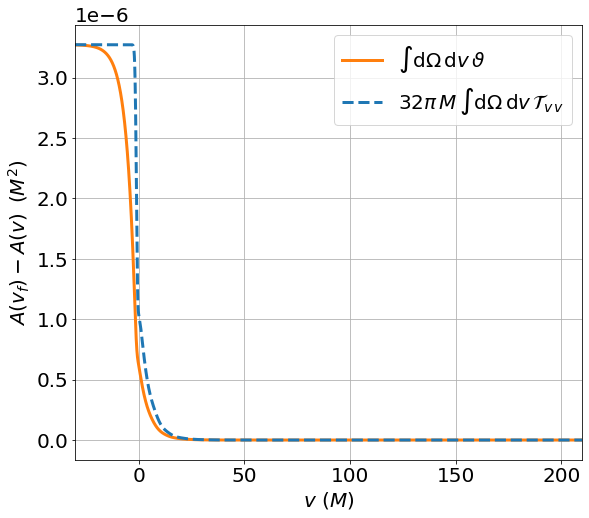

In [71]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(121)
#fig.subplots_adjust(top=0.85)

# Set titles for the figure and the subplot respectively
#fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')
#ax.set_title('Change in horizon area',fontsize = 24)

#plt.rcParams['font.size'] = '20'
# Set tick font size

ax.plot(varray,  deltaA* epsilon ** 2, label = r"$\int \mathrm{d}\Omega \, \mathrm{d}v \, \vartheta $", linewidth = 3, color = "tab:orange" )
ax.plot(varray2, 32*np.pi*deltaA_source * epsilon ** 2, label = r"$32\pi \, M \, \int \mathrm{d}\Omega \, \mathrm{d}v \, \mathcal{T}_{v\,v}$", ls = "--", linewidth = 3, color = "tab:blue")

ax.set_xlabel(r"$v \, \, (M)$",fontsize = 20)
ax.set_ylabel(r"$ A({v_f}) - A({v})  \, \, \, ( M^2 ) $",fontsize = 20)
#ax.set_ylabel(r"$\Delta \, A (\mathrm{M}^2)$",fontsize = 20)
ax.grid('on')
ax.set_xlim([-30,210])
ax.legend(fontsize = 20)

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

# plt.subplots(figsize=(20, 8))
# plt.subplot(1,2,1)
# plt.plot(varray2, 32*np.pi*deltaA_source * epsilon ** 2, label = r"$32\pi  \, \int \mathrm{d}\Omega \, \mathrm{d}v \, \mathcal{T}_{v\,v}$", ls = "--")
# plt.plot(varray,  deltaA* epsilon ** 2, label = r"$\int \mathrm{d}\Omega \, \mathrm{d}v \, \vartheta $")
# plt.grid('on')
# plt.xlabel(r"$v (\mathrm{M})$",fontsize = 20)
# plt.ylabel(r"$\Delta \, A (\mathrm{M}^2)$",fontsize = 20)
# plt.title('Change in horizon area',fontsize = 20)
# #plt.xlim([-20,100])
# plt.legend(fontsize = 20)
#plt.savefig('area_change-new-thicker.pdf', bbox_inches='tight')

### Expansion heatmap

In [72]:
def plot_expansion_heatmap(Theta_time_at_v, time, N=10, grid_N=100, color_sensitivity = 1e-16, epsilon=1e-10):
    # Create a grid of theta and phi values
    
    theta = np.linspace(1e-10, np.pi, grid_N)   # Polar angle
    phi = np.linspace(2*1e-10, 2 * np.pi, grid_N) # Azimuthal angle
    theta_grid, phi_grid = np.meshgrid(theta, phi, indexing = "ij") 
    Colors = np.zeros_like(theta_grid)
    # Compute the metric function values
    Thetascalar_at_v = S_at_v(Theta_time_at_v, 0, N, theta_grid, phi_grid) * epsilon
    #if Thetascalar_at_v.max() / Thetascalar_at_v.min() > 1e1:
    #    print("Color gap is huge")
    for ii in range(0,len(theta)):
        for jj in range(0,len(phi)):
            Colors[ii, jj] = max([np.real(Thetascalar_at_v)[ii,jj], color_sensitivity* epsilon])
        
    ### Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    cmap = cm.viridis
    norm = mcolors.Normalize(vmin=Colors.min(), vmax=Colors.max()) #

    ax.pcolormesh(theta_grid, phi_grid, Thetascalar_at_v.real, cmap = cmap, norm = norm, shading = 'auto')
    ax.set_aspect(1)
    ax.set_xlabel(r"$\theta$", size=20)
    ax.set_ylabel("$\phi$", size=20)
    ax.set_title('Temperature at $v=$' + str(time) + r'$\mathrm{M}$', fontsize=16)
    # Add a color bar to explain the coloring
    m = cm.ScalarMappable(cmap=cmap, norm=norm)
    m.set_array(Colors) # Important: tell the ScalarMappable what data range it represents
    cbar = fig.colorbar(m, ax=ax, shrink=1, aspect=20)
    cbar.set_label(r'$\vartheta$', size=25)
    # Set fixed ticks (optional)
    cbar.set_ticks(np.linspace((np.real(Thetascalar_at_v)).min(), (np.real(Thetascalar_at_v)).max(), 5))  # Choose number of ticks
    # Set format to limit digits
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))

    plt.show()
    return fig, ax

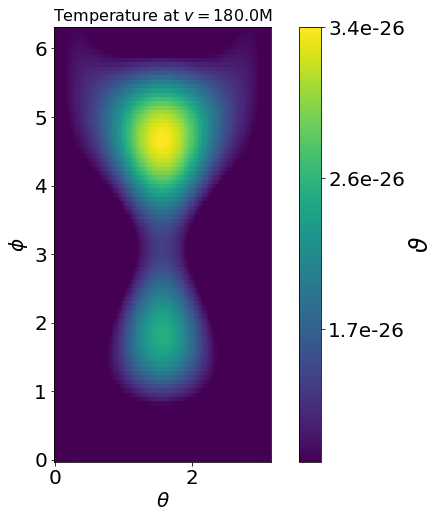

In [73]:
fig, ax = plot_expansion_heatmap(Theta[:,10500], varray[10500], N=5, grid_N=100)

### Expansion heatmap combined plot

In [74]:
index_list = [0, 1000, 4500, 9000, 10500,  12000] #10750, 11500,

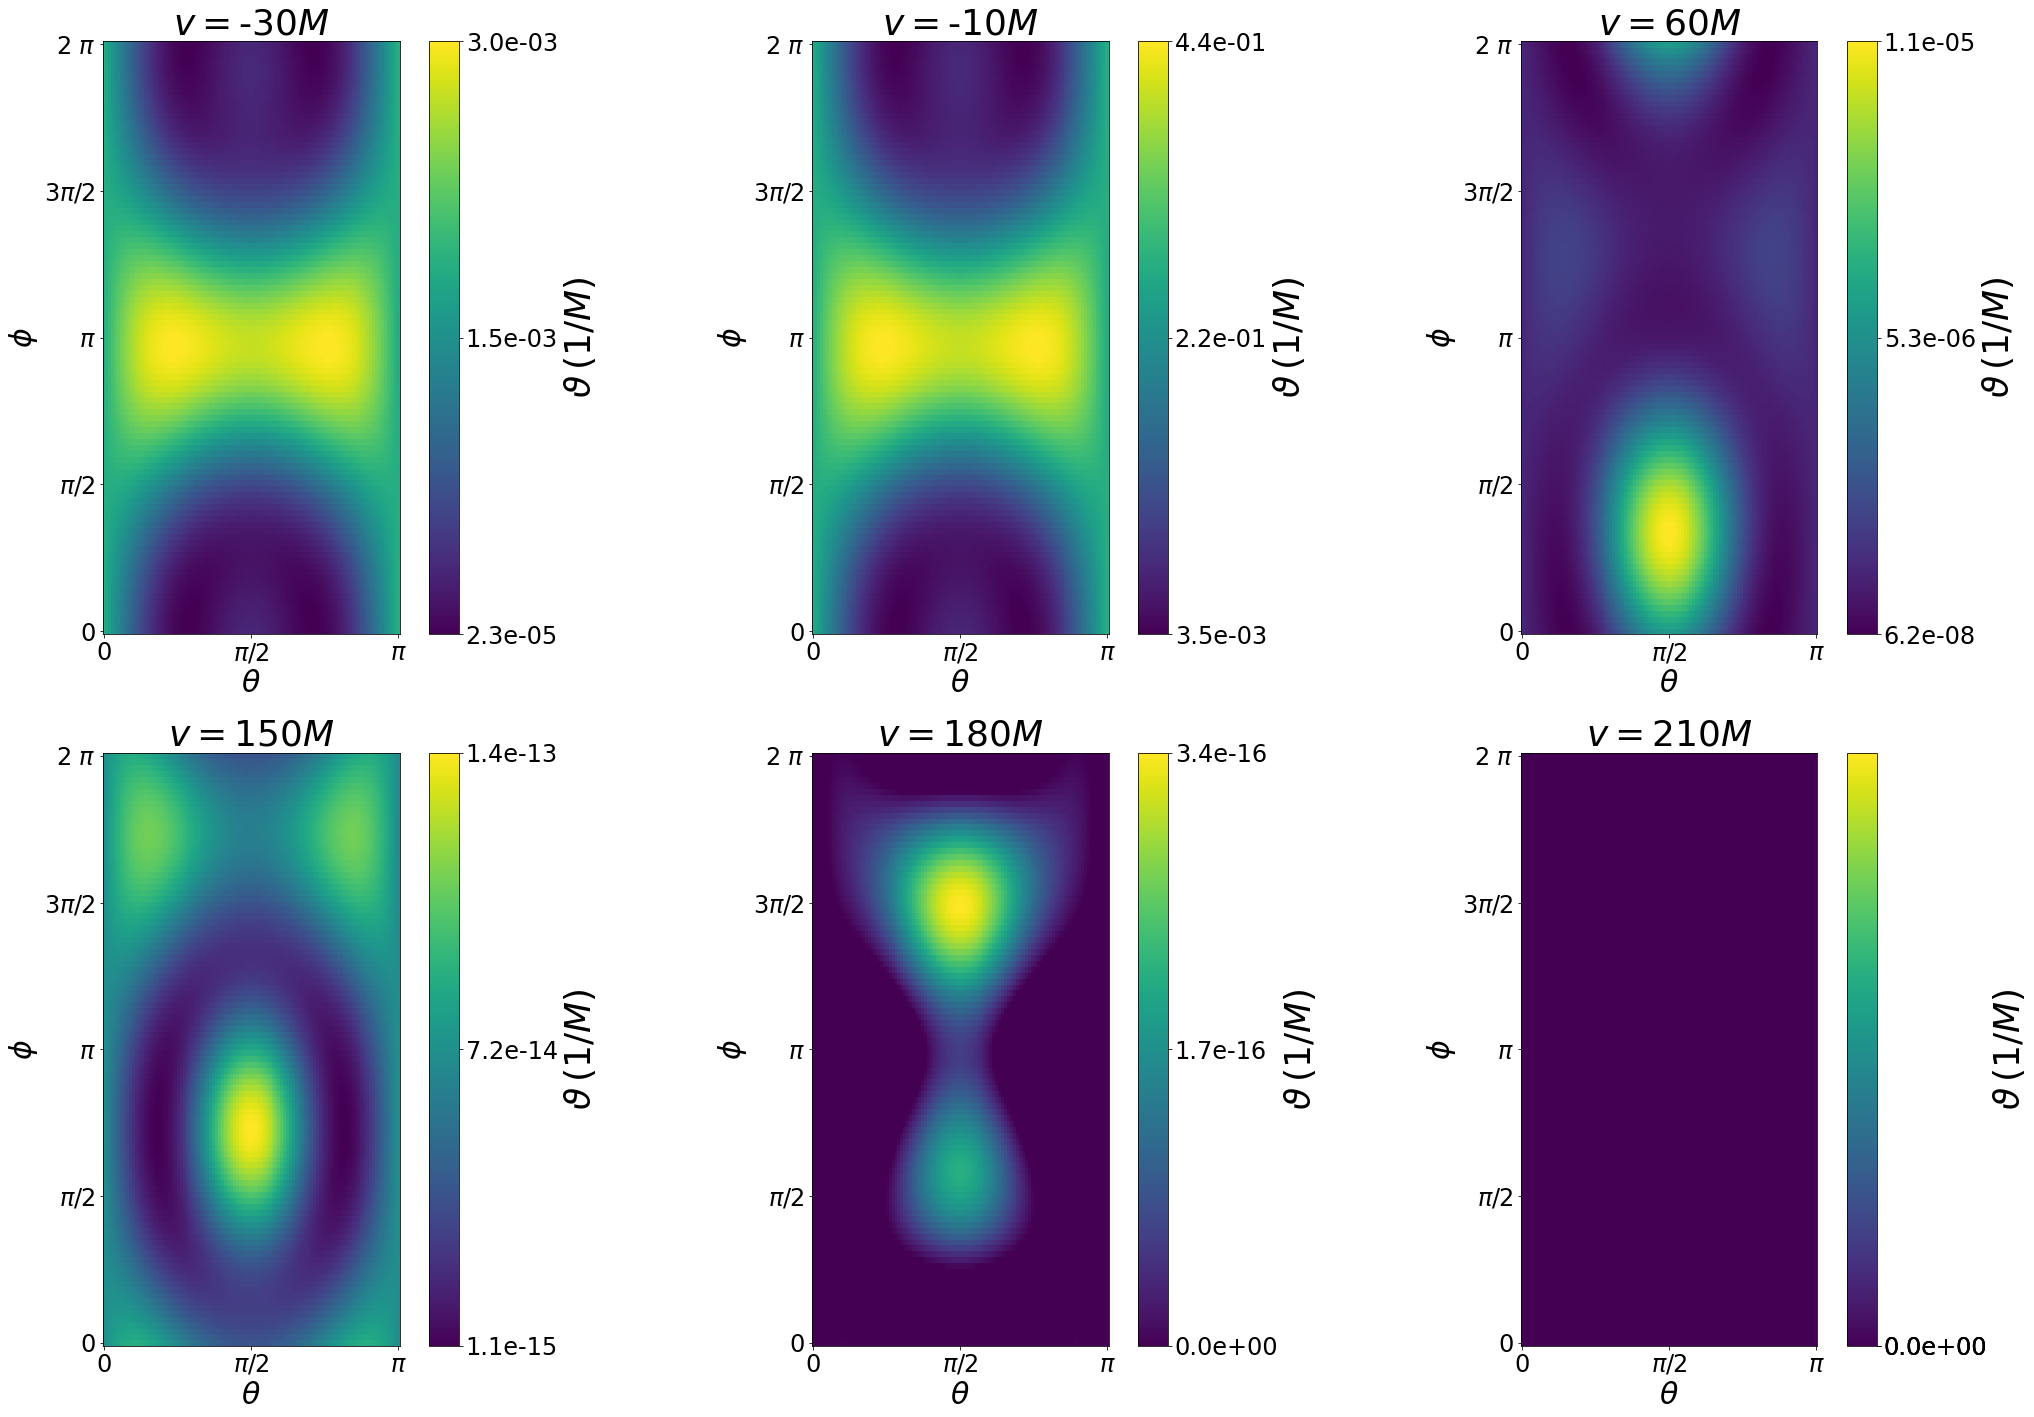

In [75]:
Nn=5
grid_N=100 
epsilon=np.sqrt(3*1e-8)
color_sensitivity=1e-16
fig = plt.figure(figsize=(36, 24))
plt.rcParams['font.size'] = '24'
for nn, vi in enumerate(index_list):
    C_time_at_V = Cab[:,vi]
    Theta_time_at_v = Theta[:,vi]
    time = varray[vi]
    # Create a grid of theta and phi values
    
    theta = np.linspace(1e-10, np.pi, grid_N)   # Polar angle
    phi = np.linspace(2*1e-10, 2 * np.pi, grid_N) # Azimuthal angle
    theta_grid, phi_grid = np.meshgrid(theta, phi, indexing = "ij") 
    Colors = np.zeros_like(theta_grid)
    # Compute the metric function values
    Thetascalar_at_v = S_at_v(Theta_time_at_v, 0, N, theta_grid, phi_grid)
    #if Thetascalar_at_v.max() / Thetascalar_at_v.min() > 1e1:
    #    print("Color gap is huge")
    for ii in range(0,len(theta)):
        for jj in range(0,len(phi)):
            Colors[ii, jj] = max([np.real(Thetascalar_at_v)[ii,jj], color_sensitivity])
        
    ### Plot
    ax = fig.add_subplot(2, 3, nn+1)
    cmap = cm.viridis
    norm = mcolors.Normalize(vmin=Colors.min(), vmax=Colors.max()) #

    ax.pcolormesh(theta_grid, phi_grid, Thetascalar_at_v.real, cmap = cmap, norm = norm, shading = 'auto')
    ax.set_aspect(1)
    ax.set_xlabel(r"$\theta$", size=30)
    ax.set_ylabel(r"$\phi$", size=30)
    #ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
    #ax.xaxis.set_major_locator(tck.MultipleLocator(base=1.0))
    #ax.set_title('Temperature at $v=$' + str(time) + r'$\mathrm{M}$', fontsize=16)
    ax.set_title(r'$v= ${:.0f}'.format(time) + r'$M$', fontsize=36)
    ax.set_xticks(np.linspace(0, np.pi, 3))
    a=ax.get_xticks().tolist()
    a=[0, r'$\pi / 2$', r'$\pi$' ]
    ax.set_xticklabels(a)


    ax.set_yticks(np.linspace(0, 2*np.pi, 5))
    b=ax.get_yticks().tolist()
    b=[0, r'$\pi / 2$', r'$\pi$', r'$3 \pi / 2$', r'2 $\pi$' ]
    ax.set_yticklabels(b)

    if nn < 4:
        # Add a color bar to explain the coloring
        m = cm.ScalarMappable(cmap=cmap, norm=norm)
        m.set_array(Colors) # Important: tell the ScalarMappable what data range it represents
        cbar = fig.colorbar(m, ax=ax, shrink=1, aspect=20)
        cbar.set_label(r'$\vartheta \, (1/M)$', size=36)
        cbar.set_ticks(np.linspace((max([np.real(Thetascalar_at_v).min(), color_sensitivity])), (np.real(Thetascalar_at_v)).max(), 3))  # Choose number of ticks
    elif nn == 4:
        # Add a color bar to explain the coloring
        norm = mcolors.Normalize(vmin=0, vmax=Colors.max()) 
        m = cm.ScalarMappable(cmap=cmap, norm=norm)
        m.set_array(Colors) # Important: tell the ScalarMappable what data range it represents
        cbar = fig.colorbar(m, ax=ax, shrink=1, aspect=20)
        cbar.set_label(r'$\vartheta \, (1/M)$', size=36)
        cbar.set_ticks(np.linspace(0, (np.real(Thetascalar_at_v)).max(), 3))  # Choose number of ticks    
    else:
        Colors = np.zeros_like(theta_grid)
        norm = mcolors.Normalize(vmin=Colors.min(), vmax=1e-16) #
        m = cm.ScalarMappable(cmap=cmap, norm=norm)
        m.set_array(Colors) # Important: tell the ScalarMappable what data range it represents
        cbar = fig.colorbar(m, ax=ax, shrink=1, aspect=20)
        cbar.set_label(r'$\vartheta \, (1/M)$', size=36)
        cbar.set_ticks([0.0, 0.0, 0.0])  # Choose number of ticks
    
    
    # Set format to limit digits
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    


plt.show()


#plt.savefig('embedding_plots-new.png', bbox_inches='tight', dpi=300)

## Extracting decay and oscillation frequencies

### Decay rates

In [76]:
from scipy.optimize import curve_fit

In [77]:
ringdown_start = np.where(varray==0)[0][0]
end_cutoff = -100

In [78]:
src_ringdown_start = np.where(varray2==0)[0][0]
src_end_cutoff = np.where(varray2==100)[0][0]

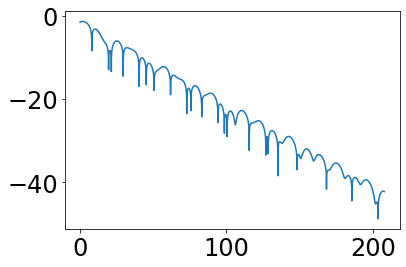

In [79]:
plt.plot(varray[ringdown_start:end_cutoff],np.log(abs(np.real(Theta[indexlm(1,-1)][ringdown_start:end_cutoff]))))

We can do a liner fit on the logarithmic functions to extract the decay rate.

In [80]:
def extract_decay_freq_lm(data_lm, time, ringdown_start, end_cutoff):
    # Fit a linear function to the logarithm of the data
    def fit_func(x, a, b):
        return a * x + b
    # Extract the relevant portion of the data
    data = data_lm[ringdown_start:end_cutoff]    
    fits, cov = curve_fit(fit_func, time[ringdown_start:end_cutoff], np.log(abs(data)))
    return fits[0], fits[1]  # Return the slope and intercept

In [81]:
def extract_decay_freq(data, time, mode_array, ringdown_start, end_cutoff):
    decay_freqs = {}
    for mode_lm in mode_array:
        data_lm = data[indexlm(mode_lm[0], mode_lm[1])]
        slope, intercept = extract_decay_freq_lm(data_lm, time, ringdown_start, end_cutoff)
        print(f"Mode {mode_lm}: Slope = {slope}, Intercept = {intercept}")
        decay_freqs[str(mode_lm)] = slope
    return decay_freqs

In [82]:
def plot_decay_freqs(decay_freqs, mode_array):
    plt.figure(figsize=(10, 6))
    for mode_lm in mode_array:
        plt.plot(mode_lm[0], decay_freqs[str(mode_lm)], 'o', label=f'Mode {mode_lm}')
    plt.xlabel('Mode l')
    plt.ylabel('Decay Frequency')
    plt.title('Decay Frequencies of Modes')
    plt.legend()
    plt.grid(True)
    plt.show()

In [83]:
modes = [(0,0),(1,-1), (1,1),(2, -2),(2,0),(2, 2),(3,-1),(3,1),(4,0)]

In [84]:
source_modes = [(0,0),(1,-1),(1,1),(2,0)]

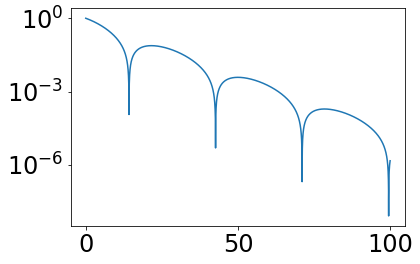

In [85]:
plt.semilogy(varray2[src_ringdown_start: src_end_cutoff], abs(Phi[indexlm(0,0)].real)[src_ringdown_start: src_end_cutoff])

Mode (0, 0): Slope = -0.10635795162012734, Intercept = -0.6357392010923786
Mode (1, -1): Slope = -0.0977, Intercept = -0.6931471805599453
Mode (1, 1): Slope = -0.0977, Intercept = -0.6931471805599453
Mode (2, 0): Slope = -0.09623915392623617, Intercept = -2.0975771910045906


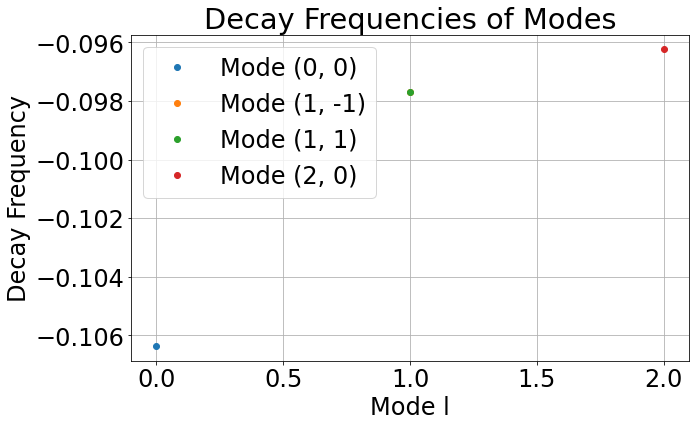

In [86]:
Phi_decay_freqs = source_decay_freqs = extract_decay_freq(Phi, varray2, source_modes , src_ringdown_start, src_end_cutoff)
plot_decay_freqs(source_decay_freqs, source_modes)

Mode (0, 0): Slope = -0.19609787893152375, Intercept = 0.02919334482035363
Mode (1, -1): Slope = -0.20026138993756115, Intercept = -1.1419389255977959
Mode (1, 1): Slope = -0.20026138993756115, Intercept = -1.1419389255977959
Mode (2, -2): Slope = -0.1953270979462911, Intercept = -1.3870934506735555
Mode (2, 0): Slope = -0.19451177695832708, Intercept = -1.6970339990182743
Mode (2, 2): Slope = -0.1953270979462911, Intercept = -1.3870934506735555
Mode (3, -1): Slope = -0.1948186015970268, Intercept = -1.5830327785963743
Mode (3, 1): Slope = -0.1948186015970268, Intercept = -1.5830327785963743
Mode (4, 0): Slope = -0.19400248371368156, Intercept = -2.2771742159197914


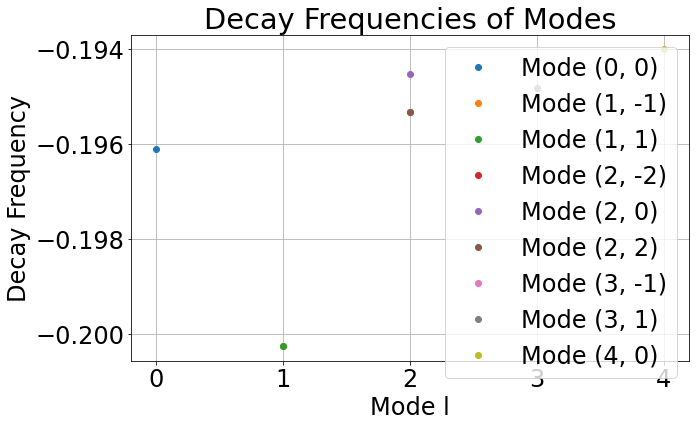

In [87]:
Theta_decay_freqs = extract_decay_freq(Theta, varray, modes , ringdown_start, end_cutoff)
plot_decay_freqs(Theta_decay_freqs, modes)

Text(0, 0.5, '$\\tau_{\\ell m}$')

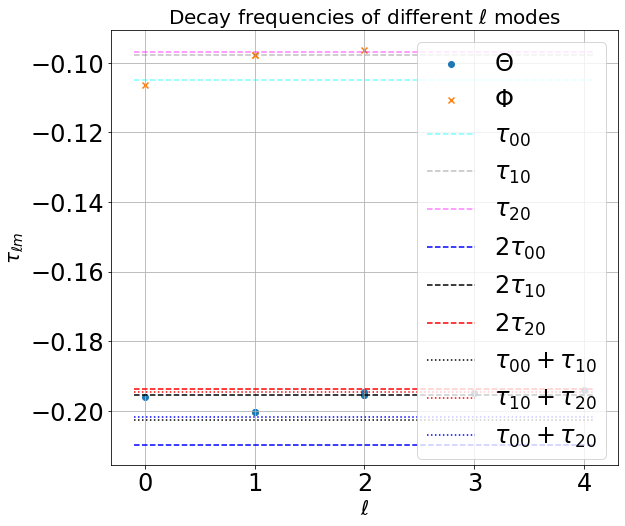

In [88]:
plt.subplots(figsize=(20, 8))

plt.subplot(1,2,1)
plt.scatter(np.array(modes)[:,0], Theta_decay_freqs.values(), label = r'$\Theta$')
#plt.scatter(np.array(modes)[1:,0], Haji_decay_freqs.values(), label = r'$H$')
#plt.scatter(np.array(modes)[3:,0], Cab_decay_freqs.values(), label = r'$C$')
#plt.scatter(toscattersource[::,0], toscattersource[::,1], label = r'$\mathcal{T}_{ll}$')

plt.scatter(np.array(source_modes)[:,0],  Phi_decay_freqs.values(), label = r'$\Phi$', marker= 'x')
#plt.scatter(toscatterdphi[::,0], toscatterdphi[::,1], label = r'$\partial_v\Phi$', marker= 'x')

plt.hlines(-0.1049, -0.1, 4.1, label=r"$\tau_{00}$", color ="cyan", linestyle= "dashed", alpha = 0.5)
plt.hlines(-0.0977, -0.1, 4.1, label=r"$\tau_{10}$", color ="grey", linestyle= "dashed", alpha = 0.5)
plt.hlines(-0.0968, -0.1, 4.1, label=r"$\tau_{20}$", color ="magenta", linestyle= "dashed", alpha = 0.5)

plt.hlines(-0.1049-0.1049, -0.1, 4.1, label=r"$2\tau_{00}$", color ="blue", linestyle= "dashed")
plt.hlines(-0.0977-0.0977, -0.1, 4.1, label=r"$2\tau_{10}$", color ="black", linestyle= "dashed")
plt.hlines(-0.0968-0.0968, -0.1, 4.1, label=r"$2\tau_{20}$", color ="red", linestyle= "dashed")

plt.hlines(-0.1049-0.0977, -0.1, 4.1, label=r"$\tau_{00}+\tau_{10}$", color ="black", linestyle= "dotted")
plt.hlines(-0.0968-0.0977, -0.1, 4.1, label=r"$\tau_{10}+\tau_{20}$", color ="red", linestyle= "dotted")
plt.hlines(-0.1049-0.0968, -0.1, 4.1, label=r"$\tau_{00}+\tau_{20}$", color ="blue", linestyle= "dotted")
plt.grid("on")
plt.legend()
plt.title("Decay frequencies of different $\ell$ modes", fontsize=20)
plt.xticks([0, 1, 2, 3, 4])
plt.xlabel(r"$\ell$", fontsize=20)
plt.ylabel(r"$\tau_{\ell m}$", fontsize=20)
#plt.hlines(expectedtau, -0.1, 4.1, color ="black", linestyle= "dashed")

#plt.ylim([-0.11, -0.090])
#plt.ylim([-0.22, -0.18])

### Oscillation frequencies

In [89]:
from scipy.signal import find_peaks

In [90]:
def extract_oscillation_freq_lm(data_lm, time, ringdown_start, end_cutoff):
    # Find peaks in the data
    peaks, _ = find_peaks(np.abs(data_lm[ringdown_start:end_cutoff]), height=0)
    if len(peaks) < 2:
        return None  # Not enough peaks to determine frequency
    # Calculate the frequency based on the time difference between peaks
    peak_times = time[peaks + ringdown_start]
    if len(peak_times) < 2:
        return None  # Not enough peaks to determine frequency
    freq = 1 / np.mean(np.diff(peak_times))
    return freq * 2 * np.pi

In [91]:
def extract_oscillation_freq(data, time, mode_array, ringdown_start, end_cutoff):
    oscillation_freqs = {}
    for mode_lm in mode_array:
        data_lm = data[indexlm(mode_lm[0], mode_lm[1])]
        freq = extract_oscillation_freq_lm(data_lm, time, ringdown_start, end_cutoff)
        if freq is not None:
            print(f"Mode {mode_lm}: Oscillation Frequency = {freq}")
            oscillation_freqs[str(mode_lm)] = freq
        else:
            oscillation_freqs[str(mode_lm)] = 0
            print(f"Mode {mode_lm}: Not enough peaks to determine frequency")
    return oscillation_freqs

In [92]:
def plot_oscillation_freqs(oscillation_freqs, mode_array):
    plt.figure(figsize=(10, 6))
    for mode_lm in mode_array:
        if str(mode_lm) in oscillation_freqs:
            plt.plot(mode_lm[0], oscillation_freqs[str(mode_lm)], 'o', label=f'Mode {mode_lm}')
    plt.xlabel('Mode l')
    plt.ylabel('Oscillation Frequency')
    plt.title('Oscillation Frequencies of Modes')
    plt.legend()
    plt.grid(True)
    plt.show()

modes = [(0,0),(1,-1), (1,1),(2, -2),(2,0),(2, 2),(3,-1),(3,1),(4,0)]

Mode (0, 0): Not enough peaks to determine frequency
Mode (1, -1): Oscillation Frequency = 0.6709546488590958
Mode (1, 1): Oscillation Frequency = 0.6709546488590958
Mode (2, -2): Not enough peaks to determine frequency
Mode (2, 0): Oscillation Frequency = 0.5832544500508703
Mode (2, 2): Not enough peaks to determine frequency
Mode (3, -1): Oscillation Frequency = 0.9713136706751051
Mode (3, 1): Oscillation Frequency = 0.9713136706751051
Mode (4, 0): Oscillation Frequency = 0.9680852113447672


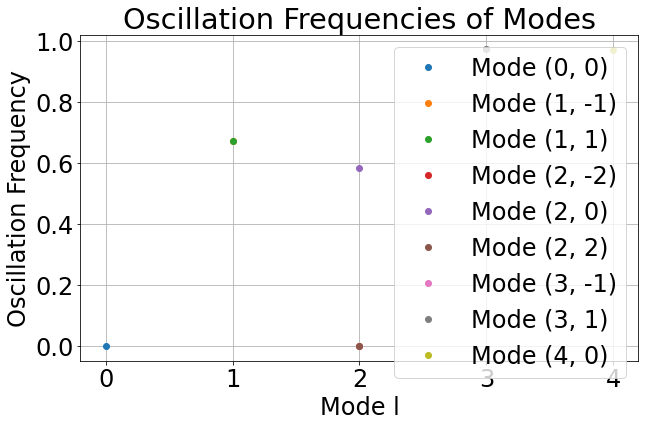

In [93]:
Theta_oscillation_freqs = extract_oscillation_freq(Theta, varray,modes, ringdown_start, end_cutoff)
plot_oscillation_freqs(Theta_oscillation_freqs, modes)

In [94]:
def extract_oscillation_freq_lm_fft(data_lm, time, ringdown_start, end_cutoff):

# Fit the decay rate and correct for it.
    decay_freq = extract_decay_freq_lm(data_lm, time, ringdown_start, end_cutoff)
    data_lm = data_lm[ringdown_start:end_cutoff] * np.exp(-decay_freq[0] * (time[ringdown_start:end_cutoff]))

    # Set time axis
    times = time[ringdown_start:end_cutoff]

    # Create a frequency axis
    freqs = np.fft.fftshift(np.fft.fftfreq(len(times), d = times[1]-times[0]) * 2 * np.pi) #np.fft.fftfreq(len(times), d = times[1]-times[0])
    
    
    # Perform FFT on the data
    data_fft = np.fft.fftshift(np.fft.ifft(data_lm, norm = "ortho")) # np.fft.fft(data_lm)[:len(times)//2] * 2/len(times)
    
    # Find peaks in the data, look only for the positive freq peaks.
    peaks, _ = find_peaks(np.abs(data_fft.real), height=0)
    
    oscillation_freqs =  freqs[peaks] 
    print(np.where(freqs[peaks]==0))
    max_peak = 0
    max_peak_freq = oscillation_freqs 
    for peak_index in peaks:
        #print(np.real(data_fft[peak_index]))
        if freqs[peak_index] > 0:
            if np.real(data_fft[peak_index]) > max_peak:
                max_peak = abs(np.real(data_fft[peak_index]))
                max_peak_freq  = [freqs[peak_index]]
    
    #print(np.where(data_fft[peaks] == max(data_fft[peaks]))[0])
    #print(oscillation_freqs)
    #if len(oscillation_freqs) > 1:
    #    print(f"Found {len(oscillation_freqs)} peaks in the FFT data with frequencies: {oscillation_freqs}")
    return max_peak_freq  #oscillation_freqs #np.array([positive_freqs for positive_freqs in oscillation_freqs if positive_freqs > 0])

In [95]:
def extract_oscillation_freq_fft(data, time, mode_array, ringdown_start, end_cutoff):
    oscillation_freqs = {}
    for mode_lm in mode_array:
        l,m = mode_lm
        data_lm = data[indexlm(l, m)]
        freq = extract_oscillation_freq_lm_fft(data_lm, time, ringdown_start, end_cutoff)
        if freq is not None:
            print(f"Mode {mode_lm}: Oscillation Frequency = {freq}")
            oscillation_freqs[str(mode_lm)] = freq
        else:
            oscillation_freqs[str(mode_lm)] = 0
            print(f"Mode {mode_lm}: Not enough peaks to determine frequency")
    return oscillation_freqs

In [96]:
Phi_oscillation_freqs = extract_oscillation_freq_fft(Phi, varray2, source_modes, src_ringdown_start, src_end_cutoff)

(array([], dtype=int64),)
Mode (0, 0): Oscillation Frequency = [0.12566370614357208]
(array([], dtype=int64),)
Mode (1, -1): Oscillation Frequency = [-0.31415927]
(array([], dtype=int64),)
Mode (1, 1): Oscillation Frequency = [0.31415926535893024]
(array([], dtype=int64),)
Mode (2, 0): Oscillation Frequency = [0.5026548245742883]


In [97]:
Theta_oscillation_freqs = extract_oscillation_freq_fft(Theta, varray,modes, ringdown_start, end_cutoff)

(array([5], dtype=int64),)
Mode (0, 0): Oscillation Frequency = [0.21143302158570348]
(array([], dtype=int64),)
Mode (1, -1): Oscillation Frequency = [0.15102358684693104]
(array([], dtype=int64),)
Mode (1, 1): Oscillation Frequency = [0.18122830421631725]
(array([], dtype=int64),)
Mode (2, -2): Oscillation Frequency = [-0.57388963]
(array([5], dtype=int64),)
Mode (2, 0): Oscillation Frequency = [0.3624566084326345]
(array([], dtype=int64),)
Mode (2, 2): Oscillation Frequency = [0.5738896300183379]
(array([], dtype=int64),)
Mode (3, -1): Oscillation Frequency = [-0.78532265  0.1812283   1.14777926]
(array([], dtype=int64),)
Mode (3, 1): Oscillation Frequency = [-1.14777926 -0.1812283   0.78532265]
(array([3], dtype=int64),)
Mode (4, 0): Oscillation Frequency = [0.9665509558203588]


### Combined plots

In [98]:
nonlinear_omega_twice = np.zeros(3, dtype=complex)
nonlinear_omega_twice[0] = qnm_scalar[0] * 2
nonlinear_omega_twice[1] = qnm_scalar[1] * 2
nonlinear_omega_twice[2] = qnm_scalar[2] * 2
nonlinear_omega_sum = np.zeros(3, dtype=complex)
nonlinear_omega_sum[0] = qnm_scalar[0] + qnm_scalar[1]
nonlinear_omega_sum[1] = qnm_scalar[0] + qnm_scalar[2]
nonlinear_omega_sum[2] = qnm_scalar[1] + qnm_scalar[2]
nonlinear_omega_diff = np.zeros(3, dtype=complex)
nonlinear_omega_diff[0] = qnm_scalar[1] - np.conjugate(qnm_scalar[0])
nonlinear_omega_diff[1] = qnm_scalar[2] - np.conjugate(qnm_scalar[0])
nonlinear_omega_diff[2] = qnm_scalar[2] - np.conjugate(qnm_scalar[1])


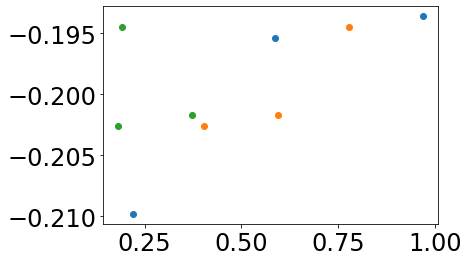

In [99]:
plt.plot(nonlinear_omega_twice.real, nonlinear_omega_twice.imag, 'o', label='Nonlinear QNM Frequencies')
plt.plot(nonlinear_omega_sum.real, nonlinear_omega_sum.imag, 'o', label='Nonlinear QNM Frequencies')
plt.plot(nonlinear_omega_diff.real, nonlinear_omega_diff.imag, 'o', label='Nonlinear QNM Frequencies')

In [100]:
source_modes_to_plot = [(0, 0), (1, 1), (2, 0)]

In [101]:
short_modes = [(0,0),(1,-1),(2,-2),(3,-1),(4,0)]

Text(0, 0.5, '$\\tau_{\\ell m}$')

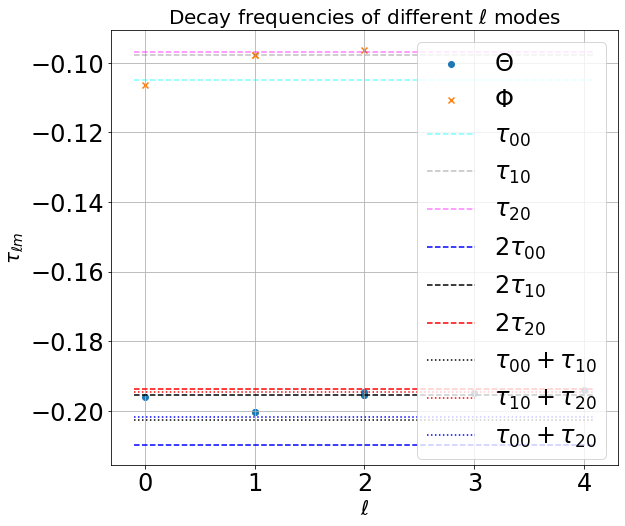

In [102]:
plt.subplots(figsize=(20, 8))

plt.subplot(1,2,1)
plt.scatter(np.array(modes)[:,0], Theta_decay_freqs.values(), label = r'$\Theta$')
#plt.scatter(np.array(modes)[1:,0], Haji_decay_freqs.values(), label = r'$H$')
#plt.scatter(np.array(modes)[3:,0], Cab_decay_freqs.values(), label = r'$C$')
#plt.scatter(toscattersource[::,0], toscattersource[::,1], label = r'$\mathcal{T}_{ll}$')

plt.scatter(np.array(source_modes)[:,0],  Phi_decay_freqs.values(), label = r'$\Phi$', marker= 'x')
#plt.scatter(toscatterdphi[::,0], toscatterdphi[::,1], label = r'$\partial_v\Phi$', marker= 'x')

plt.hlines(-0.1049, -0.1, 4.1, label=r"$\tau_{00}$", color ="cyan", linestyle= "dashed", alpha = 0.5)
plt.hlines(-0.0977, -0.1, 4.1, label=r"$\tau_{10}$", color ="grey", linestyle= "dashed", alpha = 0.5)
plt.hlines(-0.0968, -0.1, 4.1, label=r"$\tau_{20}$", color ="magenta", linestyle= "dashed", alpha = 0.5)

plt.hlines(-0.1049-0.1049, -0.1, 4.1, label=r"$2\tau_{00}$", color ="blue", linestyle= "dashed")
plt.hlines(-0.0977-0.0977, -0.1, 4.1, label=r"$2\tau_{10}$", color ="black", linestyle= "dashed")
plt.hlines(-0.0968-0.0968, -0.1, 4.1, label=r"$2\tau_{20}$", color ="red", linestyle= "dashed")

plt.hlines(-0.1049-0.0977, -0.1, 4.1, label=r"$\tau_{00}+\tau_{10}$", color ="black", linestyle= "dotted")
plt.hlines(-0.0968-0.0977, -0.1, 4.1, label=r"$\tau_{10}+\tau_{20}$", color ="red", linestyle= "dotted")
plt.hlines(-0.1049-0.0968, -0.1, 4.1, label=r"$\tau_{00}+\tau_{20}$", color ="blue", linestyle= "dotted")
plt.grid("on")
plt.legend()
plt.title("Decay frequencies of different $\ell$ modes", fontsize=20)
plt.xticks([0, 1, 2, 3, 4])
plt.xlabel(r"$\ell$", fontsize=20)
plt.ylabel(r"$\tau_{\ell m}$", fontsize=20)
#plt.hlines(expectedtau, -0.1, 4.1, color ="black", linestyle= "dashed")

#plt.ylim([-0.11, -0.090])
#plt.ylim([-0.22, -0.18])

In [103]:
[min(i) for i in Theta_oscillation_freqs.values()]

[0.21143302158570348,
 0.15102358684693104,
 0.18122830421631725,
 -0.5738896300183379,
 0.3624566084326345,
 0.5738896300183379,
 -0.7853226516040415,
 -1.1477792600366759,
 0.9665509558203588]

Text(0, 0.5, '$\\omega_{\\ell m}$')

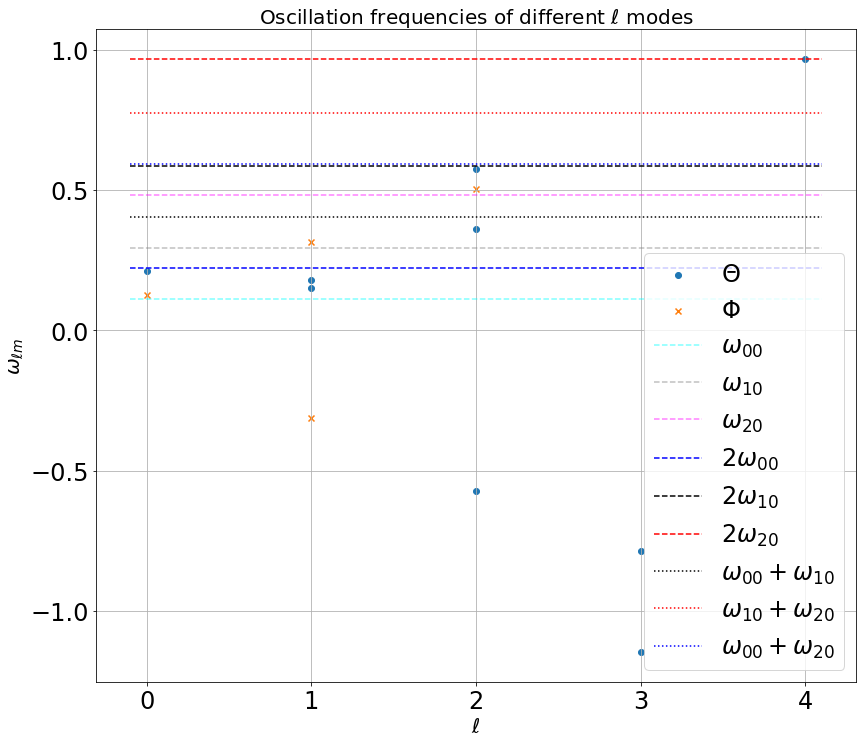

In [105]:
plt.subplots(figsize=(30, 12))

plt.subplot(1,2,1)
plt.scatter(np.array(modes)[:,0], [min(i) for i in Theta_oscillation_freqs.values()], label = r'$\Theta$')
#plt.scatter(np.array(modes)[1:,0], [min(i) for i in Haji_oscillation_freqs.values()], label = r'$H$', marker="s")
#plt.scatter(np.array(modes)[3:,0], [min(i) for i in Cab_oscillation_freqs.values()], label = r'$C$', marker="^")
#plt.scatter(toscattersource[::,0], toscattersource[::,1], label = r'$\mathcal{T}_{ll}$')

plt.scatter(np.array(source_modes)[:,0],  Phi_oscillation_freqs.values(), label = r'$\Phi$', marker= 'x')
#plt.scatter(toscatterdphi[::,0], toscatterdphi[::,1], label = r'$\partial_v\Phi$', marker= 'x')

#for ww in nonlinear_omega_twice:
    #plt.hlines(ww.real, -0,1. 4.1, abel=r"$\tau_{}$".format(source_modes), color ="cyan", linestyle= "dashed", alpha = 0.5)

plt.hlines(0.1105, -0.1, 4.1, label=r"$\omega_{00}$", color ="cyan", linestyle= "dashed", alpha = 0.5)
plt.hlines(0.2929, -0.1, 4.1, label=r"$\omega_{10}$", color ="grey", linestyle= "dashed", alpha = 0.5)
plt.hlines(0.4836, -0.1, 4.1, label=r"$\omega_{20}$", color ="magenta", linestyle= "dashed", alpha = 0.5)


plt.hlines(0.1105*2, -0.1, 4.1, label=r"$2\omega_{00}$", color ="blue", linestyle= "dashed")
plt.hlines(0.2929*2, -0.1, 4.1, label=r"$2\omega_{10}$", color ="black", linestyle= "dashed")
plt.hlines(0.4836*2, -0.1, 4.1, label=r"$2\omega_{20}$", color ="red", linestyle= "dashed")

plt.hlines(0.1105+0.2929, -0.1, 4.1, label=r"$\omega_{00}+\omega_{10}$", color ="black", linestyle= "dotted")
plt.hlines(0.4836+0.2929, -0.1, 4.1, label=r"$\omega_{10}+\omega_{20}$", color ="red", linestyle= "dotted")
plt.hlines(0.1105+0.4836, -0.1, 4.1, label=r"$\omega_{00}+\omega_{20}$", color ="blue", linestyle= "dotted")
#plt.hlines(0.4836 - 0.1105, -0.1, 4.1, label=r"$\omega_{20}-\omega_{00}$", color ="green", linestyle= "dotted")

plt.grid("on")
plt.legend()
plt.title("Oscillation frequencies of different $\ell$ modes", fontsize=20)
plt.xticks([0, 1, 2, 3, 4])
plt.xlabel(r"$\ell$", fontsize=20)
plt.ylabel(r"$\omega_{\ell m}$", fontsize=20)
#plt.hlines(expectedtau, -0.1, 4.1, color ="black", linestyle= "dashed")

#plt.ylim([-0.11, -0.090])
#plt.ylim([-0.22, -0.18])

In [106]:
print("2*f(00):", qnm_scalar[0]*2, '\t f(00) + f(10):', qnm_scalar[0] + qnm_scalar[1], '\t f(00) + f(20):', qnm_scalar[0] + qnm_scalar[2])
print("\t\t\t\t     2 * f(10):", qnm_scalar[1]*2, "\t f(10) + f(20):", qnm_scalar[1] + qnm_scalar[2])
print("\t\t\t\t\t\t\t\t\t     2 * f(20):", qnm_scalar[2]*2 )

print('f(10) - f(00):', (qnm_scalar[1] - np.conj(qnm_scalar[0])), '\t f(20) - f(00):', (qnm_scalar[2] - np.conj(qnm_scalar[0])))
print("\t\t\t\t f(20) - f(10):", (qnm_scalar[2] - np.conj(qnm_scalar[1])))


2*f(00): (0.221-0.2098j) 	 f(00) + f(10): (0.4034-0.2026j) 	 f(00) + f(20): (0.5941-0.2017j)
				     2 * f(10): (0.5858-0.1954j) 	 f(10) + f(20): (0.7765-0.1945j)
									     2 * f(20): (0.9672-0.1936j)
f(10) - f(00): (0.1824-0.2026j) 	 f(20) - f(00): (0.3731-0.2017j)
				 f(20) - f(10): (0.19069999999999998-0.1945j)


In [107]:
Theta_oscillation_freqs

{'(0, 0)': [0.21143302158570348],
 '(1, -1)': [0.15102358684693104],
 '(1, 1)': [0.18122830421631725],
 '(2, -2)': array([-0.57388963]),
 '(2, 0)': [0.3624566084326345],
 '(2, 2)': [0.5738896300183379],
 '(3, -1)': array([-0.78532265,  0.1812283 ,  1.14777926]),
 '(3, 1)': array([-1.14777926, -0.1812283 ,  0.78532265]),
 '(4, 0)': [0.9665509558203588]}

In [108]:
Theta_decay_freqs

{'(0, 0)': -0.19609787893152375,
 '(1, -1)': -0.20026138993756115,
 '(1, 1)': -0.20026138993756115,
 '(2, -2)': -0.1953270979462911,
 '(2, 0)': -0.19451177695832708,
 '(2, 2)': -0.1953270979462911,
 '(3, -1)': -0.1948186015970268,
 '(3, 1)': -0.1948186015970268,
 '(4, 0)': -0.19400248371368156}

### Rational Filter

In [109]:
def rational_filter(data_lm, time, modes):
    """
        Cite Ma et al.
        This function applies a rational filter to the data_lm in the time domain.
        It pads the data, applies the FFT, constructs the filter based on the modes,
        and returns the filtered data in the time domain.
    """
    # Pad the data
    len_pow = 2
    partition = 2

    padlen = 2 ** (len_pow + int(np.ceil(np.log2(len(data_lm))))) - len(data_lm)
    data_pad = np.pad(data_lm, (padlen // partition, padlen - (padlen // partition)),"constant", constant_values=(0, 0))
    ##
    delta_t = time[1] - time[0]
    end1 = time[-1] + (padlen - (padlen // partition)) * delta_t
    end2 = time[0] - (padlen // partition) * delta_t

    tpad = np.pad(time, (padlen // partition, padlen - (padlen // partition)), "linear_ramp", end_values=(end2, end1))

    # FFT of the padded
    fpad =  (np.fft.fftfreq(len(tpad), d = tpad[1]-tpad[0])) * 2 * np.pi
    data_pad_in_freq = (np.fft.ifft(data_pad, norm="ortho"))

    # Define the QNM filter
    total_filter = 1
    for qnm in modes:
        if qnm[1] == 'p':
            filter = (fpad - np.cdouble(qnm[0])) / (fpad - np.conj(np.cdouble(qnm[0]))) # postive frequency filter
        elif qnm[1] == 'n':
            filter = (fpad + np.conj(np.cdouble(qnm[0])) ) / (fpad + np.cdouble(qnm[0])) # negative frequency filter
        else:
            raise ValueError("Mode must be either 'p' for positive or 'n' for negative frequency.")
        total_filter *= filter
    
    # Apply the filter
    filtered_data = total_filter * data_pad_in_freq
    filtered_data_in_time = np.fft.fft(filtered_data, norm="ortho")



    return tpad, data_pad, filtered_data_in_time# , fpad, filtered_data_pad_in_freq 

In [110]:
def fft_results(tpad, data_pad, filtered_data_in_time, ringdown_start, ringdown_end):
    start_index = np.argmin(abs(tpad - ringdown_start))
    end_index = np.argmin(abs(tpad - ringdown_end))
    tpad = tpad[start_index:end_index]
    data_pad = data_pad[start_index:end_index]
    filtered_data_in_time = filtered_data_in_time[start_index:end_index]
    # fpad = np.fft.fftshift(np.fft.fftfreq(len(tpad), d = tpad_ringdown[1]-tpad_ringdown[0])) * 2 * np.pi   # Adjust fpad to match the filtered data
    # data_pad_in_freq = np.fft.fftshift(np.fft.ifft(data_pad, norm="ortho"))
    # filtered_data_pad_in_freq = np.fft.fftshift(np.fft.ifft(filtered_data_in_time norm="ortho"))
    fpad = np.fft.fftshift(np.fft.fftfreq(len(tpad), d = tpad[1]-tpad[0])) * 2 * np.pi
    data_pad_in_freq = np.fft.fftshift(np.fft.ifft(data_pad, norm="ortho"))
    filtered_data_pad_in_freq = np.fft.fftshift(np.fft.ifft(filtered_data_in_time, norm="ortho"))
    return fpad, data_pad_in_freq, filtered_data_pad_in_freq

In [111]:
tpadsrc, data_padsrc, filtered_data_in_timesrc = rational_filter(Phi[indexlm(0,0)], varray2, np.array([(qnm_scalar[0],'p'),(qnm_scalar[0],'n')]))
fpadsrc, data_pad_in_freqsrc, filtered_data_pad_in_freqsrc = fft_results(tpadsrc, data_padsrc, filtered_data_in_timesrc, ringdown_start=0, ringdown_end=100)

(1e-15, 100.0)

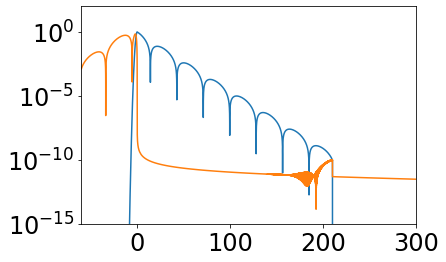

In [112]:
plt.semilogy(tpadsrc,abs(data_padsrc))
plt.semilogy(tpadsrc,abs(filtered_data_in_timesrc.real))
plt.xlim([-60, 300])
plt.ylim([1e-15, 1e2])

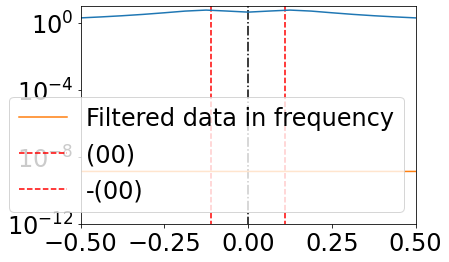

In [113]:
plt.semilogy(fpadsrc, abs(data_pad_in_freqsrc))
plt.semilogy(fpadsrc, abs(filtered_data_pad_in_freqsrc), label="Filtered data in frequency")
plt.vlines(np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='(00)')
plt.vlines(-np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='-(00)')
plt.vlines(0, ymin=1e-15, ymax=1e2, color='k', linestyle='-.')
plt.xlim([-0.5, 0.5])
plt.ylim([1e-12, 1e1])
plt.legend(loc= "lower right")

In [114]:
# Source theta
tpadsrcT, data_padsrcT, filtered_data_in_timesrcT = rational_filter(nonlinear_T[indexlm(3,1)], varray2, np.array([(qnm_scalar[1] - np.conj(qnm_scalar[0]), "n"), (qnm_scalar[1] + qnm_scalar[2], "p")]))
fpadsrcT, data_pad_in_freqsrcT, filtered_data_pad_in_freqsrcT = fft_results(tpadsrcT, data_padsrcT, filtered_data_in_timesrcT, ringdown_start=0, ringdown_end=100)

(1e-15, 100.0)

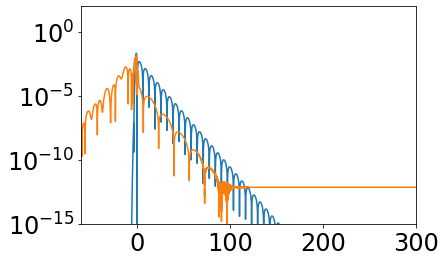

In [115]:
plt.semilogy(tpadsrcT,abs(data_padsrcT))
plt.semilogy(tpadsrcT,abs(filtered_data_in_timesrcT.real))
plt.xlim([-60, 300])
plt.ylim([1e-15, 1e2])

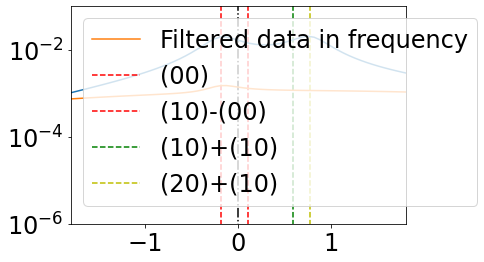

In [116]:
plt.semilogy(fpadsrcT, abs(data_pad_in_freqsrcT))
plt.semilogy(fpadsrcT, abs(filtered_data_pad_in_freqsrcT), label="Filtered data in frequency")
plt.vlines(np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='(00)')
plt.vlines(-np.real(qnm_scalar[1] - np.conj(qnm_scalar[0])), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='(10)-(00)')
#plt.vlines(np.real(-qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='r(10)')
#plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='g', linestyle='--', label='(10)+(00)')
plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='g', linestyle='--', label='(10)+(10)')
plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[2]), ymin=1e-15, ymax=1e2, color='y', linestyle='--', label='(20)+(10)')
plt.vlines(0, ymin=1e-15, ymax=1e2, color='k', linestyle='-.')
plt.xlim([-1.8, 1.8])
plt.ylim([1e-6, 1e-1])
plt.legend(loc= "upper left")

#### Theta

Theta results:
- for  00:   (00)+(00), - (00)+(00)
- for  11:   (10)+(00),   (10)-(00)
- for 1-1: - (10)+(00), - (10)-(00) == (00)-(10)
- for  20: b (00)+(00), b (11)+(11), b (20)+(20) & more
- for  22:   (10)+(10)
- for 2-2: - (10)+(10)
- for  31:   (10)+(20), - (20)-(10) == (10)-(20)
- for  40: b (20)+(20),   (20)-(20)

##### Theta (0,0)

In [117]:
# Theta result
modes = np.array([(qnm_scalar[0]+qnm_scalar[0],"p"),(qnm_scalar[0]+qnm_scalar[0],"n"),(qnm_scalar[2]+qnm_scalar[2],"n"),(qnm_scalar[2]+qnm_scalar[2],"p")])#, (qnm_scalar[2]+qnm_scalar[0],"p"), (qnm_scalar[1]+qnm_scalar[0],"p"), (qnm_scalar[1]+qnm_scalar[1],"p"), (qnm_scalar[2]+qnm_scalar[2],"p")(qnm_scalar[0]+qnm_scalar[0],"p"), (qnm_scalar[0]+qnm_scalar[0],"n"),(qnm_scalar[2]+qnm_scalar[2],"p"), (qnm_scalar[2]+qnm_scalar[2],"n"),(qnm_scalar[1]+qnm_scalar[1],"p"), (qnm_scalar[1]+qnm_scalar[1],"n"), (qnm_scalar[0]-np.conj(qnm_scalar[0]),"p"), (qnm_scalar[1]-np.conj(qnm_scalar[1]),"p"), (qnm_scalar[2]-np.conj(qnm_scalar[0]),"p"), (qnm_scalar[2]-np.conj(qnm_scalar[0]),"n")])
tpadTheta, data_padTheta, filtered_data_in_timeTheta = rational_filter(Theta[indexlm(0,0)], varray, modes)
fpadTheta, data_pad_in_freqTheta, filtered_data_pad_in_freqTheta = fft_results(tpadTheta, data_padTheta, filtered_data_in_timeTheta, ringdown_start=0, ringdown_end=100)

(1e-15, 100.0)

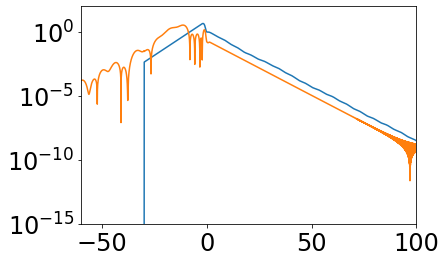

In [118]:
plt.semilogy(tpadTheta,abs(data_padTheta))
plt.semilogy(tpadTheta,abs(filtered_data_in_timeTheta.real))
plt.xlim([-60, 100])
plt.ylim([1e-15, 1e2])

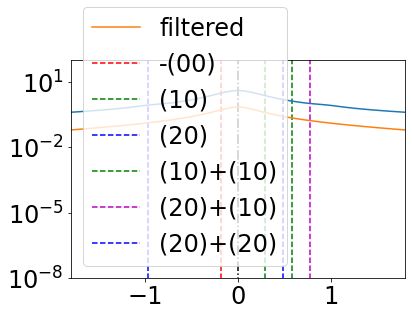

In [119]:
plt.semilogy(fpadTheta, abs(data_pad_in_freqTheta))
plt.semilogy(fpadTheta, abs(filtered_data_pad_in_freqTheta), label="filtered")
#plt.vlines(np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='(00)')
plt.vlines(-np.real(qnm_scalar[1] - np.conj(qnm_scalar[0])), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='-(00)')
plt.vlines(np.real(qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='g', linestyle='--', label='(10)')
plt.vlines(np.real(qnm_scalar[2]), ymin=1e-15, ymax=1e2, color='b', linestyle='--', label='(20)')
#plt.vlines(np.real(-qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='r(10)')
#plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='g', linestyle='--', label='(10)+(00)')
#plt.vlines(np.real(qnm_scalar[0]) + np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='(00)+(00)')
plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='g', linestyle='--', label='(10)+(10)')
#plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='y', linestyle='--', label='(10)-(10)')
plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[2]), ymin=1e-15, ymax=1e2, color='m', linestyle='--', label='(20)+(10)')
plt.vlines(-np.real(qnm_scalar[2]) - np.real(qnm_scalar[2]), ymin=1e-15, ymax=1e2, color='b', linestyle='--', label='(20)+(20)')
plt.vlines(0, ymin=1e-15, ymax=1e2, color='k', linestyle='-.')
plt.xlim([-1.8, 1.8])
plt.ylim([1e-8, 1e2])
plt.legend(loc= "lower left")

##### Theta (1,1)

In [120]:
# Theta result
modes = np.array([(qnm_scalar[0]+qnm_scalar[1],"p"), (qnm_scalar[1]-np.conj(qnm_scalar[0]),"p"),(qnm_scalar[1]-np.conj(qnm_scalar[0]),"n"), (qnm_scalar[2]+(qnm_scalar[1]),"p")])#, (qnm_scalar[2]+qnm_scalar[0],"p"), (qnm_scalar[1]+qnm_scalar[0],"p"), (qnm_scalar[1]+qnm_scalar[1],"p"), (qnm_scalar[2]+qnm_scalar[2],"p")(qnm_scalar[0]+qnm_scalar[0],"p"), (qnm_scalar[0]+qnm_scalar[0],"n"),(qnm_scalar[2]+qnm_scalar[2],"p"), (qnm_scalar[2]+qnm_scalar[2],"n"),(qnm_scalar[1]+qnm_scalar[1],"p"), (qnm_scalar[1]+qnm_scalar[1],"n"), (qnm_scalar[0]-np.conj(qnm_scalar[0]),"p"), (qnm_scalar[1]-np.conj(qnm_scalar[1]),"p"), (qnm_scalar[2]-np.conj(qnm_scalar[0]),"p"), (qnm_scalar[2]-np.conj(qnm_scalar[0]),"n")])
tpadTheta, data_padTheta, filtered_data_in_timeTheta = rational_filter(Theta[indexlm(1,1)], varray, modes)
fpadTheta, data_pad_in_freqTheta, filtered_data_pad_in_freqTheta = fft_results(tpadTheta, data_padTheta, filtered_data_in_timeTheta, ringdown_start=0, ringdown_end=100)

(1e-15, 100.0)

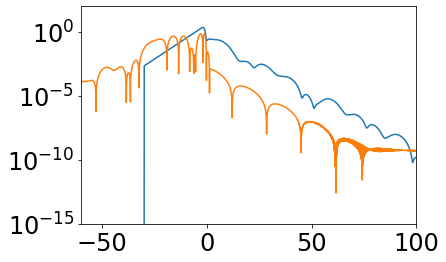

In [121]:
plt.semilogy(tpadTheta,abs(data_padTheta))
plt.semilogy(tpadTheta,abs(filtered_data_in_timeTheta.real))
plt.xlim([-60, 100])
plt.ylim([1e-15, 1e2])

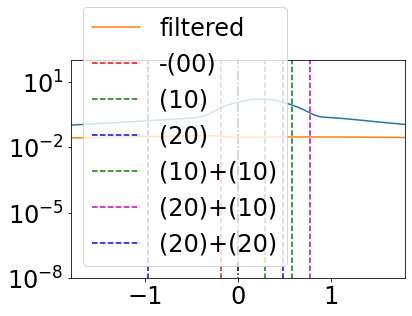

In [122]:
plt.semilogy(fpadTheta, abs(data_pad_in_freqTheta))
plt.semilogy(fpadTheta, abs(filtered_data_pad_in_freqTheta), label="filtered")
#plt.vlines(np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='(00)')
plt.vlines(-np.real(qnm_scalar[1] - np.conj(qnm_scalar[0])), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='-(00)')
plt.vlines(np.real(qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='g', linestyle='--', label='(10)')
plt.vlines(np.real(qnm_scalar[2]), ymin=1e-15, ymax=1e2, color='b', linestyle='--', label='(20)')
#plt.vlines(np.real(-qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='r(10)')
#plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='g', linestyle='--', label='(10)+(00)')
#plt.vlines(np.real(qnm_scalar[0]) + np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='(00)+(00)')
plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='g', linestyle='--', label='(10)+(10)')
#plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='y', linestyle='--', label='(10)-(10)')
plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[2]), ymin=1e-15, ymax=1e2, color='m', linestyle='--', label='(20)+(10)')
plt.vlines(-np.real(qnm_scalar[2]) - np.real(qnm_scalar[2]), ymin=1e-15, ymax=1e2, color='b', linestyle='--', label='(20)+(20)')
plt.vlines(0, ymin=1e-15, ymax=1e2, color='k', linestyle='-.')
plt.xlim([-1.8, 1.8])
plt.ylim([1e-8, 1e2])
plt.legend(loc= "lower left")

##### Theta (2,0)

In [123]:
# Theta result
modes = np.array([(qnm_scalar[1]+qnm_scalar[1],"p"),(qnm_scalar[1]+qnm_scalar[1],"n"), (qnm_scalar[2]+(qnm_scalar[2]),"p"),(qnm_scalar[2]+(qnm_scalar[2]),"n"), (qnm_scalar[2]-np.conj(qnm_scalar[0]),"p") , (qnm_scalar[2]-np.conj(qnm_scalar[0]),"n"),(qnm_scalar[2]+(qnm_scalar[0]),"p") , (qnm_scalar[2]+(qnm_scalar[0]),"n")])#,(qnm_scalar[1]-np.conj(qnm_scalar[1]),"n"),(qnm_scalar[1]-np.conj(qnm_scalar[1]),"p"),(qnm_scalar[0]-np.conj(qnm_scalar[0]),"n"),(qnm_scalar[0]-np.conj(qnm_scalar[0]),"p")])#, (qnm_scalar[2]+qnm_scalar[0],"p"), (qnm_scalar[1]+qnm_scalar[0],"p"), (qnm_scalar[1]+qnm_scalar[1],"p"), (qnm_scalar[2]+qnm_scalar[2],"p")(qnm_scalar[0]+qnm_scalar[0],"p"), (qnm_scalar[0]+qnm_scalar[0],"n"),(qnm_scalar[2]+qnm_scalar[2],"p"), (qnm_scalar[2]+qnm_scalar[2],"n"),(qnm_scalar[1]+qnm_scalar[1],"p"), (qnm_scalar[1]+qnm_scalar[1],"n"), (qnm_scalar[0]-np.conj(qnm_scalar[0]),"p"), (qnm_scalar[1]-np.conj(qnm_scalar[1]),"p"), (qnm_scalar[2]-np.conj(qnm_scalar[0]),"p"), (qnm_scalar[2]-np.conj(qnm_scalar[0]),"n")])
tpadTheta, data_padTheta, filtered_data_in_timeTheta = rational_filter(Theta[indexlm(2,0)], varray, modes) #(qnm_scalar[2]-np.conj(qnm_scalar[0]),"p") , (qnm_scalar[2]-np.conj(qnm_scalar[0]),"n"),
fpadTheta, data_pad_in_freqTheta, filtered_data_pad_in_freqTheta = fft_results(tpadTheta, data_padTheta, filtered_data_in_timeTheta, ringdown_start=00, ringdown_end=100)

(1e-15, 100.0)

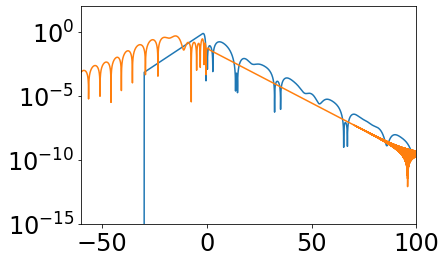

In [124]:
plt.semilogy(tpadTheta,abs(data_padTheta))
plt.semilogy(tpadTheta,abs(filtered_data_in_timeTheta.real))
plt.xlim([-60, 100])
plt.ylim([1e-15, 1e2])

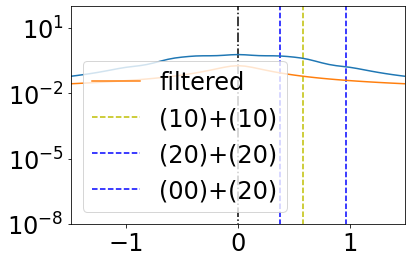

In [125]:
plt.semilogy(fpadTheta, abs(data_pad_in_freqTheta))
plt.semilogy(fpadTheta, abs(filtered_data_pad_in_freqTheta), label="filtered")
#plt.vlines(np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='(00)')
#plt.vlines(-np.real(qnm_scalar[1] - np.conj(qnm_scalar[0])), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='-(00)')
#plt.vlines(np.real(qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='g', linestyle='--', label='(10)')
#plt.vlines(np.real(qnm_scalar[2]), ymin=1e-15, ymax=1e2, color='b', linestyle='--', label='(20)')
#plt.vlines(np.real(-qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='r(10)')
#plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='g', linestyle='--', label='(10)+(00)')
#plt.vlines(np.real(qnm_scalar[0]) + np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='(00)+(00)')
#plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='g', linestyle='--', label='(10)+(10)')
plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='y', linestyle='--', label='(10)+(10)')
#plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[2]), ymin=1e-15, ymax=1e2, color='m', linestyle='--', label='(20)+(10)')
plt.vlines(np.real(qnm_scalar[2]) + np.real(qnm_scalar[2]), ymin=1e-15, ymax=1e2, color='b', linestyle='--', label='(20)+(20)')
plt.vlines(np.real(qnm_scalar[2]) - np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='b', linestyle='--', label='(00)+(20)')
plt.vlines(0, ymin=1e-15, ymax=1e2, color='k', linestyle='-.')
plt.xlim([-1.5, 1.5])
plt.ylim([1e-8, 1e2])
plt.legend(loc= "lower left")

##### Theta (2,2)

In [126]:
# Theta result
modes = np.array([(qnm_scalar[1]+qnm_scalar[1],"n")])#, (qnm_scalar[2]+qnm_scalar[0],"p"), (qnm_scalar[1]+qnm_scalar[0],"p"), (qnm_scalar[1]+qnm_scalar[1],"p"), (qnm_scalar[2]+qnm_scalar[2],"p")(qnm_scalar[0]+qnm_scalar[0],"p"), (qnm_scalar[0]+qnm_scalar[0],"n"),(qnm_scalar[2]+qnm_scalar[2],"p"), (qnm_scalar[2]+qnm_scalar[2],"n"),(qnm_scalar[1]+qnm_scalar[1],"p"), (qnm_scalar[1]+qnm_scalar[1],"n"), (qnm_scalar[0]-np.conj(qnm_scalar[0]),"p"), (qnm_scalar[1]-np.conj(qnm_scalar[1]),"p"), (qnm_scalar[2]-np.conj(qnm_scalar[0]),"p"), (qnm_scalar[2]-np.conj(qnm_scalar[0]),"n")])
tpadTheta, data_padTheta, filtered_data_in_timeTheta = rational_filter(Theta[indexlm(2,-2)], varray, modes)
fpadTheta, data_pad_in_freqTheta, filtered_data_pad_in_freqTheta = fft_results(tpadTheta, data_padTheta, filtered_data_in_timeTheta, ringdown_start=50, ringdown_end=100)

(1e-15, 100.0)

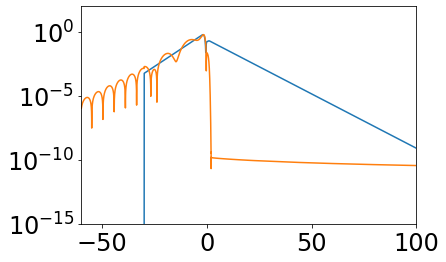

In [127]:
plt.semilogy(tpadTheta,abs(data_padTheta))
plt.semilogy(tpadTheta,abs(filtered_data_in_timeTheta.real))
plt.xlim([-60, 100])
plt.ylim([1e-15, 1e2])

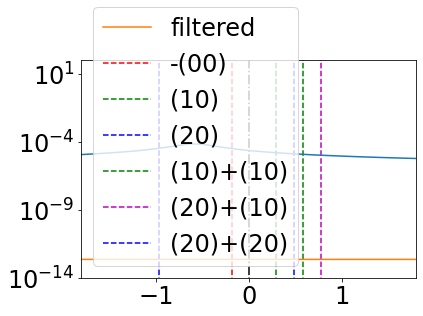

In [128]:
plt.semilogy(fpadTheta, abs(data_pad_in_freqTheta))
plt.semilogy(fpadTheta, abs(filtered_data_pad_in_freqTheta), label="filtered")
#plt.vlines(np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='(00)')
plt.vlines(-np.real(qnm_scalar[1] - np.conj(qnm_scalar[0])), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='-(00)')
plt.vlines(np.real(qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='g', linestyle='--', label='(10)')
plt.vlines(np.real(qnm_scalar[2]), ymin=1e-15, ymax=1e2, color='b', linestyle='--', label='(20)')
#plt.vlines(np.real(-qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='r(10)')
#plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='g', linestyle='--', label='(10)+(00)')
#plt.vlines(np.real(qnm_scalar[0]) + np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='(00)+(00)')
plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='g', linestyle='--', label='(10)+(10)')
#plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='y', linestyle='--', label='(10)-(10)')
plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[2]), ymin=1e-15, ymax=1e2, color='m', linestyle='--', label='(20)+(10)')
plt.vlines(-np.real(qnm_scalar[2]) - np.real(qnm_scalar[2]), ymin=1e-15, ymax=1e2, color='b', linestyle='--', label='(20)+(20)')
plt.vlines(0, ymin=1e-15, ymax=1e2, color='k', linestyle='-.')
plt.xlim([-1.8, 1.8])
plt.ylim([1e-14, 1e2])
plt.legend(loc= "lower left")

##### Theta (3,1)

In [129]:
# Theta result
modes = np.array([(qnm_scalar[1]+qnm_scalar[2],"n"),(qnm_scalar[1]-np.conj(qnm_scalar[2]),"n")])
tpadTheta, data_padTheta, filtered_data_in_timeTheta = rational_filter(Theta[indexlm(3,-1)], varray, modes)
fpadTheta, data_pad_in_freqTheta, filtered_data_pad_in_freqTheta = fft_results(tpadTheta, data_padTheta, filtered_data_in_timeTheta, ringdown_start=0, ringdown_end=80)

(1e-15, 100.0)

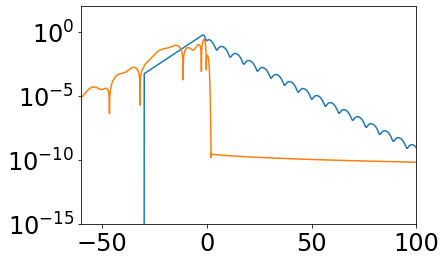

In [130]:
plt.semilogy(tpadTheta,abs(data_padTheta))
plt.semilogy(tpadTheta,abs(filtered_data_in_timeTheta.real))
plt.xlim([-60, 100])
plt.ylim([1e-15, 1e2])

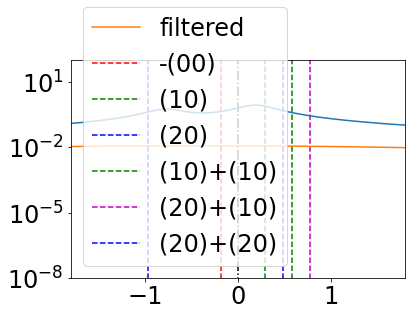

In [131]:
plt.semilogy(fpadTheta, abs(data_pad_in_freqTheta))
plt.semilogy(fpadTheta, abs(filtered_data_pad_in_freqTheta), label="filtered")
#plt.vlines(np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='(00)')
plt.vlines(-np.real(qnm_scalar[1] - np.conj(qnm_scalar[0])), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='-(00)')
plt.vlines(np.real(qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='g', linestyle='--', label='(10)')
plt.vlines(np.real(qnm_scalar[2]), ymin=1e-15, ymax=1e2, color='b', linestyle='--', label='(20)')
#plt.vlines(np.real(-qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='r(10)')
#plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='g', linestyle='--', label='(10)+(00)')
#plt.vlines(np.real(qnm_scalar[0]) + np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='(00)+(00)')
plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='g', linestyle='--', label='(10)+(10)')
#plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='y', linestyle='--', label='(10)-(10)')
plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[2]), ymin=1e-15, ymax=1e2, color='m', linestyle='--', label='(20)+(10)')
plt.vlines(-np.real(qnm_scalar[2]) - np.real(qnm_scalar[2]), ymin=1e-15, ymax=1e2, color='b', linestyle='--', label='(20)+(20)')
plt.vlines(0, ymin=1e-15, ymax=1e2, color='k', linestyle='-.')
plt.xlim([-1.8, 1.8])
plt.ylim([1e-8, 1e2])
plt.legend(loc= "lower left")

##### Theta (4,0)

In [132]:
qnm_scalar[2]-np.conj(qnm_scalar[2])

-0.1936j

In [133]:
(qnm_scalar[2]+qnm_scalar[2],"p")

((0.9672-0.1936j), 'p')

In [134]:
# Theta result
modes = np.array([(qnm_scalar[2]+qnm_scalar[2],"p"),(qnm_scalar[2]+qnm_scalar[2],"n"), (qnm_scalar[2]-np.conj(qnm_scalar[2]),"n")])#, (qnm_scalar[2]+qnm_scalar[0],"p"), (qnm_scalar[1]+qnm_scalar[0],"p"), (qnm_scalar[1]+qnm_scalar[1],"p"), (qnm_scalar[2]+qnm_scalar[2],"p")(qnm_scalar[0]+qnm_scalar[0],"p"), (qnm_scalar[0]+qnm_scalar[0],"n"),(qnm_scalar[2]+qnm_scalar[2],"p"), (qnm_scalar[2]+qnm_scalar[2],"n"),(qnm_scalar[1]+qnm_scalar[1],"p"), (qnm_scalar[1]+qnm_scalar[1],"n"), (qnm_scalar[0]-np.conj(qnm_scalar[0]),"p"), (qnm_scalar[1]-np.conj(qnm_scalar[1]),"p"), (qnm_scalar[2]-np.conj(qnm_scalar[0]),"p"), (qnm_scalar[2]-np.conj(qnm_scalar[0]),"n")])
tpadTheta, data_padTheta, filtered_data_in_timeTheta = rational_filter(Theta[indexlm(4,0)], varray, modes)
fpadTheta, data_pad_in_freqTheta, filtered_data_pad_in_freqTheta = fft_results(tpadTheta, data_padTheta, filtered_data_in_timeTheta, ringdown_start=0, ringdown_end=80)

(1e-15, 100.0)

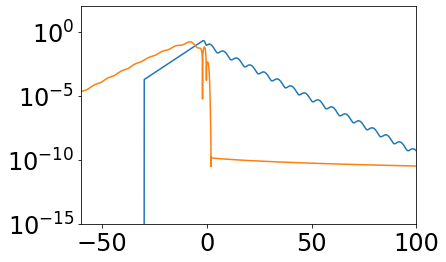

In [135]:
plt.semilogy(tpadTheta,abs(data_padTheta))
plt.semilogy(tpadTheta,abs(filtered_data_in_timeTheta.real))
plt.xlim([-60, 100])
plt.ylim([1e-15, 1e2])

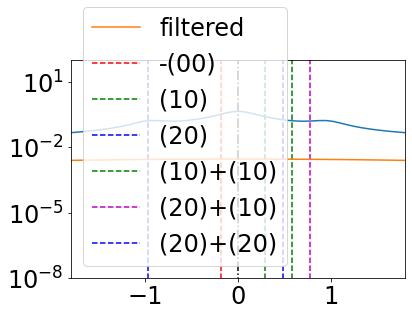

In [136]:
plt.semilogy(fpadTheta, abs(data_pad_in_freqTheta))
plt.semilogy(fpadTheta, abs(filtered_data_pad_in_freqTheta), label="filtered")
#plt.vlines(np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='(00)')
plt.vlines(-np.real(qnm_scalar[1] - np.conj(qnm_scalar[0])), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='-(00)')
plt.vlines(np.real(qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='g', linestyle='--', label='(10)')
plt.vlines(np.real(qnm_scalar[2]), ymin=1e-15, ymax=1e2, color='b', linestyle='--', label='(20)')
#plt.vlines(np.real(-qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='r(10)')
#plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='g', linestyle='--', label='(10)+(00)')
#plt.vlines(np.real(qnm_scalar[0]) + np.real(qnm_scalar[0]), ymin=1e-15, ymax=1e2, color='r', linestyle='--', label='(00)+(00)')
plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='g', linestyle='--', label='(10)+(10)')
#plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[1]), ymin=1e-15, ymax=1e2, color='y', linestyle='--', label='(10)-(10)')
plt.vlines(np.real(qnm_scalar[1]) + np.real(qnm_scalar[2]), ymin=1e-15, ymax=1e2, color='m', linestyle='--', label='(20)+(10)')
plt.vlines(-np.real(qnm_scalar[2]) - np.real(qnm_scalar[2]), ymin=1e-15, ymax=1e2, color='b', linestyle='--', label='(20)+(20)')
plt.vlines(0, ymin=1e-15, ymax=1e2, color='k', linestyle='-.')
plt.xlim([-1.8, 1.8])
plt.ylim([1e-8, 1e2])
plt.legend(loc= "lower left")

Theta results:
- for  00:   (00)+(00),   (20)+(20)
- for  11:   (00)+(10),   (10)-(00),  (20)+(10)
- for  20:   (11)+(11),   (20)+(20),  (20)-(00), (20)+(00)
- for  22:   (10)+(10)
- for 2-2: n (10)+(10)
- for  31:   (10)+(20),   (10)-(20)
- for  31: n (10)+(20), n (10)-(20)
- for  40: b (20)+(20),   (20)-(20)

In [137]:
Theta_modes_filter = {'(0, 0)': np.array([qnm_scalar[0]+qnm_scalar[0],qnm_scalar[2]+qnm_scalar[2]]),
                      '(1, 1)': np.array([qnm_scalar[1]+qnm_scalar[0], qnm_scalar[1]-np.conj(qnm_scalar[0]),qnm_scalar[1]+qnm_scalar[2]]),
                      '(2, 0)': np.array([qnm_scalar[1]+qnm_scalar[1],qnm_scalar[2]+qnm_scalar[2],qnm_scalar[2]+qnm_scalar[0]]),
                      '(2, 2)': np.array([qnm_scalar[1]+qnm_scalar[1]]),
                      '(3, 1)': np.array([qnm_scalar[1]+qnm_scalar[2], qnm_scalar[2]-np.conj(qnm_scalar[1])]),
                      '(4, 0)': np.array([qnm_scalar[2]+qnm_scalar[2]])}

No handles with labels found to put in legend.


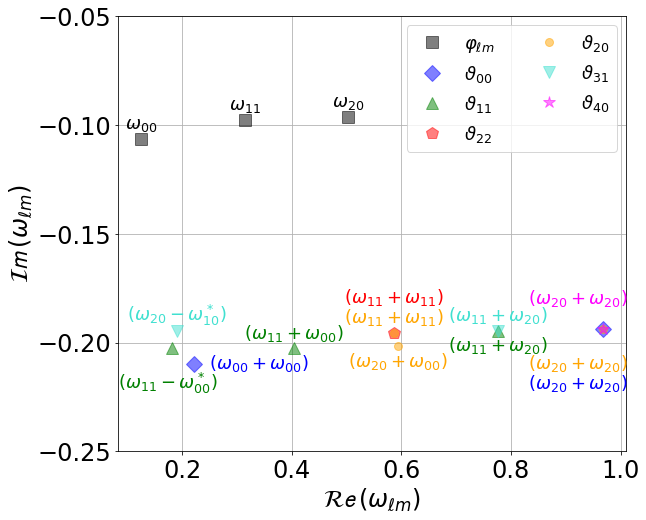

In [138]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121)

ax.legend(fontsize = 24)
plt.rcParams['font.size'] = '20'
FS = 18

for lm in source_modes_to_plot:
    l, m = lm
    Phi_omega = float(Phi_oscillation_freqs[str(lm)][0]) + 1j*float(Phi_decay_freqs[str(lm)])
    if l == 0: 
        phi_label = r"$\varphi_{\ell m}$" 
    else: 
        phi_label = ""
    if m >= 0:
        phi_anno = str(lm)
    else:
        phi_anno = "("+str(l)+", $\pm$"+str(abs(m)) +")"
    
    ax.plot(Phi_omega.real, Phi_omega.imag, 's', label=phi_label, color='black', markersize=12, alpha=0.5)
    
plt.annotate(r'$\omega_{00}$', (Phi_oscillation_freqs['(0, 0)'][0], Phi_decay_freqs['(0, 0)']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=FS, color='black')
plt.annotate(r'$\omega_{11}$', (Phi_oscillation_freqs['(1, 1)'][0], Phi_decay_freqs['(1, 1)']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=FS, color='black')
plt.annotate(r'$\omega_{20}$', (Phi_oscillation_freqs['(2, 0)'][0], Phi_decay_freqs['(2, 0)']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=FS, color='black')


ax.plot(Theta_modes_filter[('(0, 0)')].real, Theta_modes_filter[('(0, 0)')].imag, 'D', label=r"$\vartheta_{00}$", color='blue', markersize=12,alpha=0.5)
plt.annotate(r'$(\omega_{00} + \omega_{00})$', (Theta_modes_filter[('(0, 0)')].real[0], Theta_modes_filter[('(0, 0)')].imag[0]), textcoords="offset points", xytext=(65,-5), ha='center', fontsize=FS, color='blue')
plt.annotate(r'$(\omega_{20} + \omega_{20})$', (Theta_modes_filter[('(0, 0)')].real[1], Theta_modes_filter[('(0, 0)')].imag[1]), textcoords="offset points", xytext=(-25,-60), ha='center', fontsize=FS, color='blue')

ax.plot(Theta_modes_filter[('(1, 1)')].real, Theta_modes_filter[('(1, 1)')].imag, '^',  label=r"$\vartheta_{11}$", color='green', markersize=12,alpha=0.5)
plt.annotate(r'$(\omega_{11} + \omega_{00})$', (Theta_modes_filter[('(1, 1)')].real[0], Theta_modes_filter[('(1, 1)')].imag[0]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=FS, color='green')
plt.annotate(r'$(\omega_{11} - \omega_{00}^*)$', (Theta_modes_filter[('(1, 1)')].real[1], Theta_modes_filter[('(1, 1)')].imag[1]), textcoords="offset points", xytext=(-5,-40), ha='center', fontsize=FS, color='green')
plt.annotate(r'$(\omega_{11} + \omega_{20})$', (Theta_modes_filter[('(1, 1)')].real[2], Theta_modes_filter[('(1, 1)')].imag[2]), textcoords="offset points", xytext=(0,-20), ha='center', fontsize=FS, color='green')

ax.plot(Theta_modes_filter[('(2, 2)')].real, Theta_modes_filter[('(2, 2)')].imag, 'p',  label=r"$\vartheta_{22}$", color='red', markersize=12,alpha=0.5)
plt.annotate(r'$(\omega_{11} + \omega_{11})$', (Theta_modes_filter[('(2, 2)')].real[0], Theta_modes_filter[('(2, 2)')].imag[0]), textcoords="offset points", xytext=(0,30), ha='center', fontsize=FS, color='red')


ax.plot(Theta_modes_filter[('(2, 0)')].real, Theta_modes_filter[('(2, 0)')].imag, '.',  label=r"$\vartheta_{20}$", color='orange', markersize=16,alpha=0.5)
plt.annotate(r'$(\omega_{11} + \omega_{11})$', (Theta_modes_filter[('(2, 0)')].real[0], Theta_modes_filter[('(2, 0)')].imag[0]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=FS, color='orange')
plt.annotate(r'$(\omega_{20} + \omega_{20})$', (Theta_modes_filter[('(2, 0)')].real[1], Theta_modes_filter[('(2, 0)')].imag[1]), textcoords="offset points", xytext=(-25,-40), ha='center', fontsize=FS, color='orange')
plt.annotate(r'$(\omega_{20} + \omega_{00})$', (Theta_modes_filter[('(2, 0)')].real[2], Theta_modes_filter[('(2, 0)')].imag[2]), textcoords="offset points", xytext=(0,-20), ha='center', fontsize=FS, color='orange')

ax.plot(Theta_modes_filter[('(3, 1)')].real, Theta_modes_filter[('(3, 1)')].imag, 'v',  label=r"$\vartheta_{31}$", color='turquoise', markersize=12,alpha=0.5)
plt.annotate(r'$(\omega_{11} + \omega_{20})$', (Theta_modes_filter[('(3, 1)')].real[0], Theta_modes_filter[('(3, 1)')].imag[0]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=FS, color='turquoise')
plt.annotate(r'$(\omega_{20} - \omega_{10}^*)$', (Theta_modes_filter[('(3, 1)')].real[1], Theta_modes_filter[('(3, 1)')].imag[1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=FS, color='turquoise')



ax.plot(Theta_modes_filter[('(4, 0)')].real, Theta_modes_filter[('(4, 0)')].imag, '*',  label=r"$\vartheta_{40}$", color='magenta', markersize=12,alpha=0.5)
plt.annotate(r'$(\omega_{20} + \omega_{20})$', (Theta_modes_filter[('(4, 0)')].real[0], Theta_modes_filter[('(4, 0)')].imag[0]), textcoords="offset points", xytext=(-25,25), ha='center', fontsize=FS, color='magenta')

    
ax.grid(True)
#ax.plot(Theta_omega.real, Theta_omega.imag, 'o', label=theta_label, color='blue', markersize=12)
ax.set_xlabel('$\mathcal{Re} \, (\omega_{\ell m})$', fontsize=24)
ax.set_ylabel('$\mathcal{Im} \, (\omega_{\ell m})$', fontsize=24)
#ax.set_title(r'Quasinormal mode frequencies $\omega_{\ell m}$ of $\vartheta$', fontsize=20)
#ax.plot(np.array(qnm_scalar).real, np.array(qnm_scalar).imag, 's', label='', color='black', markersize=12, alpha=0.5)
#ax.plot(nonlinear_omega_twice.real, nonlinear_omega_twice.imag, 's', label='', color='black', markersize=12, alpha=0.5)
#ax.plot(nonlinear_omega_sum.real, nonlinear_omega_sum.imag, 's', label='', color='cyan', markersize=12, alpha=0.5)
#ax.plot(nonlinear_omega_diff.real, nonlinear_omega_diff.imag, 's', label='', color='magenta', markersize=12, alpha=0.5)
ax.legend(loc='upper right', fontsize=18, ncol=2)
ax.set_ylim([-0.25,-0.05])
ax.set_yticks(np.linspace(-0.25, -0.05, 5))
#ax.set_yticklabels(ax.get_yticks(), fontsize=FS)
#plt.savefig('qnm_frequencies-ticks.pdf', bbox_inches='tight')